  <h1><center>ECMWF MOOC MACHINE LEARNING IN WEATHER AND CLIMATE</center></h1>

   <h2><center>Tier 3: Practical ML application in weather and climate - OBSERVATIONS</center></h2>
   
   <h2><center> Exercise on how to build a simple ANN model for satellite precipitation retrieval using passive microwave measurements </center></h2>

 <h3><center>Created by: Daniele Casella, Paolo Sanò, Leo Pio D'Adderio, Riccardo D'Ercole </center></h3>
  <h3><center> CNR-ISAC, Rome Italy</center></h3>



# Introduction
    
This Jupiter Notebook is on how to build a simple Artificialt Neural Network (ANN) (Multilayer Perceptrons) for surface precipitation rate estimation using the GPM Microwave Imager (GMI) measurements as input. The training dataset is a small-size osbervational dataset built from coincident measurements of the GMI and the Dual-frequency Precipitation Radar (DPR) on board the NASA/JAXA GPM-Core Observatory. The ANN architecture is pre-defined and an optimal set of parameters for the training phase is provided. The goal is to define the ANN (the weights) by minimising the prediction error (the loss function) avoiding overfitting during training. As you go through this Jupiter Notebook, you will learn about GMI characteristics, definition of ANN architecture, key parameters in the training phase, minimisation of the loss function, and overfitting. The ANN model obtained will be applied to one case study. 

As First Task it is recommended that you go through the code and the plots provided, understanding the meaning of each step. As a second Task you may run the code, play with the parameters, and analyse the results. Please, consider that the training for each set of parameters can take a few minutes. 

you can run this code on [colab](https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_3/observations/mooc_tier3_1_ml_sat_panegrossi_v5.ipynb)

   

## Before starting: python and libraries installation

### Python
    
Python 3 is required for running this code on your machine. The fastest way to have python is to install the [Anaconda Package](https://www.anaconda.com/products/individual).  By the way, python can be installed on all OS, there are versions of Anaconda for Linux Mac and Windows, however this code has been tested for Linux Ubuntu and windows 64 bit OS. 

Before starting you need to install some additional software and some python packages.

### Libraries installation

If you are using Anaconda the easiest way to get everything installed is to use conda (from a terminal or Anaconda Prompt in Windows) to create a new virtual environment:


<p style="background:black">
<code style="background:black;color:white"> 
  user@user:/home/user$ conda create -n tf tensorflow pandas scikit-learn matplotlib basemap xarray netCDF4 h5netcdf h5py wget
  user@user:/home/user$ conda activate tf
</code>
</p>

### run in colab

Otherwise if you are using colab you will need to install two libraries (wget and basemap), after the installation you will be asked to "restart runtime", you need to click on the "restart runtime" label.
It is convenient to run this code with GPU enabled, you can do that from the edit menu.


In [1]:
!pip install wget basemap

### Data download
    
    
Before running the notebook you need to download some data:

In [2]:
import wget
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
filename = wget.download(url)
url = 'https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/observations/dataset2_GMI_DPR_RR.nc'
filename = wget.download(url)

100% [......................................................] 7440095 / 7440095

# GMI - GPM Microwave Imager
The GMI is the most advanced spaceborne MW radiometer currently available, operating on the NASA/JAXA GPM Core Observatory (GPM-CO) launched in March 2014 (https://gpm.nasa.gov/). The GMI is a conical-scanning radiometer measuring vertically (V) and horizontally (H) polarised radiances in 13 channels between 10.65 and 183.31 GHz. Table 1 presents some details on GMI channels and their properties. In each channel the measured radiance, which is converted into brightness temperature (TB) for physical interpretation, results from the interaction of surface-emitted radiation with atmospheric water vapour and the liquid and solid hydrometeros within the cloud. Its 13 channels have different penetration ability in the cloud and are sensitive to different hydrometeor types and precipitation intensities. Complex retrieval algorithms convert the multichannel TBs in surface precipitation rate. There are several factors which makes the quantitative precipitation estimation from PMW radiometers (and from GMI) very challenging. Moreover, the relationhip between the multichannel TBs and surface rain rate is indirect and highly non linear, and machine learning techniques can be used to overcome some of these issues (e.g., Sanò et al., doi:10.3390/rs10071122) .


 No. | Central frequency (GHz) | Polarisation | IFOV size 
 :-: | :-: | :-: | :-: 
 1 | 10.65 | V | 19x32 km
 2 | 10.65 | H | 19x32 km
 3 | 18.7 | V | 11x18 km
 4 | 18.7 | H | 11x18 km
 5 | 23.8 | V | 9.2x15 km
 6 | 36.5 | V | 8.6x14 km
 7 | 36.5 | H | 8.6x14 km
 8 | 89.0 | V | 4.4x7.2 km
 9 | 89.0 | H | 4.4x7.2 km 	
10 | 166.5 | V | 4.4x7.2 km
11 | 166.5 | H | 4.4x7.2 km	
12 | 183.31 ± 3 | V | 4.4x7.2 km
13 | 183.31 ± 7 | V | 4.4x7.2 km	

<center><i>Table 1. GMI channels characteristics</i></center>

Now, we are ready to read the GMI files. The GMI files format is HDF5, and the "h5py" library has to be imported in order to be able to read the data. At the following link <a href="https://gpm.nasa.gov/resources/documents/file-specification-gpm-products/">GPM File Specification</a> you can find the document explaining the GMI file structure as well as the file structure of all Level 1 to Level 3 GPM products. The GPM products (including GMI) can be downloaded from <a href="https://storm.pps.eosdis.nasa.gov/storm/"> the NASA PPS Storm </a> website. In the following block we see how to open and read the content of a HDF5 file (i.e. the GMI file).

In [3]:
import h5py
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
dataset1=hf['S1']
print(dataset1.keys())


<KeysViewHDF5 ['ScanTime', 'SCstatus', 'Latitude', 'Longitude', 'sunLocalTime', 'Quality', 'incidenceAngle', 'sunGlintAngle', 'incidenceAngleIndex', 'Tc']>


### GMI TB Imagery
In the following block, we are going to see how to create TB imagery for selected GMI channels.

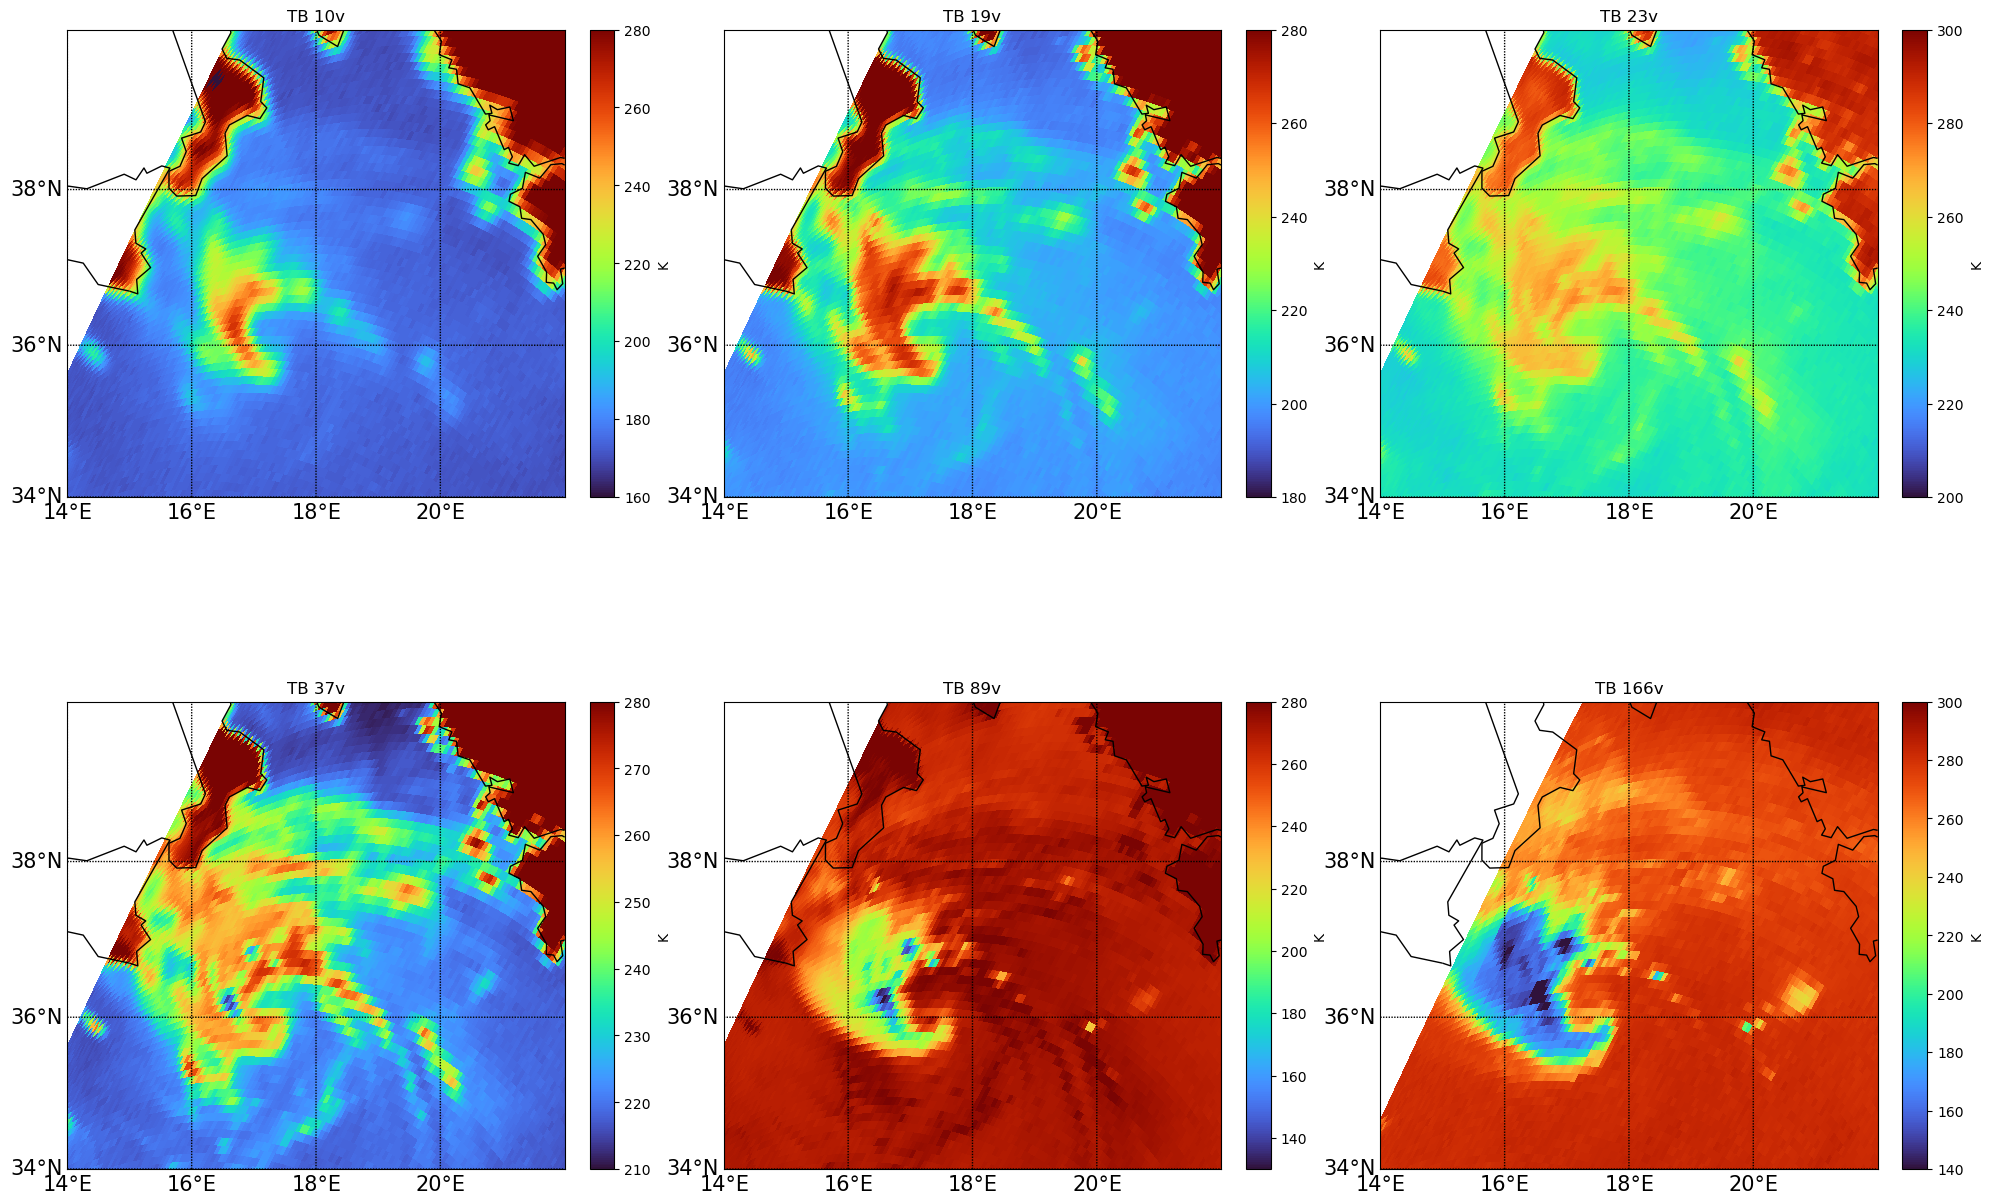

In [4]:
# defining the funcion to plot
def plot_tb_map(TB,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],TB[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
    
# set parallels and meridians
    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('K')



#windows users may need to set an environmental variable before
#import os
#os.environ["PROJ_LIB"] = 'C:'+os.sep+'Users'+os.sep+'Leo'+os.sep+'anaconda3'+os.sep+'Library'+os.sep+'share'; #with your anaconda installation path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')

dataset1=hf['S1']
dataset2=hf['S2']
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB=hf['S1/Tc'][:]
TB10v=TB[:,:,0]
TB10h=TB[:,:,1]
TB19v=TB[:,:,2]
TB19h=TB[:,:,3]
TB23v=TB[:,:,4]
TB37v=TB[:,:,5]
TB37h=TB[:,:,6]
TB89v=TB[:,:,7]
TB89h=TB[:,:,8]

lat2=hf['S2/Latitude'][:]
lon2=hf['S2/Longitude'][:]


TB=hf['S2/Tc'][:]
TB166v=TB[:,:,0]
TB166v[TB166v<0]=np.NaN
TB166h=TB[:,:,1]
hf.close()

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(231)
plot_tb_map(TB10v,lat1,lon1,colorAxisMin=160,colorAxisMax=280)
plt.title('TB 10v')

ax = fig.add_subplot(232)
plot_tb_map(TB19v,lat1,lon1,colorAxisMin=180,colorAxisMax=280)
plt.title('TB 19v')

ax = fig.add_subplot(233)
plot_tb_map(TB23v,lat1,lon1,colorAxisMin=200,colorAxisMax=300)
plt.title('TB 23v')

ax = fig.add_subplot(234)
plot_tb_map(TB37v,lat1,lon1,colorAxisMin=210,colorAxisMax=280)
plt.title('TB 37v')

ax = fig.add_subplot(235)
plot_tb_map(TB89v,lat1,lon1,colorAxisMin=130,colorAxisMax=280)
plt.title('TB 89v')

ax = fig.add_subplot(236)
plot_tb_map(TB166v,lat1,lon1,colorAxisMin=140,colorAxisMax=300)
plt.title('TB 166v')

plt.show()



The panels show the GMI brightness temperatures (TBs) for the overpass which captured the Mediterranean Hurricane (Medicane) named Ianos on 16/09/2020 over the Ionian Sea between Southern Italy and Greece.
The first row of panels shows the low frequency channels (< 30 GHz) affected mostly by the emission of radiation by the rain droplets, which results in higher TBs with respect to the radiatively cold sea surface background (warm areas in the imagery are associated to the precipitation in the rain bands around the cyclone center). The second row of panels shows the higher frequency channels, where the effect of the scattering by the ice on the observed TBs becomes visible as cold areas in the imagery. The scattering signal at 37 GHz and 89 GHz channel (low TBs) are due to the larger (and denser) frozen hydrometeors (hail/graupel) found in the convective cores, while at higher frequency the scattering is due to the smaller size/less dense ice in the upper cloud layers.  The following table summaries the properties of the six GMI frequencies (for further details please refer to D'Adderio et al.,10.1016/j.atmosres.2022.106174).   

 <table>
    
  <tr>
    <th style="text-align:center"> GMI channel</th>
    <th style="text-align:center"> TB warmer than background</th>
    <th style="text-align:center"> TB colder than background</th>
  </tr>
  <tr>
    <td style="text-align:center"> 10 GHz</td>
    <td style="text-align:center"> emission from large raindrops (lower rain layers) </td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 19 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)</td>
    <td style="text-align:center"> - </td>
  </tr>
  <tr>
    <td style="text-align:center"> 22 GHz</td>
    <td style="text-align:center"> emission from large raindrops (rain)<br>emission from  water vapour</td>
    <td style="text-align:center"> - </td>
  </tr>    
  <tr>
    <td style="text-align:center"> 37 GHz</td>
    <td style="text-align:center"> emission from raindrops (rain)</td>
    <td style="text-align:center"> Scattering by large and dense ice<br>(e.g. hail – deep convection)</td>
  </tr>
  <tr>
    <td style="text-align:center"> 89 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by precipitating heavily rimed ice<br>(e.g., graupel – convection/deep convection)</td>
  </tr>
    <tr>
    <td style="text-align:center"> 166 GHz</td>
    <td style="text-align:center"> emission from water vapour<br>and cloud liquid water</td>
    <td style="text-align:center"> Scattering by less dense ice<br>(snowflakes and aggregates – stratiform/convective precip)</td>
  </tr>
</table> 
<center><i>Table 2. Properties of some GMI channels related to clouds and precipitation.</i></center>


# Exercise: training a simple artificial neural network model

This section explains how to train a Multilayer Perceptrons (MLP) Neural Network which predicts the target variable or label (surface rain rate) given a set of 13 pre-defined inputs or features (TBs). The model represents a simple Neural Network (NN) with two hidden layers and a final layer which is used to predict the target label.

The section is composed by the following parts:

1) Data loading and conversion
<br>
2) Dataset description
<br>
3) Training and test data split
<br>
4) Model training 
<br>
5) Model evaluation
<br>
6) Further training of the model and overfitting
<br>
7) Testing the trained model on the initial case study

<div class="alert alert-block alert-warning">
<b>Warning </b> The neural network that will be trained during this exercise is not suitable for scientific/operational purposes, the main limitation comes from the training dataset, which is very small (10 orbits) with respect to the ones used in scientific/operational algorithms, which can include hundreds of thousands of orbits and millions of pixels. Using very large training dataset is of paramount importance for obtaining a model that is general, i.e. a model that performs with the same accuracy when applied to the training or to an independent dataset.
</div>

### 1) Data loading and conversion
First, we will import all the libraries which are necessary to this exercise.
<br>
After loading the data in xarray format, which is one of the most common Python libraries to process netcdf files, the data is transformed into tensors which is the standard format for training Machine Learning or Deep Learning models. 
<br> For the purpose of this exercise, we will use the Tensorflow framework, which is built on top of Keras Python library in order to train a Neural Network.
<br> We observe that the features dataset have 61906 different records and 13 features, whereas the label dataset consist of one variable and 61906 records.

In [5]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

data_path = './dataset2_GMI_DPR_RR.nc'

ds = xr.open_dataset(data_path)

train_df = ds['tb'].to_dataframe().unstack()
target = ds['rr'].to_dataframe()

print('The shape of the features data is', train_df.shape)
print('The shape of the label data is', target.shape)

tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
label_df = tf.convert_to_tensor(target, dtype=np.float)

2023-04-16 15:03:30.509990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The shape of the features data is (61906, 13)
The shape of the label data is (61906, 1)


2023-04-16 15:03:33.858839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:03:33.859515: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 2) Dataset description

The dataset used for training and test of the NN is built from 10 GMI orbits (from 9th March 2014). The 13 features correspond exactly to the 13 GMI channels taken in the same order as in Table 1. The rainfall rate represents the target variable and has been obtained from the NASA GMI/DPR Level 2 precipitation product (2B-CMB). This algorithm combines GMI measurements with the reflectivity profiles measured by the Dual-frequency Precipitation Radar (DPR) on board the GPM Core Observatory, the first spaceborne radar operating at Ka and Ku band (see figure below) and provides vertical profiles of liquid and solid precipitation microphysics, and precipitation rate near the surface. Some details on the 2B-CMB algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpmdpr-level-2-algorithm-theoretical-basis-document-atbd/">GMI/DPR Level 2 Algorithm Theoretical Basis Document (ATBD) </a>.

The GMI TBs and the DPR rainfall rates (from 2B-CMB) have been matched to build the dataset using a nearest neighbour approach. Only pixels over ocean and sea where rainfall has been observed (2B-CMB rainfall rate > 0 mm/h) are selected to build the dataset (for a total of 61906 pixels).
![title](https://rmets.onlinelibrary.wiley.com/cms/asset/6e4beac5-ee9c-4de1-a780-0c34bd06987b/qj3313-fig-0001-m.jpg)
_from: Skofronick-Jackson et al. 2018 doi:10.1002/qj.3313_

### 3) Training and test data split
The objective of Machine Learning is to create a model which is able to learn from training data and consequently make consistent predictions in the presence of unseen data. In order to achieve this, the objective is to minimize a loss function. This is done by identifying a vector of model weights which minimizes the loss function. 
<br>
<br>
In order to train a Machine Learning model which is able to make successful predictions and therefore generalize sufficiently well in the presence of indipendent data coming from the similar distribution, a standard practice is to divide the dataset into __training__ and __test sets__. Generally speaking, the Machine Learning best practice suggests to retain about 80% of the dataset for training and the rest 20% for test purpose. Another common practice is to divide the dataset into three sets, namely train, test and validation in order to tune the model hyperparameters (using the test) and then validate the model on an independent set (validation). 
<br>
<br> In our case, considering that our training set is quite small, we decide to opt for a __50%__ split between training and test set, to allow for a model testing on a comparable size dataset.

In [6]:
def split_dataset(dataset, label_dataset):
    
    choice=np.mod(range(0,len(tensor_df)),2)==0 #this variable is true for even positions in the obseravtions sequence 
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset


print( len(tensor_df))
print( X_train.shape)
print( X_test.shape)


61906
(30953, 13)
(30953, 13)


Subsequently we define the __model hyperparameters__, which influence the model ability to learn.
<br><br>
- The __learning rate__ is the model speed of the learning process: a too high learning rate can save some training time at the expenses of letting the model converge (i.e., minimizing the loss function); a small learning rate can significantly increase the training time and still fail to achieve an efficient minimum. By default, NNs are trained with a decreasing linear schedule, allowing for a constant decrease in the learning rate which helps the model converge.
<br>
- The __batch size__ is the number of samples to include in a single training iteration. The total number of batches can be obtained from: size of the training data/batch_size
<br>
- The number of __epochs__ is the number times that the learning algorithm will work through the entire training dataset
<br>
- Finally, setting the __verbose__ option equal to 1 allow us to obtain information on the training while in progress 

In [7]:
# model hyperparameters
learning_rate1= 0.001  #the learning rate is the step size at each iteration while moving toward a minimum of a loss function
epochs = 1600          #An epoch in machine learning means one complete pass of the training dataset through the algorithm. 
batch_size = 8000      #the batch size is the number of training examples utilized in one iteration. A large batch size should make the training faster but may lead to memory saturation


verbose = 1
# Set the input shape
input_shape = X_train.shape[1]
print(f'Feature shape: {input_shape}')

Feature shape: 13


### 4) Model training

We create a simple model architecture given the small training dataset. In this case we construct a MLP model with two hidden layers. The first layer contains 10 perceptrons, while the second is made of 20 perceptrons. We use a sigmoid activation function (transfer function used in both hidden layers). Finally, we use the mean squared error (MSE) as loss function to be minimised and display the mean average error (MAE) for each training iteration (epoch).
<br> By printing the model it is possible to observe the shape of each layer and the total number of weights to be updated with the training. 

In [8]:
# training phase with the training dataset
def train():
    # here the network achitecture is defined: it is a feed forward neural network with 2 hidden layers, 
    # 20 perceptrons in the fisrt hidden layer and 10 in the second. Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(20, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(10, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, but Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    # here the model optimzer and the loss function to be minimized during training (mean squared error, MSE) are defined
    # the mean absolute error (mae) is also computed as additional metrics
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    
    # the training dataset, the batch size and the number of epochs to be used re defined
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # validation is also carried out
    # monitoring loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
    model.save('./mlp_model.h5') #the model is saved at the end of the training phase in an HFD5 output file
    return model, history

In [9]:
# for trainig with CPU (Slower) uncomment next line.
# model, history = train() 

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model, history = train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 107ms/step - loss: 32.7585 - mae: 2.5941 - val_loss: 33.7341 - val_mae: 2.5786
Epoch 2/1600
4/4 [==============================] - 0s 77ms/step - loss: 32.6155 - mae: 2.5667 - val_loss: 33.5936 - val_mae: 2.5515
Epoch 3/1600
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 80ms/step - loss: 24.3626 - mae: 2.2045 - val_loss: 25.3933 - val_mae: 2.2073
Epoch 118/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.3472 - mae: 2.2055 - val_loss: 25.3779 - val_mae: 2.2083
Epoch 119/1600
4/4 [==============================] - 0s 83ms/step - loss: 24.3324 - mae: 2.2065 - val_loss: 25.3625 - val_mae: 2.2093
Epoch 120/1600
4/4 [==============================] - 0s 75ms/step - loss: 24.3173 - mae: 2.2075 - val_loss: 25.3475 - val_mae: 2.2102
Epoch 121/1600
4/4 [==============================] - 0s 79ms/step - loss: 24.3028 - mae: 2.2085 - val_loss: 25.3325 - val_mae: 2.2111
Epoch 122/1600
4/4 [==============================] - 0s 93ms/step - loss: 24.2880 - mae: 2.2094 - val_loss: 25.3177 - val_mae: 2.2119
Epoch 123/1600
4/4 [==============================] - 0s 79ms/step - loss: 24.2731 - mae: 2.2100 - val_loss: 25.3033 - val_mae: 2.2125
Epoch 124/1600
4/4 [==============================] - 0s 90ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 58ms/step - loss: 23.5608 - mae: 2.2044 - val_loss: 24.5816 - val_mae: 2.2054
Epoch 179/1600
4/4 [==============================] - 0s 60ms/step - loss: 23.5470 - mae: 2.2035 - val_loss: 24.5676 - val_mae: 2.2045
Epoch 180/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.5333 - mae: 2.2027 - val_loss: 24.5534 - val_mae: 2.2038
Epoch 181/1600
4/4 [==============================] - 0s 59ms/step - loss: 23.5189 - mae: 2.2018 - val_loss: 24.5393 - val_mae: 2.2028
Epoch 182/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.5046 - mae: 2.2007 - val_loss: 24.5251 - val_mae: 2.2016
Epoch 183/1600
4/4 [==============================] - 0s 65ms/step - loss: 23.4906 - mae: 2.1997 - val_loss: 24.5107 - val_mae: 2.2008
Epoch 184/1600
4/4 [==============================] - 0s 80ms/step - loss: 23.4759 - mae: 2.1987 - val_loss: 24.4962 - val_mae: 2.1997
Epoch 185/1600
4/4 [==============================] - 0

Epoch 239/1600
4/4 [==============================] - 0s 65ms/step - loss: 22.5578 - mae: 2.1284 - val_loss: 23.5834 - val_mae: 2.1313
Epoch 240/1600
4/4 [==============================] - 0s 67ms/step - loss: 22.5410 - mae: 2.1270 - val_loss: 23.5662 - val_mae: 2.1301
Epoch 241/1600
4/4 [==============================] - 0s 67ms/step - loss: 22.5235 - mae: 2.1257 - val_loss: 23.5492 - val_mae: 2.1289
Epoch 242/1600
4/4 [==============================] - 0s 64ms/step - loss: 22.5063 - mae: 2.1243 - val_loss: 23.5321 - val_mae: 2.1274
Epoch 243/1600
4/4 [==============================] - 0s 57ms/step - loss: 22.4891 - mae: 2.1227 - val_loss: 23.5151 - val_mae: 2.1258
Epoch 244/1600
4/4 [==============================] - 0s 62ms/step - loss: 22.4720 - mae: 2.1211 - val_loss: 23.4981 - val_mae: 2.1244
Epoch 245/1600
4/4 [==============================] - 0s 63ms/step - loss: 22.4549 - mae: 2.1196 - val_loss: 23.4810 - val_mae: 2.1230
Epoch 246/1600
4/4 [==============================] - 0

Epoch 300/1600
4/4 [==============================] - 0s 67ms/step - loss: 21.4711 - mae: 2.0335 - val_loss: 22.4935 - val_mae: 2.0408
Epoch 301/1600
4/4 [==============================] - 0s 59ms/step - loss: 21.4518 - mae: 2.0315 - val_loss: 22.4742 - val_mae: 2.0391
Epoch 302/1600
4/4 [==============================] - 0s 53ms/step - loss: 21.4329 - mae: 2.0299 - val_loss: 22.4547 - val_mae: 2.0377
Epoch 303/1600
4/4 [==============================] - 0s 63ms/step - loss: 21.4132 - mae: 2.0283 - val_loss: 22.4352 - val_mae: 2.0361
Epoch 304/1600
4/4 [==============================] - 0s 69ms/step - loss: 21.3934 - mae: 2.0264 - val_loss: 22.4157 - val_mae: 2.0341
Epoch 305/1600
4/4 [==============================] - 0s 68ms/step - loss: 21.3741 - mae: 2.0244 - val_loss: 22.3961 - val_mae: 2.0323
Epoch 306/1600
4/4 [==============================] - 0s 60ms/step - loss: 21.3546 - mae: 2.0228 - val_loss: 22.3763 - val_mae: 2.0309
Epoch 307/1600
4/4 [==============================] - 0

Epoch 361/1600
4/4 [==============================] - 0s 56ms/step - loss: 20.1884 - mae: 1.9239 - val_loss: 21.2013 - val_mae: 1.9359
Epoch 362/1600
4/4 [==============================] - 0s 60ms/step - loss: 20.1659 - mae: 1.9218 - val_loss: 21.1779 - val_mae: 1.9339
Epoch 363/1600
4/4 [==============================] - 0s 73ms/step - loss: 20.1428 - mae: 1.9198 - val_loss: 21.1544 - val_mae: 1.9316
Epoch 364/1600
4/4 [==============================] - 0s 74ms/step - loss: 20.1192 - mae: 1.9173 - val_loss: 21.1308 - val_mae: 1.9292
Epoch 365/1600
4/4 [==============================] - 0s 72ms/step - loss: 20.0959 - mae: 1.9147 - val_loss: 21.1070 - val_mae: 1.9265
Epoch 366/1600
4/4 [==============================] - 0s 76ms/step - loss: 20.0720 - mae: 1.9120 - val_loss: 21.0827 - val_mae: 1.9239
Epoch 367/1600
4/4 [==============================] - 0s 64ms/step - loss: 20.0485 - mae: 1.9097 - val_loss: 21.0580 - val_mae: 1.9217
Epoch 368/1600
4/4 [==============================] - 0

Epoch 422/1600
4/4 [==============================] - 0s 75ms/step - loss: 18.6151 - mae: 1.7224 - val_loss: 19.5932 - val_mae: 1.7375
Epoch 423/1600
4/4 [==============================] - 0s 73ms/step - loss: 18.5940 - mae: 1.7209 - val_loss: 19.5714 - val_mae: 1.7355
Epoch 424/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.5737 - mae: 1.7190 - val_loss: 19.5497 - val_mae: 1.7342
Epoch 425/1600
4/4 [==============================] - 0s 68ms/step - loss: 18.5524 - mae: 1.7181 - val_loss: 19.5285 - val_mae: 1.7338
Epoch 426/1600
4/4 [==============================] - 0s 65ms/step - loss: 18.5317 - mae: 1.7176 - val_loss: 19.5074 - val_mae: 1.7331
Epoch 427/1600
4/4 [==============================] - 0s 60ms/step - loss: 18.5116 - mae: 1.7171 - val_loss: 19.4864 - val_mae: 1.7327
Epoch 428/1600
4/4 [==============================] - 0s 62ms/step - loss: 18.4915 - mae: 1.7164 - val_loss: 19.4651 - val_mae: 1.7315
Epoch 429/1600
4/4 [==============================] - 0

Epoch 483/1600
4/4 [==============================] - 0s 63ms/step - loss: 17.5019 - mae: 1.6546 - val_loss: 18.4333 - val_mae: 1.6698
Epoch 484/1600
4/4 [==============================] - 0s 60ms/step - loss: 17.4862 - mae: 1.6535 - val_loss: 18.4163 - val_mae: 1.6681
Epoch 485/1600
4/4 [==============================] - 0s 72ms/step - loss: 17.4705 - mae: 1.6514 - val_loss: 18.3996 - val_mae: 1.6659
Epoch 486/1600
4/4 [==============================] - 0s 84ms/step - loss: 17.4545 - mae: 1.6499 - val_loss: 18.3836 - val_mae: 1.6652
Epoch 487/1600
4/4 [==============================] - 0s 57ms/step - loss: 17.4394 - mae: 1.6490 - val_loss: 18.3672 - val_mae: 1.6645
Epoch 488/1600
4/4 [==============================] - 0s 84ms/step - loss: 17.4237 - mae: 1.6484 - val_loss: 18.3508 - val_mae: 1.6637
Epoch 489/1600
4/4 [==============================] - 0s 58ms/step - loss: 17.4080 - mae: 1.6477 - val_loss: 18.3347 - val_mae: 1.6628
Epoch 490/1600
4/4 [==============================] - 0

Epoch 544/1600
4/4 [==============================] - 0s 59ms/step - loss: 16.6875 - mae: 1.6066 - val_loss: 17.5702 - val_mae: 1.6211
Epoch 545/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.6773 - mae: 1.6077 - val_loss: 17.5592 - val_mae: 1.6214
Epoch 546/1600
4/4 [==============================] - 0s 53ms/step - loss: 16.6655 - mae: 1.6068 - val_loss: 17.5463 - val_mae: 1.6194
Epoch 547/1600
4/4 [==============================] - 0s 80ms/step - loss: 16.6549 - mae: 1.6046 - val_loss: 17.5339 - val_mae: 1.6176
Epoch 548/1600
4/4 [==============================] - 0s 88ms/step - loss: 16.6435 - mae: 1.6034 - val_loss: 17.5225 - val_mae: 1.6173
Epoch 549/1600
4/4 [==============================] - 0s 69ms/step - loss: 16.6334 - mae: 1.6038 - val_loss: 17.5114 - val_mae: 1.6176
Epoch 550/1600
4/4 [==============================] - 0s 55ms/step - loss: 16.6223 - mae: 1.6037 - val_loss: 17.4996 - val_mae: 1.6173
Epoch 551/1600
4/4 [==============================] - 0

Epoch 605/1600
4/4 [==============================] - 0s 69ms/step - loss: 16.1048 - mae: 1.5831 - val_loss: 16.9378 - val_mae: 1.5963
Epoch 606/1600
4/4 [==============================] - 0s 73ms/step - loss: 16.0962 - mae: 1.5828 - val_loss: 16.9255 - val_mae: 1.5932
Epoch 607/1600
4/4 [==============================] - 0s 64ms/step - loss: 16.0879 - mae: 1.5791 - val_loss: 16.9155 - val_mae: 1.5901
Epoch 608/1600
4/4 [==============================] - 0s 56ms/step - loss: 16.0809 - mae: 1.5767 - val_loss: 16.9065 - val_mae: 1.5903
Epoch 609/1600
4/4 [==============================] - 0s 61ms/step - loss: 16.0708 - mae: 1.5794 - val_loss: 16.9015 - val_mae: 1.5943
Epoch 610/1600
4/4 [==============================] - 0s 69ms/step - loss: 16.0639 - mae: 1.5818 - val_loss: 16.8917 - val_mae: 1.5935
Epoch 611/1600
4/4 [==============================] - 0s 74ms/step - loss: 16.0543 - mae: 1.5800 - val_loss: 16.8798 - val_mae: 1.5902
Epoch 612/1600
4/4 [==============================] - 0

Epoch 666/1600
4/4 [==============================] - 0s 50ms/step - loss: 15.6513 - mae: 1.5671 - val_loss: 16.4302 - val_mae: 1.5793
Epoch 667/1600
4/4 [==============================] - 0s 77ms/step - loss: 15.6443 - mae: 1.5669 - val_loss: 16.4198 - val_mae: 1.5771
Epoch 668/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.6369 - mae: 1.5655 - val_loss: 16.4117 - val_mae: 1.5759
Epoch 669/1600
4/4 [==============================] - 0s 41ms/step - loss: 15.6297 - mae: 1.5643 - val_loss: 16.4029 - val_mae: 1.5743
Epoch 670/1600
4/4 [==============================] - 0s 66ms/step - loss: 15.6237 - mae: 1.5626 - val_loss: 16.3948 - val_mae: 1.5733
Epoch 671/1600
4/4 [==============================] - 0s 58ms/step - loss: 15.6174 - mae: 1.5630 - val_loss: 16.3898 - val_mae: 1.5756
Epoch 672/1600
4/4 [==============================] - 0s 82ms/step - loss: 15.6105 - mae: 1.5650 - val_loss: 16.3827 - val_mae: 1.5760
Epoch 673/1600
4/4 [==============================] - 0

Epoch 727/1600
4/4 [==============================] - 0s 61ms/step - loss: 15.2718 - mae: 1.5551 - val_loss: 15.9981 - val_mae: 1.5635
Epoch 728/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.2618 - mae: 1.5513 - val_loss: 15.9902 - val_mae: 1.5578
Epoch 729/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.2593 - mae: 1.5479 - val_loss: 15.9843 - val_mae: 1.5585
Epoch 730/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.2527 - mae: 1.5495 - val_loss: 15.9798 - val_mae: 1.5613
Epoch 731/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.2456 - mae: 1.5511 - val_loss: 15.9738 - val_mae: 1.5622
Epoch 732/1600
4/4 [==============================] - 0s 64ms/step - loss: 15.2402 - mae: 1.5529 - val_loss: 15.9689 - val_mae: 1.5639
Epoch 733/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.2348 - mae: 1.5536 - val_loss: 15.9606 - val_mae: 1.5628
Epoch 734/1600
4/4 [==============================] - 0

Epoch 848/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.6712 - mae: 1.5290 - val_loss: 15.3336 - val_mae: 1.5372
Epoch 849/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.6672 - mae: 1.5274 - val_loss: 15.3266 - val_mae: 1.5361
Epoch 850/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.6647 - mae: 1.5266 - val_loss: 15.3228 - val_mae: 1.5373
Epoch 851/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.6598 - mae: 1.5285 - val_loss: 15.3190 - val_mae: 1.5374
Epoch 852/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.6550 - mae: 1.5286 - val_loss: 15.3146 - val_mae: 1.5377
Epoch 853/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.6522 - mae: 1.5267 - val_loss: 15.3063 - val_mae: 1.5343
Epoch 854/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.6469 - mae: 1.5261 - val_loss: 15.3031 - val_mae: 1.5368
Epoch 855/1600
4/4 [==============================] - 0

Epoch 909/1600
4/4 [==============================] - 0s 84ms/step - loss: 14.4316 - mae: 1.5198 - val_loss: 15.0614 - val_mae: 1.5293
Epoch 910/1600
4/4 [==============================] - 0s 82ms/step - loss: 14.4282 - mae: 1.5188 - val_loss: 15.0541 - val_mae: 1.5258
Epoch 911/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.4244 - mae: 1.5159 - val_loss: 15.0496 - val_mae: 1.5245
Epoch 912/1600
4/4 [==============================] - 0s 119ms/step - loss: 14.4228 - mae: 1.5173 - val_loss: 15.0466 - val_mae: 1.5274
Epoch 913/1600
4/4 [==============================] - 0s 104ms/step - loss: 14.4175 - mae: 1.5164 - val_loss: 15.0404 - val_mae: 1.5232
Epoch 914/1600
4/4 [==============================] - 0s 70ms/step - loss: 14.4139 - mae: 1.5147 - val_loss: 15.0353 - val_mae: 1.5246
Epoch 915/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.4116 - mae: 1.5172 - val_loss: 15.0350 - val_mae: 1.5278
Epoch 916/1600
4/4 [==============================] -

4/4 [==============================] - 0s 94ms/step - loss: 14.0380 - mae: 1.5025 - val_loss: 14.5981 - val_mae: 1.5085
Epoch 1030/1600
4/4 [==============================] - 0s 77ms/step - loss: 14.0340 - mae: 1.4994 - val_loss: 14.5915 - val_mae: 1.5039
Epoch 1031/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.0332 - mae: 1.4966 - val_loss: 14.5884 - val_mae: 1.5049
Epoch 1032/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.0300 - mae: 1.4973 - val_loss: 14.5830 - val_mae: 1.5053
Epoch 1033/1600
4/4 [==============================] - 0s 81ms/step - loss: 14.0236 - mae: 1.4994 - val_loss: 14.5839 - val_mae: 1.5095
Epoch 1034/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.0231 - mae: 1.5032 - val_loss: 14.5831 - val_mae: 1.5112
Epoch 1035/1600
4/4 [==============================] - 0s 59ms/step - loss: 14.0214 - mae: 1.5038 - val_loss: 14.5771 - val_mae: 1.5079
Epoch 1036/1600
4/4 [==============================] - 0s 71ms/s

4/4 [==============================] - 0s 68ms/step - loss: 13.7182 - mae: 1.4867 - val_loss: 14.2122 - val_mae: 1.4912
Epoch 1150/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.7171 - mae: 1.4853 - val_loss: 14.2087 - val_mae: 1.4897
Epoch 1151/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.7175 - mae: 1.4832 - val_loss: 14.2049 - val_mae: 1.4895
Epoch 1152/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.7139 - mae: 1.4885 - val_loss: 14.2135 - val_mae: 1.4982
Epoch 1153/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.7108 - mae: 1.4914 - val_loss: 14.2055 - val_mae: 1.4932
Epoch 1154/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.7044 - mae: 1.4857 - val_loss: 14.2007 - val_mae: 1.4879
Epoch 1155/1600
4/4 [==============================] - 0s 57ms/step - loss: 13.7027 - mae: 1.4820 - val_loss: 14.1974 - val_mae: 1.4866
Epoch 1156/1600
4/4 [==============================] - 0s 72ms/s

4/4 [==============================] - 0s 81ms/step - loss: 13.4522 - mae: 1.4787 - val_loss: 13.8983 - val_mae: 1.4826
Epoch 1270/1600
4/4 [==============================] - 0s 86ms/step - loss: 13.4492 - mae: 1.4768 - val_loss: 13.8918 - val_mae: 1.4789
Epoch 1271/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.4458 - mae: 1.4752 - val_loss: 13.8900 - val_mae: 1.4789
Epoch 1272/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.4461 - mae: 1.4747 - val_loss: 13.8881 - val_mae: 1.4799
Epoch 1273/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.4445 - mae: 1.4735 - val_loss: 13.8873 - val_mae: 1.4766
Epoch 1274/1600
4/4 [==============================] - 0s 85ms/step - loss: 13.4398 - mae: 1.4739 - val_loss: 13.8825 - val_mae: 1.4797
Epoch 1275/1600
4/4 [==============================] - 0s 54ms/step - loss: 13.4399 - mae: 1.4767 - val_loss: 13.8792 - val_mae: 1.4798
Epoch 1276/1600
4/4 [==============================] - 0s 92ms/s

4/4 [==============================] - 0s 61ms/step - loss: 13.2282 - mae: 1.4708 - val_loss: 13.6322 - val_mae: 1.4660
Epoch 1390/1600
4/4 [==============================] - 0s 62ms/step - loss: 13.2322 - mae: 1.4590 - val_loss: 13.6377 - val_mae: 1.4610
Epoch 1391/1600
4/4 [==============================] - 0s 51ms/step - loss: 13.2242 - mae: 1.4594 - val_loss: 13.6291 - val_mae: 1.4680
Epoch 1392/1600
4/4 [==============================] - 0s 75ms/step - loss: 13.2190 - mae: 1.4656 - val_loss: 13.6295 - val_mae: 1.4737
Epoch 1393/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.2201 - mae: 1.4702 - val_loss: 13.6252 - val_mae: 1.4748
Epoch 1394/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.2165 - mae: 1.4696 - val_loss: 13.6182 - val_mae: 1.4705
Epoch 1395/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.2177 - mae: 1.4653 - val_loss: 13.6151 - val_mae: 1.4665
Epoch 1396/1600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 75ms/step - loss: 13.0494 - mae: 1.4569 - val_loss: 13.4233 - val_mae: 1.4573
Epoch 1510/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.0467 - mae: 1.4530 - val_loss: 13.4188 - val_mae: 1.4597
Epoch 1511/1600
4/4 [==============================] - 0s 101ms/step - loss: 13.0483 - mae: 1.4625 - val_loss: 13.4214 - val_mae: 1.4732
Epoch 1512/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.0457 - mae: 1.4658 - val_loss: 13.4107 - val_mae: 1.4650
Epoch 1513/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.0358 - mae: 1.4614 - val_loss: 13.4074 - val_mae: 1.4614
Epoch 1514/1600
4/4 [==============================] - 0s 103ms/step - loss: 13.0336 - mae: 1.4564 - val_loss: 13.4097 - val_mae: 1.4577
Epoch 1515/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.0339 - mae: 1.4561 - val_loss: 13.4053 - val_mae: 1.4612
Epoch 1516/1600
4/4 [==============================] - 0s 68ms

### 5) Model evaluation 

Here we plot the learning curves, i.e., the MAE obtained ad each iteration (epoch) as a function of the epoch number. By observing the learning curves, we clearly see that the training and test values of the loss function decrease with the number of epochs. However, the decreasing rate of the two curves slows down, and the two curves become almost flat somewhat near the 1400th epoch, which means that the training of the model is almost completed. Moreover, the two (train and test) loss curves are very similar to each other, this is a clear sign of the generalizability of the model. In other terms, if we train on a dataset and we get the same result on an indipendent test dataset (with different observations) we expect that the application of the model to any other dataset will still give the same accuracy (i.e., validation dataset which is not considered in this exercise).
<br> Overall, it is possible to observe that the two curves do not fully reach and asymptotic value, and it may be possible that a further training of the model brigns to slightly better results.

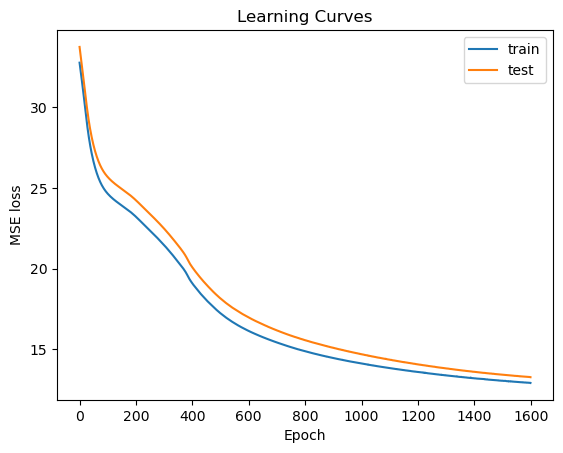

In [10]:
import matplotlib.pyplot as plt
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history.history['loss']), label='train')
plt.plot((history.history['val_loss']), label='test')
plt.legend()
plt.show()

### 6) Further training of the model and overfitting

The model can be further trained for even more Epochs, but it will be subject to overfitting. An overfitting model reproduces too closely the target variable in a specific training dataset, and may therefore fail to fit additional data or predict future observations reliably.  In other words, the model memorizes the training dataset too well, learning also the noise included, and it is not able to generalise any more. <br>The following code loads the model that has been trained in section 6 and trains it further for additional 1000 epochs, using the same training hyperparameters (learning rate, batch size, etc.).

In [11]:
# training phase with the training dataset
fine_tune_epochs = 1000
total_epochs =  epochs + fine_tune_epochs
def train_fine(model):

    optimizer = optimizers.Adam(lr=learning_rate1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    history_fine = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    model.save('./mlp_model_1.h5')
    return model, history_fine
new_model = tf.keras.models.load_model('./mlp_model.h5')

# for trainig with CPU (Slower) uncomment next line.
#model_fine, history_fine = train_fine(new_model)

# for trainig with GPU (Faster) uncomment next 2 lines. works in colab with GPU enabled
with tf.device("/device:GPU:0"):
    model_fine, history_fine = train_fine(new_model)


Epoch 1600/2600
4/4 [==============================] - 1s 134ms/step - loss: 12.9328 - mae: 1.4628 - val_loss: 13.2628 - val_mae: 1.4617
Epoch 1601/2600
4/4 [==============================] - 0s 80ms/step - loss: 12.9285 - mae: 1.4538 - val_loss: 13.2734 - val_mae: 1.4515
Epoch 1602/2600
4/4 [==============================] - 0s 55ms/step - loss: 12.9212 - mae: 1.4520 - val_loss: 13.2683 - val_mae: 1.4602
Epoch 1603/2600
4/4 [==============================] - 0s 55ms/step - loss: 12.9202 - mae: 1.4568 - val_loss: 13.2723 - val_mae: 1.4585
Epoch 1604/2600
4/4 [==============================] - 0s 62ms/step - loss: 12.9161 - mae: 1.4542 - val_loss: 13.2705 - val_mae: 1.4559
Epoch 1605/2600
4/4 [==============================] - 0s 76ms/step - loss: 12.9121 - mae: 1.4544 - val_loss: 13.2637 - val_mae: 1.4587
Epoch 1606/2600
4/4 [==============================] - 0s 68ms/step - loss: 12.9094 - mae: 1.4547 - val_loss: 13.2624 - val_mae: 1.4579
Epoch 1607/2600
4/4 [==========================

4/4 [==============================] - 0s 74ms/step - loss: 12.7344 - mae: 1.4498 - val_loss: 13.0620 - val_mae: 1.4512
Epoch 1721/2600
4/4 [==============================] - 0s 92ms/step - loss: 12.7288 - mae: 1.4494 - val_loss: 13.0585 - val_mae: 1.4533
Epoch 1722/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.7306 - mae: 1.4531 - val_loss: 13.0571 - val_mae: 1.4555
Epoch 1723/2600
4/4 [==============================] - 0s 92ms/step - loss: 12.7301 - mae: 1.4542 - val_loss: 13.0521 - val_mae: 1.4541
Epoch 1724/2600
4/4 [==============================] - 0s 71ms/step - loss: 12.7252 - mae: 1.4510 - val_loss: 13.0560 - val_mae: 1.4496
Epoch 1725/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.7261 - mae: 1.4469 - val_loss: 13.0573 - val_mae: 1.4478
Epoch 1726/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.7269 - mae: 1.4480 - val_loss: 13.0480 - val_mae: 1.4517
Epoch 1727/2600
4/4 [==============================] - 0s 99ms/s

4/4 [==============================] - 0s 99ms/step - loss: 12.6050 - mae: 1.4446 - val_loss: 12.9228 - val_mae: 1.4480
Epoch 1841/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.6083 - mae: 1.4508 - val_loss: 12.9177 - val_mae: 1.4544
Epoch 1842/2600
4/4 [==============================] - 0s 61ms/step - loss: 12.6050 - mae: 1.4504 - val_loss: 12.9219 - val_mae: 1.4469
Epoch 1843/2600
4/4 [==============================] - 0s 47ms/step - loss: 12.6009 - mae: 1.4464 - val_loss: 12.9174 - val_mae: 1.4475
Epoch 1844/2600
4/4 [==============================] - 0s 52ms/step - loss: 12.6052 - mae: 1.4441 - val_loss: 12.9250 - val_mae: 1.4435
Epoch 1845/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.5979 - mae: 1.4447 - val_loss: 12.9128 - val_mae: 1.4500
Epoch 1846/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.5984 - mae: 1.4490 - val_loss: 12.9125 - val_mae: 1.4503
Epoch 1847/2600
4/4 [==============================] - 0s 62ms/s

4/4 [==============================] - 0s 71ms/step - loss: 12.5142 - mae: 1.4436 - val_loss: 12.8408 - val_mae: 1.4437
Epoch 1961/2600
4/4 [==============================] - 0s 60ms/step - loss: 12.5059 - mae: 1.4440 - val_loss: 12.8310 - val_mae: 1.4481
Epoch 1962/2600
4/4 [==============================] - 0s 85ms/step - loss: 12.5067 - mae: 1.4484 - val_loss: 12.8267 - val_mae: 1.4506
Epoch 1963/2600
4/4 [==============================] - 0s 66ms/step - loss: 12.5079 - mae: 1.4477 - val_loss: 12.8304 - val_mae: 1.4463
Epoch 1964/2600
4/4 [==============================] - 0s 117ms/step - loss: 12.5040 - mae: 1.4446 - val_loss: 12.8348 - val_mae: 1.4435
Epoch 1965/2600
4/4 [==============================] - 0s 105ms/step - loss: 12.5052 - mae: 1.4435 - val_loss: 12.8313 - val_mae: 1.4451
Epoch 1966/2600
4/4 [==============================] - 0s 58ms/step - loss: 12.5041 - mae: 1.4430 - val_loss: 12.8382 - val_mae: 1.4425
Epoch 1967/2600
4/4 [==============================] - 0s 68ms

4/4 [==============================] - 0s 94ms/step - loss: 12.4333 - mae: 1.4440 - val_loss: 12.7814 - val_mae: 1.4455
Epoch 2081/2600
4/4 [==============================] - 0s 58ms/step - loss: 12.4351 - mae: 1.4445 - val_loss: 12.7784 - val_mae: 1.4471
Epoch 2082/2600
4/4 [==============================] - 0s 67ms/step - loss: 12.4324 - mae: 1.4435 - val_loss: 12.7869 - val_mae: 1.4427
Epoch 2083/2600
4/4 [==============================] - 0s 72ms/step - loss: 12.4336 - mae: 1.4412 - val_loss: 12.7800 - val_mae: 1.4446
Epoch 2084/2600
4/4 [==============================] - 0s 83ms/step - loss: 12.4295 - mae: 1.4436 - val_loss: 12.7733 - val_mae: 1.4468
Epoch 2085/2600
4/4 [==============================] - 0s 77ms/step - loss: 12.4325 - mae: 1.4467 - val_loss: 12.7733 - val_mae: 1.4481
Epoch 2086/2600
4/4 [==============================] - 0s 54ms/step - loss: 12.4330 - mae: 1.4436 - val_loss: 12.7847 - val_mae: 1.4421
Epoch 2087/2600
4/4 [==============================] - 0s 83ms/s

4/4 [==============================] - 0s 74ms/step - loss: 12.3818 - mae: 1.4412 - val_loss: 12.7435 - val_mae: 1.4411
Epoch 2201/2600
4/4 [==============================] - 0s 67ms/step - loss: 12.3784 - mae: 1.4410 - val_loss: 12.7309 - val_mae: 1.4469
Epoch 2202/2600
4/4 [==============================] - 0s 71ms/step - loss: 12.3751 - mae: 1.4463 - val_loss: 12.7316 - val_mae: 1.4479
Epoch 2203/2600
4/4 [==============================] - 0s 75ms/step - loss: 12.3743 - mae: 1.4440 - val_loss: 12.7345 - val_mae: 1.4435
Epoch 2204/2600
4/4 [==============================] - 0s 75ms/step - loss: 12.3751 - mae: 1.4402 - val_loss: 12.7421 - val_mae: 1.4407
Epoch 2205/2600
4/4 [==============================] - 0s 66ms/step - loss: 12.3774 - mae: 1.4419 - val_loss: 12.7311 - val_mae: 1.4468
Epoch 2206/2600
4/4 [==============================] - 0s 92ms/step - loss: 12.3766 - mae: 1.4431 - val_loss: 12.7404 - val_mae: 1.4435
Epoch 2207/2600
4/4 [==============================] - 0s 100ms/

4/4 [==============================] - 0s 74ms/step - loss: 12.3263 - mae: 1.4398 - val_loss: 12.7146 - val_mae: 1.4393
Epoch 2321/2600
4/4 [==============================] - 0s 88ms/step - loss: 12.3312 - mae: 1.4388 - val_loss: 12.7102 - val_mae: 1.4409
Epoch 2322/2600
4/4 [==============================] - 0s 73ms/step - loss: 12.3266 - mae: 1.4391 - val_loss: 12.7095 - val_mae: 1.4421
Epoch 2323/2600
4/4 [==============================] - 0s 79ms/step - loss: 12.3266 - mae: 1.4409 - val_loss: 12.7058 - val_mae: 1.4445
Epoch 2324/2600
4/4 [==============================] - 0s 66ms/step - loss: 12.3280 - mae: 1.4431 - val_loss: 12.7033 - val_mae: 1.4452
Epoch 2325/2600
4/4 [==============================] - 0s 76ms/step - loss: 12.3341 - mae: 1.4404 - val_loss: 12.7171 - val_mae: 1.4400
Epoch 2326/2600
4/4 [==============================] - 0s 93ms/step - loss: 12.3278 - mae: 1.4387 - val_loss: 12.7052 - val_mae: 1.4443
Epoch 2327/2600
4/4 [==============================] - 0s 72ms/s

4/4 [==============================] - 0s 66ms/step - loss: 12.2919 - mae: 1.4413 - val_loss: 12.6845 - val_mae: 1.4442
Epoch 2441/2600
4/4 [==============================] - 0s 73ms/step - loss: 12.2911 - mae: 1.4422 - val_loss: 12.6845 - val_mae: 1.4437
Epoch 2442/2600
4/4 [==============================] - 0s 84ms/step - loss: 12.2896 - mae: 1.4415 - val_loss: 12.6862 - val_mae: 1.4433
Epoch 2443/2600
4/4 [==============================] - 0s 67ms/step - loss: 12.2927 - mae: 1.4394 - val_loss: 12.6921 - val_mae: 1.4416
Epoch 2444/2600
4/4 [==============================] - 0s 85ms/step - loss: 12.2945 - mae: 1.4409 - val_loss: 12.6843 - val_mae: 1.4443
Epoch 2445/2600
4/4 [==============================] - 0s 82ms/step - loss: 12.3042 - mae: 1.4386 - val_loss: 12.6936 - val_mae: 1.4403
Epoch 2446/2600
4/4 [==============================] - 0s 62ms/step - loss: 12.2915 - mae: 1.4385 - val_loss: 12.6807 - val_mae: 1.4449
Epoch 2447/2600
4/4 [==============================] - 0s 62ms/s

4/4 [==============================] - 0s 102ms/step - loss: 12.2668 - mae: 1.4347 - val_loss: 12.6804 - val_mae: 1.4374
Epoch 2561/2600
4/4 [==============================] - 0s 81ms/step - loss: 12.2623 - mae: 1.4375 - val_loss: 12.6602 - val_mae: 1.4455
Epoch 2562/2600
4/4 [==============================] - 0s 61ms/step - loss: 12.2669 - mae: 1.4412 - val_loss: 12.6651 - val_mae: 1.4434
Epoch 2563/2600
4/4 [==============================] - 0s 78ms/step - loss: 12.2653 - mae: 1.4428 - val_loss: 12.6639 - val_mae: 1.4465
Epoch 2564/2600
4/4 [==============================] - 0s 78ms/step - loss: 12.2627 - mae: 1.4428 - val_loss: 12.6666 - val_mae: 1.4435
Epoch 2565/2600
4/4 [==============================] - 0s 69ms/step - loss: 12.2604 - mae: 1.4416 - val_loss: 12.6653 - val_mae: 1.4431
Epoch 2566/2600
4/4 [==============================] - 0s 54ms/step - loss: 12.2643 - mae: 1.4377 - val_loss: 12.6735 - val_mae: 1.4396
Epoch 2567/2600
4/4 [==============================] - 0s 43ms/

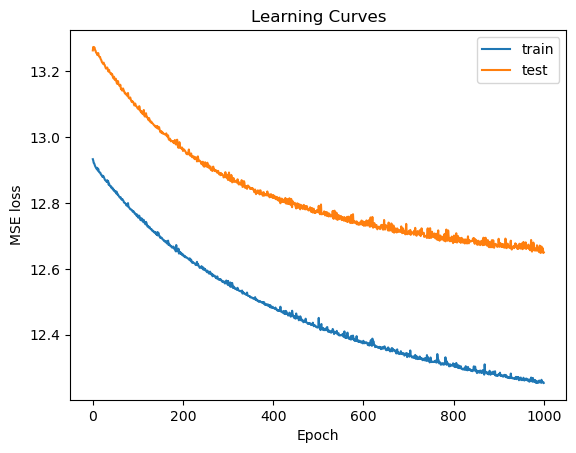

In [12]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot((history_fine.history['loss']), label='train')
plt.plot((history_fine.history['val_loss']), label='test')
plt.legend()
plt.show()

Overfitting can be observed as the training loss continues to decrease with the Epochs, improving the accuracy, while the test loss shows a slower decrease. With more training epochs the test loss should reach an asymptotic value and not decrease anymore. 

### 7) Testing the trained model on the initial case study

The trained model is now applied to a real case study, the GMI overpass of Medicane Ianos on 16/09/2020 seen before, and the reult will be compared with the surface precipitation estimates provided by the NASA Goddard Profiling Algorithm, the official GPM preciptiation product for the GMI radiometer. Some details on the GPROF algorithm can be found in <a href="https://gpm.nasa.gov/resources/documents/gpm-gprof-algorithm-theoretical-basis-document-atbd/">GPM GPROF Algorithm Theoretical Basis Document (ATBD)  </a>.


In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import warnings

# defining the function to plot
def plot_rr_map(RR,lat,lon,colorAxisMin,colorAxisMax):
    # set the lat/lon borders of the map
    latborders=[34,40]
    lonborders=[14,22]
    m = Basemap(projection='merc',
        resolution='l',
        lat_ts=20,
        llcrnrlat=latborders[0],urcrnrlat=latborders[1],\
        llcrnrlon=lonborders[0],urcrnrlon=lonborders[1])

    
#E set min/max values of the colorbar
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im1 = m.pcolor(lon[:],lat[:],RR[:],shading='nearest',cmap='turbo',latlon=True,vmin=colorAxisMin,vmax=colorAxisMax)
    m.drawcoastlines()
# set parallels and meridians

    dparal=2 #separation in deg between drawn parallels
    parallels = np.arange(latborders[0],latborders[1],dparal)
    dmerid=2 #separation in deg between drawn meridians
    meridians = np.arange(lonborders[0],lonborders[1],dmerid)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15) 
# add colorbar.
    cbar = m.colorbar(location='right',pad="5%")
    cbar.set_label('Rainfall Rate [mm/h]')
    
gmi_file_path='./1C-R.GPM.GMI.XCAL2016-C.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gmi_file_path,'r')
lat1=hf['S1/Latitude'][:]
lon1=hf['S1/Longitude'][:]
TB1=hf['S1/Tc'][:]
TB2=hf['S2/Tc'][:]
hf.close()

TB=np.concatenate((TB1,TB2,),axis=2)
TB=np.reshape(TB,(2963*221,13))
TB[np.any(TB<=0,axis=1),:]=np.NaN
TB = scaler.transform(TB)
predictions = model.predict(TB)
predictions = np.reshape(predictions,(2963,221))


gprof_file_path='./2A.GPM.GMI.GPROF2021v1.20200916-S130832-E144106.037225.V07A.HDF5'
hf=h5py.File(gprof_file_path,'r')
lat2=hf['S1/Latitude'][:]
lon2=hf['S1/Longitude'][:]
gprof_rr=hf['S1/surfacePrecipitation'][:]
hf.close()

20464/20464 [==============================] - 70s 3ms/step


Text(0.5, 1.0, 'GPROF')

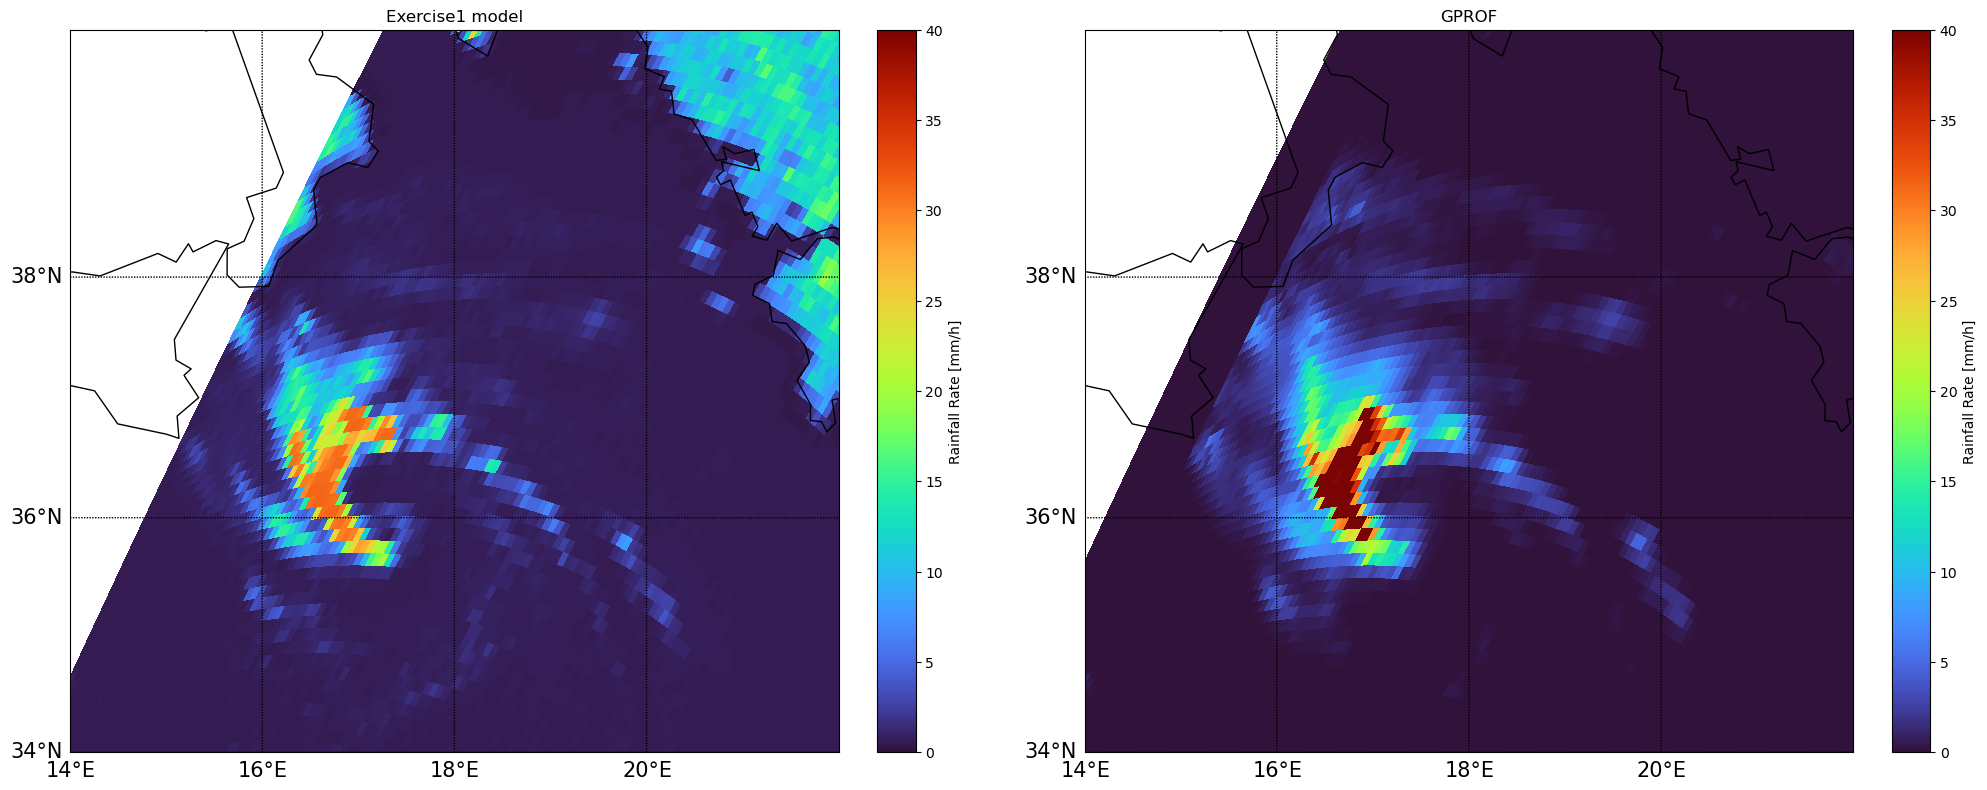

In [14]:

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(121)
plot_rr_map(predictions,lat1,lon1,0,40)
plt.title('Exercise1 model',fontsize=12)
ax = fig.add_subplot(122)
plot_rr_map(gprof_rr,lat2,lon2,0,40)
plt.title('GPROF',fontsize=12)

The result obtained by our NN model seems quite acceptable, the rainfall patterns predicted by our model are quite similar to those of GPROF, which is based on a physically-based Bayesian approach and is a very complex algorithm. It is important to highlight that:
 1. The GMI observation of Madicane Ianos is not included in the training dataset (training dataset is built from 10 orbits of March 2014, while Medicane Ianos occured on 16/09/2020).
 2. The NN model precipitation rate estimates over land and coastal areas are not reliable, as the training dataset does not include measurements over land (the precipitation retrieval over land is much more complex than over ocean and it has not been address in this exercise).
 3. The high rainfall rates are underestimated, probably due to the small size of the training dataset, since intense rainfall is rare and probably it is not well represented in our limited-size training dataset.
 4. Very low precipitation rates are present also in areas where the GPROF algorithm does not predict any precipitation, since the training dataset includes only pixels with precipitation (rainfall rate > 0 mm/h), and it has not learned how to disciminate between rain and no-rain pixels (precipitation detection is often handled using a different ML approach).
 5. Remember that the trainig dataset is very small (10 orbits over ocean only) and the NN model obtained with this exercise is not suitable for operational or scientific purposes.

# Additional Exercises

Using the following code try to train the model differently. In particular:

1. try to modify the learning rate and the epoch number (try learning rates 0.01, 0.002, 0.0005 0.0001)
2. modify the model architecture, varying the number of perceptrons in each hidden layer (40/10, 20/30)
3. try to remove one or more input GMI channels (e.g. the first two at 10 GHz which are more directly impacted by surface precipitation)

In [15]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import xarray as xr

import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def load_dataset():
    warnings.filterwarnings("ignore")
    data_path = './dataset2_GMI_DPR_RR.nc'
    ds = xr.open_dataset(data_path)
    train_df = ds['tb'].to_dataframe().unstack()
    target = ds['rr'].to_dataframe()
    tensor_df = tf.convert_to_tensor(train_df, dtype=np.float)
    label_df = tf.convert_to_tensor(target, dtype=np.float)
    return tensor_df,label_df

def split_dataset(dataset, label_dataset):
    #split = round(test_split* len(tensor_df))
    choice=np.mod(range(0,len(tensor_df)),2)==0
    X_train = dataset[choice==0]
    X_test = dataset[choice]
    y_train = label_dataset[choice==0]
    y_test = label_dataset[choice]   
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(tensor_df, label_df)

# Scaling: Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #mean and variance are calculated on the training dataset and applied to the training dataset
X_test_scaled = scaler.transform(X_test)       #mean and variance (previously calculated) are applied to the test dataset

# Set the input shape
input_shape = X_train.shape[1]


def train(learning_rate1, num_percept_layer1, num_percept_layer2):
    # here the network achitecture is defined: here it is a feed forward neural network with 2 hidden layers, 
    # Sigmoids are used as transfer function in both hidden layers.
    model = Sequential()
    model.add(Dense(num_percept_layer1, input_dim=input_shape, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(num_percept_layer2, kernel_initializer='normal', activation='sigmoid')) ###second hidden
    model.add(Dense(1, kernel_initializer='normal', activation='linear')) #output
    model.summary()
    #the optimizer is the algorithm used for the training. Adam is a standard choice, Scale conjugate gradient (SGD), is also very efficient.
    optimizer = optimizers.Adam(lr=learning_rate1)
    #optimizer = optimizers.experimental.SGD( learning_rate=learning_rate1)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # the loss function to be minimized during training is the mean squared error (MSE)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
    # We also carry out some validation to
    # monitor loss and metrics on the test dataset
    # at the end of each epoch
        validation_data=(X_test_scaled, y_test),)
        #validation_data=(X_test, np.log10(y_test)),)
    return model, history


verbose = 1

# My exploration of the exercises

Below is my code to explore around the above proposals for the exercises.

Let us begin by defining a function wrapping all the training. We will tune separately the learning rate and the number of perceptrons.

## Tuning the learning rate

The learning rate was taken to be 0.001 in the begining of the notebook. We now look for a better one.

In [16]:
def tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2):
    
    # setting the subplots figure
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle('Learning_curves')
    fig.set_figheight(20)
    fig.set_figwidth(15)

    for i in range(len(learning_rates)):
    
        learning_rate1=learning_rates[i]
    
        model, history = train(learning_rate1, num_percept_layer1, num_percept_layer2)

        model.save('./exer2_model.h5')

        # plot learning curves
        axs[i].set_title('Learning curves with learning rate = '+str(learning_rate1))
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('MSE loss')
        axs[i].plot((history.history['loss']), label='train')
        axs[i].plot((history.history['val_loss']), label='test')
        axs[i].legend()
    
    plt.show()


Begin first with the traning rate values proposed above (if needed, scroll down the ouput cell to view the plots):

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                280       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 150ms/step - loss: 31.0507 - mae: 2.2529 - val_loss: 31.2388 - val_mae: 2.1099
Epoch 2/1600
4/4 [==============================] - 0s 61ms/step - loss: 29.6496 - mae: 2.0510 - val_loss: 29.7668 - val_mae: 1.9813
Epoch 3/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 69ms/step - loss: 14.2996 - mae: 1.5095 - val_loss: 14.8821 - val_mae: 1.5200
Epoch 118/1600
4/4 [==============================] - 0s 52ms/step - loss: 14.2780 - mae: 1.5037 - val_loss: 14.8214 - val_mae: 1.5187
Epoch 119/1600
4/4 [==============================] - 0s 61ms/step - loss: 14.2854 - mae: 1.5260 - val_loss: 14.8047 - val_mae: 1.5045
Epoch 120/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.2581 - mae: 1.4947 - val_loss: 14.8178 - val_mae: 1.5274
Epoch 121/1600
4/4 [==============================] - 0s 75ms/step - loss: 14.2298 - mae: 1.5179 - val_loss: 14.7873 - val_mae: 1.4955
Epoch 122/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.2229 - mae: 1.4959 - val_loss: 14.8135 - val_mae: 1.5388
Epoch 123/1600
4/4 [==============================] - 0s 63ms/step - loss: 14.2090 - mae: 1.5112 - val_loss: 14.7368 - val_mae: 1.4991
Epoch 124/1600
4/4 [==============================] - 0s 63ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.4469 - mae: 1.4745 - val_loss: 13.8550 - val_mae: 1.4824
Epoch 179/1600
4/4 [==============================] - 0s 58ms/step - loss: 13.4516 - mae: 1.4786 - val_loss: 13.8560 - val_mae: 1.4726
Epoch 180/1600
4/4 [==============================] - 0s 42ms/step - loss: 13.4300 - mae: 1.4774 - val_loss: 13.8259 - val_mae: 1.4921
Epoch 181/1600
4/4 [==============================] - 0s 48ms/step - loss: 13.4251 - mae: 1.4896 - val_loss: 13.8294 - val_mae: 1.4704
Epoch 182/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.4296 - mae: 1.4703 - val_loss: 13.8195 - val_mae: 1.4697
Epoch 183/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.4243 - mae: 1.4696 - val_loss: 13.8001 - val_mae: 1.4736
Epoch 184/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.4260 - mae: 1.4677 - val_loss: 13.8073 - val_mae: 1.5009
Epoch 185/1600
4/4 [==============================] - 0

Epoch 299/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.7480 - mae: 1.4584 - val_loss: 13.0356 - val_mae: 1.4726
Epoch 300/1600
4/4 [==============================] - 0s 67ms/step - loss: 12.8353 - mae: 1.4791 - val_loss: 13.2192 - val_mae: 1.4257
Epoch 301/1600
4/4 [==============================] - 0s 56ms/step - loss: 12.8658 - mae: 1.4283 - val_loss: 13.1752 - val_mae: 1.5026
Epoch 302/1600
4/4 [==============================] - 0s 51ms/step - loss: 12.8530 - mae: 1.4833 - val_loss: 13.1201 - val_mae: 1.4378
Epoch 303/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.7737 - mae: 1.4408 - val_loss: 13.0464 - val_mae: 1.4822
Epoch 304/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.7667 - mae: 1.4836 - val_loss: 13.1574 - val_mae: 1.4473
Epoch 305/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.8065 - mae: 1.4601 - val_loss: 13.0265 - val_mae: 1.4535
Epoch 306/1600
4/4 [==============================] - 0

Epoch 360/1600
4/4 [==============================] - 0s 61ms/step - loss: 12.6692 - mae: 1.4334 - val_loss: 12.8906 - val_mae: 1.4537
Epoch 361/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.5719 - mae: 1.4757 - val_loss: 12.8623 - val_mae: 1.4832
Epoch 362/1600
4/4 [==============================] - 0s 51ms/step - loss: 12.5546 - mae: 1.4630 - val_loss: 12.9341 - val_mae: 1.4390
Epoch 363/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.5621 - mae: 1.4442 - val_loss: 12.8423 - val_mae: 1.4620
Epoch 364/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.6109 - mae: 1.4666 - val_loss: 12.9446 - val_mae: 1.4315
Epoch 365/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.6509 - mae: 1.4306 - val_loss: 12.8400 - val_mae: 1.4712
Epoch 366/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.6219 - mae: 1.4901 - val_loss: 12.8662 - val_mae: 1.4525
Epoch 367/1600
4/4 [==============================] - 0

Epoch 421/1600
4/4 [==============================] - 0s 64ms/step - loss: 12.4337 - mae: 1.4573 - val_loss: 12.7332 - val_mae: 1.4487
Epoch 422/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.4295 - mae: 1.4512 - val_loss: 12.7674 - val_mae: 1.4421
Epoch 423/1600
4/4 [==============================] - 0s 86ms/step - loss: 12.4607 - mae: 1.4405 - val_loss: 12.7198 - val_mae: 1.4593
Epoch 424/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.4378 - mae: 1.4588 - val_loss: 12.7384 - val_mae: 1.4445
Epoch 425/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.4753 - mae: 1.4373 - val_loss: 12.7170 - val_mae: 1.4577
Epoch 426/1600
4/4 [==============================] - 0s 92ms/step - loss: 12.4433 - mae: 1.4599 - val_loss: 12.7484 - val_mae: 1.4468
Epoch 427/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.4239 - mae: 1.4473 - val_loss: 12.7195 - val_mae: 1.4573
Epoch 428/1600
4/4 [==============================] - 0

Epoch 542/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.2462 - mae: 1.4470 - val_loss: 12.5797 - val_mae: 1.4535
Epoch 543/1600
4/4 [==============================] - 0s 92ms/step - loss: 12.2571 - mae: 1.4451 - val_loss: 12.6035 - val_mae: 1.4418
Epoch 544/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.2418 - mae: 1.4382 - val_loss: 12.5846 - val_mae: 1.4455
Epoch 545/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.2621 - mae: 1.4510 - val_loss: 12.6146 - val_mae: 1.4436
Epoch 546/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.2475 - mae: 1.4353 - val_loss: 12.6183 - val_mae: 1.4392
Epoch 547/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.2496 - mae: 1.4453 - val_loss: 12.6011 - val_mae: 1.4420
Epoch 548/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.2593 - mae: 1.4322 - val_loss: 12.5784 - val_mae: 1.4517
Epoch 549/1600
4/4 [==============================] - 0

Epoch 603/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.4745 - mae: 1.4160 - val_loss: 12.6614 - val_mae: 1.4886
Epoch 604/1600
4/4 [==============================] - 0s 81ms/step - loss: 12.2939 - mae: 1.4767 - val_loss: 12.6955 - val_mae: 1.4289
Epoch 605/1600
4/4 [==============================] - 0s 91ms/step - loss: 12.2688 - mae: 1.4256 - val_loss: 12.5447 - val_mae: 1.4554
Epoch 606/1600
4/4 [==============================] - 0s 83ms/step - loss: 12.2234 - mae: 1.4613 - val_loss: 12.6261 - val_mae: 1.4459
Epoch 607/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.1721 - mae: 1.4434 - val_loss: 12.6293 - val_mae: 1.4443
Epoch 608/1600
4/4 [==============================] - 0s 86ms/step - loss: 12.1788 - mae: 1.4486 - val_loss: 12.5857 - val_mae: 1.4507
Epoch 609/1600
4/4 [==============================] - 0s 85ms/step - loss: 12.1647 - mae: 1.4371 - val_loss: 12.5815 - val_mae: 1.4405
Epoch 610/1600
4/4 [==============================] - 0

Epoch 664/1600
4/4 [==============================] - 0s 84ms/step - loss: 12.0534 - mae: 1.4340 - val_loss: 12.6471 - val_mae: 1.4341
Epoch 665/1600
4/4 [==============================] - 0s 96ms/step - loss: 12.0574 - mae: 1.4356 - val_loss: 12.5656 - val_mae: 1.4595
Epoch 666/1600
4/4 [==============================] - 0s 90ms/step - loss: 12.0983 - mae: 1.4435 - val_loss: 12.6125 - val_mae: 1.4433
Epoch 667/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.0664 - mae: 1.4388 - val_loss: 12.5576 - val_mae: 1.4469
Epoch 668/1600
4/4 [==============================] - 0s 87ms/step - loss: 12.0763 - mae: 1.4436 - val_loss: 12.6603 - val_mae: 1.4278
Epoch 669/1600
4/4 [==============================] - 0s 82ms/step - loss: 12.1192 - mae: 1.4295 - val_loss: 12.5681 - val_mae: 1.4608
Epoch 670/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.0724 - mae: 1.4398 - val_loss: 12.5939 - val_mae: 1.4404
Epoch 671/1600
4/4 [==============================] - 0

Epoch 725/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.0028 - mae: 1.4255 - val_loss: 12.5299 - val_mae: 1.4393
Epoch 726/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.0748 - mae: 1.4460 - val_loss: 12.6251 - val_mae: 1.4279
Epoch 727/1600
4/4 [==============================] - 0s 86ms/step - loss: 12.0449 - mae: 1.4197 - val_loss: 12.5495 - val_mae: 1.4602
Epoch 728/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.0577 - mae: 1.4593 - val_loss: 12.7090 - val_mae: 1.4297
Epoch 729/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.0778 - mae: 1.4313 - val_loss: 12.5539 - val_mae: 1.4440
Epoch 730/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.0202 - mae: 1.4271 - val_loss: 12.5396 - val_mae: 1.4520
Epoch 731/1600
4/4 [==============================] - 0s 82ms/step - loss: 11.9937 - mae: 1.4541 - val_loss: 12.5436 - val_mae: 1.4414
Epoch 732/1600
4/4 [==============================] - 0

Epoch 786/1600
4/4 [==============================] - 0s 55ms/step - loss: 11.9138 - mae: 1.4228 - val_loss: 12.5674 - val_mae: 1.4614
Epoch 787/1600
4/4 [==============================] - 0s 67ms/step - loss: 11.9469 - mae: 1.4497 - val_loss: 12.6973 - val_mae: 1.4267
Epoch 788/1600
4/4 [==============================] - 0s 66ms/step - loss: 11.9608 - mae: 1.4233 - val_loss: 12.5741 - val_mae: 1.4655
Epoch 789/1600
4/4 [==============================] - 0s 86ms/step - loss: 11.9897 - mae: 1.4574 - val_loss: 12.9028 - val_mae: 1.4168
Epoch 790/1600
4/4 [==============================] - 0s 92ms/step - loss: 12.0490 - mae: 1.4138 - val_loss: 12.5683 - val_mae: 1.4692
Epoch 791/1600
4/4 [==============================] - 0s 79ms/step - loss: 12.0013 - mae: 1.4643 - val_loss: 12.7661 - val_mae: 1.4366
Epoch 792/1600
4/4 [==============================] - 0s 88ms/step - loss: 11.9903 - mae: 1.4345 - val_loss: 12.5503 - val_mae: 1.4495
Epoch 793/1600
4/4 [==============================] - 0

Epoch 847/1600
4/4 [==============================] - 0s 78ms/step - loss: 11.8547 - mae: 1.4363 - val_loss: 12.5926 - val_mae: 1.4414
Epoch 848/1600
4/4 [==============================] - 0s 71ms/step - loss: 11.8569 - mae: 1.4252 - val_loss: 12.5747 - val_mae: 1.4421
Epoch 849/1600
4/4 [==============================] - 0s 57ms/step - loss: 11.8350 - mae: 1.4367 - val_loss: 12.5805 - val_mae: 1.4477
Epoch 850/1600
4/4 [==============================] - 0s 82ms/step - loss: 11.8367 - mae: 1.4309 - val_loss: 12.6137 - val_mae: 1.4382
Epoch 851/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.9116 - mae: 1.4435 - val_loss: 12.7062 - val_mae: 1.4285
Epoch 852/1600
4/4 [==============================] - 0s 74ms/step - loss: 11.8953 - mae: 1.4139 - val_loss: 12.5842 - val_mae: 1.4595
Epoch 853/1600
4/4 [==============================] - 0s 82ms/step - loss: 11.9669 - mae: 1.4665 - val_loss: 12.8846 - val_mae: 1.4256
Epoch 854/1600
4/4 [==============================] - 0

Epoch 908/1600
4/4 [==============================] - 0s 75ms/step - loss: 11.7932 - mae: 1.4242 - val_loss: 12.5969 - val_mae: 1.4466
Epoch 909/1600
4/4 [==============================] - 0s 90ms/step - loss: 11.7670 - mae: 1.4321 - val_loss: 12.5981 - val_mae: 1.4461
Epoch 910/1600
4/4 [==============================] - 0s 89ms/step - loss: 11.7694 - mae: 1.4343 - val_loss: 12.6104 - val_mae: 1.4461
Epoch 911/1600
4/4 [==============================] - 0s 92ms/step - loss: 11.7671 - mae: 1.4324 - val_loss: 12.5638 - val_mae: 1.4450
Epoch 912/1600
4/4 [==============================] - 0s 63ms/step - loss: 11.7883 - mae: 1.4289 - val_loss: 12.6453 - val_mae: 1.4393
Epoch 913/1600
4/4 [==============================] - 0s 84ms/step - loss: 11.7882 - mae: 1.4393 - val_loss: 12.5931 - val_mae: 1.4435
Epoch 914/1600
4/4 [==============================] - 0s 83ms/step - loss: 11.7740 - mae: 1.4280 - val_loss: 12.6407 - val_mae: 1.4355
Epoch 915/1600
4/4 [==============================] - 0

Epoch 969/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.7633 - mae: 1.4530 - val_loss: 12.9618 - val_mae: 1.4204
Epoch 970/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.8486 - mae: 1.4089 - val_loss: 12.6998 - val_mae: 1.4761
Epoch 971/1600
4/4 [==============================] - 0s 88ms/step - loss: 11.9675 - mae: 1.4651 - val_loss: 13.3505 - val_mae: 1.4179
Epoch 972/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.2762 - mae: 1.4081 - val_loss: 12.7329 - val_mae: 1.5108
Epoch 973/1600
4/4 [==============================] - 0s 84ms/step - loss: 12.0683 - mae: 1.4923 - val_loss: 13.0083 - val_mae: 1.4192
Epoch 974/1600
4/4 [==============================] - 0s 96ms/step - loss: 12.0746 - mae: 1.4013 - val_loss: 12.6356 - val_mae: 1.4748
Epoch 975/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.0335 - mae: 1.4811 - val_loss: 12.9417 - val_mae: 1.4328
Epoch 976/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 79ms/step - loss: 11.6690 - mae: 1.4349 - val_loss: 12.6423 - val_mae: 1.4437
Epoch 1090/1600
4/4 [==============================] - 0s 73ms/step - loss: 11.5994 - mae: 1.4307 - val_loss: 12.6473 - val_mae: 1.4408
Epoch 1091/1600
4/4 [==============================] - 0s 65ms/step - loss: 11.5959 - mae: 1.4235 - val_loss: 12.6886 - val_mae: 1.4381
Epoch 1092/1600
4/4 [==============================] - 0s 76ms/step - loss: 11.5949 - mae: 1.4290 - val_loss: 12.6554 - val_mae: 1.4455
Epoch 1093/1600
4/4 [==============================] - 0s 55ms/step - loss: 11.6202 - mae: 1.4294 - val_loss: 12.6166 - val_mae: 1.4517
Epoch 1094/1600
4/4 [==============================] - 0s 71ms/step - loss: 11.6252 - mae: 1.4295 - val_loss: 12.7220 - val_mae: 1.4290
Epoch 1095/1600
4/4 [==============================] - 0s 62ms/step - loss: 11.6097 - mae: 1.4205 - val_loss: 12.6610 - val_mae: 1.4550
Epoch 1096/1600
4/4 [==============================] - 0s 77ms/s

4/4 [==============================] - 0s 75ms/step - loss: 11.5291 - mae: 1.4356 - val_loss: 12.7222 - val_mae: 1.4466
Epoch 1210/1600
4/4 [==============================] - 0s 78ms/step - loss: 11.5910 - mae: 1.4187 - val_loss: 12.7509 - val_mae: 1.4406
Epoch 1211/1600
4/4 [==============================] - 0s 60ms/step - loss: 11.5116 - mae: 1.4319 - val_loss: 12.7047 - val_mae: 1.4512
Epoch 1212/1600
4/4 [==============================] - 0s 82ms/step - loss: 11.6253 - mae: 1.4271 - val_loss: 12.7098 - val_mae: 1.4518
Epoch 1213/1600
4/4 [==============================] - 0s 71ms/step - loss: 11.5493 - mae: 1.4315 - val_loss: 12.7225 - val_mae: 1.4368
Epoch 1214/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.5086 - mae: 1.4144 - val_loss: 12.7197 - val_mae: 1.4439
Epoch 1215/1600
4/4 [==============================] - 0s 58ms/step - loss: 11.4937 - mae: 1.4369 - val_loss: 12.7487 - val_mae: 1.4604
Epoch 1216/1600
4/4 [==============================] - 0s 54ms/s

4/4 [==============================] - 0s 95ms/step - loss: 11.4160 - mae: 1.4301 - val_loss: 12.7942 - val_mae: 1.4408
Epoch 1330/1600
4/4 [==============================] - 0s 83ms/step - loss: 11.3970 - mae: 1.4172 - val_loss: 12.8569 - val_mae: 1.4365
Epoch 1331/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.3860 - mae: 1.4201 - val_loss: 12.8115 - val_mae: 1.4467
Epoch 1332/1600
4/4 [==============================] - 0s 70ms/step - loss: 11.4049 - mae: 1.4237 - val_loss: 12.8832 - val_mae: 1.4471
Epoch 1333/1600
4/4 [==============================] - 0s 98ms/step - loss: 11.3854 - mae: 1.4262 - val_loss: 12.8304 - val_mae: 1.4525
Epoch 1334/1600
4/4 [==============================] - 0s 62ms/step - loss: 11.4235 - mae: 1.4309 - val_loss: 12.8484 - val_mae: 1.4383
Epoch 1335/1600
4/4 [==============================] - 0s 77ms/step - loss: 11.3851 - mae: 1.4157 - val_loss: 12.8672 - val_mae: 1.4275
Epoch 1336/1600
4/4 [==============================] - 0s 93ms/s

4/4 [==============================] - 0s 97ms/step - loss: 11.3195 - mae: 1.4103 - val_loss: 12.9043 - val_mae: 1.4602
Epoch 1450/1600
4/4 [==============================] - 0s 74ms/step - loss: 11.3199 - mae: 1.4382 - val_loss: 12.9734 - val_mae: 1.4489
Epoch 1451/1600
4/4 [==============================] - 0s 98ms/step - loss: 11.3203 - mae: 1.4228 - val_loss: 12.9588 - val_mae: 1.4368
Epoch 1452/1600
4/4 [==============================] - 0s 111ms/step - loss: 11.2901 - mae: 1.4112 - val_loss: 12.9474 - val_mae: 1.4303
Epoch 1453/1600
4/4 [==============================] - 0s 100ms/step - loss: 11.4145 - mae: 1.4242 - val_loss: 13.0360 - val_mae: 1.4269
Epoch 1454/1600
4/4 [==============================] - 0s 112ms/step - loss: 11.5220 - mae: 1.4010 - val_loss: 12.9638 - val_mae: 1.4539
Epoch 1455/1600
4/4 [==============================] - 0s 118ms/step - loss: 11.5190 - mae: 1.4644 - val_loss: 12.9475 - val_mae: 1.4498
Epoch 1456/1600
4/4 [==============================] - 0s 99

4/4 [==============================] - 0s 74ms/step - loss: 11.2089 - mae: 1.4243 - val_loss: 13.1655 - val_mae: 1.4753
Epoch 1570/1600
4/4 [==============================] - 0s 65ms/step - loss: 11.2614 - mae: 1.4315 - val_loss: 13.1538 - val_mae: 1.4395
Epoch 1571/1600
4/4 [==============================] - 0s 66ms/step - loss: 11.2631 - mae: 1.4145 - val_loss: 13.0753 - val_mae: 1.4283
Epoch 1572/1600
4/4 [==============================] - 0s 72ms/step - loss: 11.2898 - mae: 1.3956 - val_loss: 13.0407 - val_mae: 1.4493
Epoch 1573/1600
4/4 [==============================] - 0s 39ms/step - loss: 11.2821 - mae: 1.4387 - val_loss: 13.1003 - val_mae: 1.4452
Epoch 1574/1600
4/4 [==============================] - 0s 85ms/step - loss: 11.2407 - mae: 1.4114 - val_loss: 13.1276 - val_mae: 1.4479
Epoch 1575/1600
4/4 [==============================] - 0s 61ms/step - loss: 11.1942 - mae: 1.4218 - val_loss: 13.1083 - val_mae: 1.4453
Epoch 1576/1600
4/4 [==============================] - 0s 71ms/s

Epoch 24/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.9282 - mae: 2.0297 - val_loss: 26.9031 - val_mae: 2.0464
Epoch 25/1600
4/4 [==============================] - 0s 67ms/step - loss: 25.8076 - mae: 2.0453 - val_loss: 26.7885 - val_mae: 2.0618
Epoch 26/1600
4/4 [==============================] - 0s 65ms/step - loss: 25.6946 - mae: 2.0605 - val_loss: 26.6859 - val_mae: 2.0763
Epoch 27/1600
4/4 [==============================] - 0s 58ms/step - loss: 25.5967 - mae: 2.0751 - val_loss: 26.5923 - val_mae: 2.0902
Epoch 28/1600
4/4 [==============================] - 0s 64ms/step - loss: 25.5053 - mae: 2.0888 - val_loss: 26.5071 - val_mae: 2.1030
Epoch 29/1600
4/4 [==============================] - 0s 61ms/step - loss: 25.4242 - mae: 2.1020 - val_loss: 26.4283 - val_mae: 2.1152
Epoch 30/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.3485 - mae: 2.1137 - val_loss: 26.3554 - val_mae: 2.1263
Epoch 31/1600
4/4 [==============================] - 0s 64ms/s

Epoch 146/1600
4/4 [==============================] - 0s 67ms/step - loss: 21.6022 - mae: 2.0390 - val_loss: 22.6114 - val_mae: 2.0447
Epoch 147/1600
4/4 [==============================] - 0s 85ms/step - loss: 21.5641 - mae: 2.0353 - val_loss: 22.5733 - val_mae: 2.0411
Epoch 148/1600
4/4 [==============================] - 0s 54ms/step - loss: 21.5258 - mae: 2.0315 - val_loss: 22.5350 - val_mae: 2.0374
Epoch 149/1600
4/4 [==============================] - 0s 59ms/step - loss: 21.4869 - mae: 2.0274 - val_loss: 22.4968 - val_mae: 2.0335
Epoch 150/1600
4/4 [==============================] - 0s 57ms/step - loss: 21.4488 - mae: 2.0234 - val_loss: 22.4581 - val_mae: 2.0301
Epoch 151/1600
4/4 [==============================] - 0s 71ms/step - loss: 21.4108 - mae: 2.0203 - val_loss: 22.4186 - val_mae: 2.0271
Epoch 152/1600
4/4 [==============================] - 0s 66ms/step - loss: 21.3717 - mae: 2.0175 - val_loss: 22.3790 - val_mae: 2.0245
Epoch 153/1600
4/4 [==============================] - 0

Epoch 207/1600
4/4 [==============================] - 0s 56ms/step - loss: 18.8601 - mae: 1.7257 - val_loss: 19.8312 - val_mae: 1.7396
Epoch 208/1600
4/4 [==============================] - 0s 53ms/step - loss: 18.8159 - mae: 1.7233 - val_loss: 19.7836 - val_mae: 1.7371
Epoch 209/1600
4/4 [==============================] - 0s 39ms/step - loss: 18.7705 - mae: 1.7196 - val_loss: 19.7369 - val_mae: 1.7330
Epoch 210/1600
4/4 [==============================] - 0s 79ms/step - loss: 18.7247 - mae: 1.7165 - val_loss: 19.6918 - val_mae: 1.7312
Epoch 211/1600
4/4 [==============================] - 0s 75ms/step - loss: 18.6805 - mae: 1.7141 - val_loss: 19.6474 - val_mae: 1.7286
Epoch 212/1600
4/4 [==============================] - 0s 61ms/step - loss: 18.6384 - mae: 1.7126 - val_loss: 19.6028 - val_mae: 1.7278
Epoch 213/1600
4/4 [==============================] - 0s 80ms/step - loss: 18.5931 - mae: 1.7098 - val_loss: 19.5588 - val_mae: 1.7241
Epoch 214/1600
4/4 [==============================] - 0

Epoch 268/1600
4/4 [==============================] - 0s 76ms/step - loss: 16.8314 - mae: 1.6014 - val_loss: 17.7183 - val_mae: 1.6149
Epoch 269/1600
4/4 [==============================] - 0s 62ms/step - loss: 16.8078 - mae: 1.6016 - val_loss: 17.6973 - val_mae: 1.6185
Epoch 270/1600
4/4 [==============================] - 0s 64ms/step - loss: 16.7860 - mae: 1.6037 - val_loss: 17.6722 - val_mae: 1.6158
Epoch 271/1600
4/4 [==============================] - 0s 66ms/step - loss: 16.7634 - mae: 1.5989 - val_loss: 17.6480 - val_mae: 1.6102
Epoch 272/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.7419 - mae: 1.5960 - val_loss: 17.6238 - val_mae: 1.6119
Epoch 273/1600
4/4 [==============================] - 0s 65ms/step - loss: 16.7204 - mae: 1.5994 - val_loss: 17.6032 - val_mae: 1.6142
Epoch 274/1600
4/4 [==============================] - 0s 60ms/step - loss: 16.6987 - mae: 1.5991 - val_loss: 17.5773 - val_mae: 1.6097
Epoch 275/1600
4/4 [==============================] - 0

Epoch 329/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.7882 - mae: 1.5588 - val_loss: 16.5817 - val_mae: 1.5680
Epoch 330/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.7762 - mae: 1.5559 - val_loss: 16.5681 - val_mae: 1.5704
Epoch 331/1600
4/4 [==============================] - 0s 73ms/step - loss: 15.7634 - mae: 1.5610 - val_loss: 16.5584 - val_mae: 1.5741
Epoch 332/1600
4/4 [==============================] - 0s 71ms/step - loss: 15.7490 - mae: 1.5594 - val_loss: 16.5387 - val_mae: 1.5676
Epoch 333/1600
4/4 [==============================] - 0s 76ms/step - loss: 15.7364 - mae: 1.5552 - val_loss: 16.5247 - val_mae: 1.5694
Epoch 334/1600
4/4 [==============================] - 0s 64ms/step - loss: 15.7264 - mae: 1.5601 - val_loss: 16.5156 - val_mae: 1.5724
Epoch 335/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.7104 - mae: 1.5589 - val_loss: 16.4951 - val_mae: 1.5668
Epoch 336/1600
4/4 [==============================] - 0

Epoch 390/1600
4/4 [==============================] - 0s 67ms/step - loss: 15.1162 - mae: 1.5392 - val_loss: 15.8206 - val_mae: 1.5471
Epoch 391/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.1070 - mae: 1.5342 - val_loss: 15.8104 - val_mae: 1.5418
Epoch 392/1600
4/4 [==============================] - 0s 55ms/step - loss: 15.1004 - mae: 1.5363 - val_loss: 15.8044 - val_mae: 1.5507
Epoch 393/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.0881 - mae: 1.5386 - val_loss: 15.7857 - val_mae: 1.5455
Epoch 394/1600
4/4 [==============================] - 0s 76ms/step - loss: 15.0776 - mae: 1.5344 - val_loss: 15.7763 - val_mae: 1.5440
Epoch 395/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.0700 - mae: 1.5365 - val_loss: 15.7720 - val_mae: 1.5459
Epoch 396/1600
4/4 [==============================] - 0s 64ms/step - loss: 15.0581 - mae: 1.5346 - val_loss: 15.7578 - val_mae: 1.5426
Epoch 397/1600
4/4 [==============================] - 0

Epoch 451/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.6215 - mae: 1.5203 - val_loss: 15.2639 - val_mae: 1.5334
Epoch 452/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.6181 - mae: 1.5181 - val_loss: 15.2437 - val_mae: 1.5203
Epoch 453/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.6057 - mae: 1.5155 - val_loss: 15.2388 - val_mae: 1.5281
Epoch 454/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.5985 - mae: 1.5212 - val_loss: 15.2291 - val_mae: 1.5265
Epoch 455/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.5857 - mae: 1.5148 - val_loss: 15.2191 - val_mae: 1.5205
Epoch 456/1600
4/4 [==============================] - 0s 78ms/step - loss: 14.5870 - mae: 1.5158 - val_loss: 15.2128 - val_mae: 1.5288
Epoch 457/1600
4/4 [==============================] - 0s 58ms/step - loss: 14.5752 - mae: 1.5182 - val_loss: 15.2046 - val_mae: 1.5229
Epoch 458/1600
4/4 [==============================] - 0

Epoch 512/1600
4/4 [==============================] - 0s 83ms/step - loss: 14.2303 - mae: 1.5063 - val_loss: 14.8036 - val_mae: 1.5103
Epoch 513/1600
4/4 [==============================] - 0s 53ms/step - loss: 14.2266 - mae: 1.4992 - val_loss: 14.7960 - val_mae: 1.5069
Epoch 514/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.2189 - mae: 1.5021 - val_loss: 14.7976 - val_mae: 1.5132
Epoch 515/1600
4/4 [==============================] - 0s 56ms/step - loss: 14.2133 - mae: 1.5048 - val_loss: 14.7850 - val_mae: 1.5103
Epoch 516/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.2061 - mae: 1.5013 - val_loss: 14.7780 - val_mae: 1.5059
Epoch 517/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.2018 - mae: 1.4981 - val_loss: 14.7739 - val_mae: 1.5086
Epoch 518/1600
4/4 [==============================] - 0s 53ms/step - loss: 14.1938 - mae: 1.5010 - val_loss: 14.7734 - val_mae: 1.5125
Epoch 519/1600
4/4 [==============================] - 0

Epoch 573/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.9319 - mae: 1.4987 - val_loss: 14.4614 - val_mae: 1.5086
Epoch 574/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.9248 - mae: 1.4952 - val_loss: 14.4400 - val_mae: 1.4926
Epoch 575/1600
4/4 [==============================] - 0s 76ms/step - loss: 13.9214 - mae: 1.4893 - val_loss: 14.4343 - val_mae: 1.4958
Epoch 576/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.9153 - mae: 1.4862 - val_loss: 14.4294 - val_mae: 1.4923
Epoch 577/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.9158 - mae: 1.4910 - val_loss: 14.4344 - val_mae: 1.5025
Epoch 578/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.9048 - mae: 1.4922 - val_loss: 14.4214 - val_mae: 1.4921
Epoch 579/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.8985 - mae: 1.4860 - val_loss: 14.4135 - val_mae: 1.4932
Epoch 580/1600
4/4 [==============================] - 0

Epoch 634/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.6765 - mae: 1.4791 - val_loss: 14.1479 - val_mae: 1.4843
Epoch 635/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.6738 - mae: 1.4790 - val_loss: 14.1407 - val_mae: 1.4876
Epoch 636/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.6695 - mae: 1.4846 - val_loss: 14.1406 - val_mae: 1.4903
Epoch 637/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.6731 - mae: 1.4795 - val_loss: 14.1315 - val_mae: 1.4817
Epoch 638/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.6641 - mae: 1.4803 - val_loss: 14.1296 - val_mae: 1.4922
Epoch 639/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.6705 - mae: 1.4830 - val_loss: 14.1270 - val_mae: 1.4861
Epoch 640/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.6536 - mae: 1.4821 - val_loss: 14.1296 - val_mae: 1.4895
Epoch 641/1600
4/4 [==============================] - 0

Epoch 695/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.4702 - mae: 1.4722 - val_loss: 13.8968 - val_mae: 1.4774
Epoch 696/1600
4/4 [==============================] - 0s 62ms/step - loss: 13.4622 - mae: 1.4759 - val_loss: 13.9034 - val_mae: 1.4822
Epoch 697/1600
4/4 [==============================] - 0s 85ms/step - loss: 13.4692 - mae: 1.4727 - val_loss: 13.9004 - val_mae: 1.4734
Epoch 698/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.4637 - mae: 1.4747 - val_loss: 13.8938 - val_mae: 1.4817
Epoch 699/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.4536 - mae: 1.4753 - val_loss: 13.8835 - val_mae: 1.4758
Epoch 700/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.4499 - mae: 1.4735 - val_loss: 13.8771 - val_mae: 1.4804
Epoch 701/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.4462 - mae: 1.4760 - val_loss: 13.8726 - val_mae: 1.4801
Epoch 702/1600
4/4 [==============================] - 0

Epoch 756/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.2895 - mae: 1.4689 - val_loss: 13.6970 - val_mae: 1.4659
Epoch 757/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.2983 - mae: 1.4644 - val_loss: 13.6892 - val_mae: 1.4756
Epoch 758/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.2905 - mae: 1.4754 - val_loss: 13.6898 - val_mae: 1.4796
Epoch 759/1600
4/4 [==============================] - 0s 76ms/step - loss: 13.2758 - mae: 1.4715 - val_loss: 13.6874 - val_mae: 1.4663
Epoch 760/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.2945 - mae: 1.4599 - val_loss: 13.6848 - val_mae: 1.4667
Epoch 761/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.2757 - mae: 1.4676 - val_loss: 13.6838 - val_mae: 1.4781
Epoch 762/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.2764 - mae: 1.4747 - val_loss: 13.6735 - val_mae: 1.4766
Epoch 763/1600
4/4 [==============================] - 0

Epoch 817/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1351 - mae: 1.4692 - val_loss: 13.5178 - val_mae: 1.4683
Epoch 818/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.1321 - mae: 1.4629 - val_loss: 13.5198 - val_mae: 1.4637
Epoch 819/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.1320 - mae: 1.4607 - val_loss: 13.5173 - val_mae: 1.4663
Epoch 820/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1304 - mae: 1.4638 - val_loss: 13.5179 - val_mae: 1.4694
Epoch 821/1600
4/4 [==============================] - 0s 58ms/step - loss: 13.1317 - mae: 1.4676 - val_loss: 13.5073 - val_mae: 1.4694
Epoch 822/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.1335 - mae: 1.4686 - val_loss: 13.5058 - val_mae: 1.4670
Epoch 823/1600
4/4 [==============================] - 0s 75ms/step - loss: 13.1233 - mae: 1.4614 - val_loss: 13.5088 - val_mae: 1.4613
Epoch 824/1600
4/4 [==============================] - 0

Epoch 878/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.0049 - mae: 1.4575 - val_loss: 13.3758 - val_mae: 1.4636
Epoch 879/1600
4/4 [==============================] - 0s 89ms/step - loss: 13.0011 - mae: 1.4592 - val_loss: 13.3731 - val_mae: 1.4641
Epoch 880/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.0023 - mae: 1.4635 - val_loss: 13.3686 - val_mae: 1.4671
Epoch 881/1600
4/4 [==============================] - 0s 90ms/step - loss: 13.0079 - mae: 1.4603 - val_loss: 13.3733 - val_mae: 1.4628
Epoch 882/1600
4/4 [==============================] - 0s 67ms/step - loss: 12.9946 - mae: 1.4586 - val_loss: 13.3712 - val_mae: 1.4633
Epoch 883/1600
4/4 [==============================] - 0s 80ms/step - loss: 12.9976 - mae: 1.4632 - val_loss: 13.3639 - val_mae: 1.4708
Epoch 884/1600
4/4 [==============================] - 0s 96ms/step - loss: 12.9907 - mae: 1.4633 - val_loss: 13.3668 - val_mae: 1.4610
Epoch 885/1600
4/4 [==============================] - 0

Epoch 999/1600
4/4 [==============================] - 0s 71ms/step - loss: 12.7881 - mae: 1.4575 - val_loss: 13.1717 - val_mae: 1.4532
Epoch 1000/1600
4/4 [==============================] - 0s 69ms/step - loss: 12.7891 - mae: 1.4535 - val_loss: 13.1544 - val_mae: 1.4608
Epoch 1001/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.7874 - mae: 1.4525 - val_loss: 13.1684 - val_mae: 1.4557
Epoch 1002/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.7779 - mae: 1.4563 - val_loss: 13.1599 - val_mae: 1.4668
Epoch 1003/1600
4/4 [==============================] - 0s 72ms/step - loss: 12.7783 - mae: 1.4610 - val_loss: 13.1562 - val_mae: 1.4608
Epoch 1004/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.7744 - mae: 1.4577 - val_loss: 13.1537 - val_mae: 1.4603
Epoch 1005/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.7702 - mae: 1.4562 - val_loss: 13.1554 - val_mae: 1.4598
Epoch 1006/1600
4/4 [============================

4/4 [==============================] - 0s 83ms/step - loss: 12.6196 - mae: 1.4521 - val_loss: 12.9977 - val_mae: 1.4528
Epoch 1120/1600
4/4 [==============================] - 0s 81ms/step - loss: 12.6163 - mae: 1.4509 - val_loss: 12.9806 - val_mae: 1.4610
Epoch 1121/1600
4/4 [==============================] - 0s 56ms/step - loss: 12.6164 - mae: 1.4603 - val_loss: 12.9829 - val_mae: 1.4627
Epoch 1122/1600
4/4 [==============================] - 0s 50ms/step - loss: 12.6196 - mae: 1.4542 - val_loss: 12.9988 - val_mae: 1.4507
Epoch 1123/1600
4/4 [==============================] - 0s 80ms/step - loss: 12.6141 - mae: 1.4497 - val_loss: 12.9835 - val_mae: 1.4556
Epoch 1124/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.6073 - mae: 1.4540 - val_loss: 12.9775 - val_mae: 1.4578
Epoch 1125/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.6068 - mae: 1.4525 - val_loss: 12.9817 - val_mae: 1.4543
Epoch 1126/1600
4/4 [==============================] - 0s 70ms/s

4/4 [==============================] - 0s 89ms/step - loss: 12.4894 - mae: 1.4463 - val_loss: 12.8676 - val_mae: 1.4485
Epoch 1240/1600
4/4 [==============================] - 0s 95ms/step - loss: 12.4805 - mae: 1.4492 - val_loss: 12.8473 - val_mae: 1.4584
Epoch 1241/1600
4/4 [==============================] - 0s 116ms/step - loss: 12.4861 - mae: 1.4563 - val_loss: 12.8437 - val_mae: 1.4563
Epoch 1242/1600
4/4 [==============================] - 0s 101ms/step - loss: 12.4812 - mae: 1.4524 - val_loss: 12.8513 - val_mae: 1.4511
Epoch 1243/1600
4/4 [==============================] - 0s 97ms/step - loss: 12.4846 - mae: 1.4464 - val_loss: 12.8543 - val_mae: 1.4501
Epoch 1244/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.4922 - mae: 1.4518 - val_loss: 12.8398 - val_mae: 1.4596
Epoch 1245/1600
4/4 [==============================] - 0s 112ms/step - loss: 12.5004 - mae: 1.4509 - val_loss: 12.8667 - val_mae: 1.4469
Epoch 1246/1600
4/4 [==============================] - 0s 111

4/4 [==============================] - 0s 54ms/step - loss: 12.4024 - mae: 1.4480 - val_loss: 12.7663 - val_mae: 1.4449
Epoch 1360/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.3844 - mae: 1.4469 - val_loss: 12.7432 - val_mae: 1.4530
Epoch 1361/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.3830 - mae: 1.4509 - val_loss: 12.7496 - val_mae: 1.4526
Epoch 1362/1600
4/4 [==============================] - 0s 56ms/step - loss: 12.3828 - mae: 1.4500 - val_loss: 12.7458 - val_mae: 1.4533
Epoch 1363/1600
4/4 [==============================] - 0s 62ms/step - loss: 12.3801 - mae: 1.4505 - val_loss: 12.7500 - val_mae: 1.4512
Epoch 1364/1600
4/4 [==============================] - 0s 92ms/step - loss: 12.3823 - mae: 1.4463 - val_loss: 12.7609 - val_mae: 1.4469
Epoch 1365/1600
4/4 [==============================] - 0s 80ms/step - loss: 12.3771 - mae: 1.4469 - val_loss: 12.7462 - val_mae: 1.4539
Epoch 1366/1600
4/4 [==============================] - 0s 68ms/s

4/4 [==============================] - 0s 69ms/step - loss: 12.3023 - mae: 1.4463 - val_loss: 12.6838 - val_mae: 1.4494
Epoch 1480/1600
4/4 [==============================] - 0s 65ms/step - loss: 12.3175 - mae: 1.4486 - val_loss: 12.6882 - val_mae: 1.4507
Epoch 1481/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.3277 - mae: 1.4563 - val_loss: 12.6675 - val_mae: 1.4592
Epoch 1482/1600
4/4 [==============================] - 0s 70ms/step - loss: 12.2953 - mae: 1.4506 - val_loss: 12.7029 - val_mae: 1.4428
Epoch 1483/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.3201 - mae: 1.4371 - val_loss: 12.7037 - val_mae: 1.4418
Epoch 1484/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.2987 - mae: 1.4461 - val_loss: 12.6724 - val_mae: 1.4593
Epoch 1485/1600
4/4 [==============================] - 0s 64ms/step - loss: 12.3124 - mae: 1.4561 - val_loss: 12.6768 - val_mae: 1.4511
Epoch 1486/1600
4/4 [==============================] - 0s 78ms/s

4/4 [==============================] - 0s 58ms/step - loss: 12.2527 - mae: 1.4407 - val_loss: 12.6143 - val_mae: 1.4501
Epoch 1600/1600
4/4 [==============================] - 0s 63ms/step - loss: 12.2402 - mae: 1.4503 - val_loss: 12.6140 - val_mae: 1.4565
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                280       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 145ms/ste

4/4 [==============================] - 0s 55ms/step - loss: 25.8022 - mae: 2.0429 - val_loss: 26.8422 - val_mae: 2.0515
Epoch 116/1600
4/4 [==============================] - 0s 58ms/step - loss: 25.7767 - mae: 2.0457 - val_loss: 26.8168 - val_mae: 2.0542
Epoch 117/1600
4/4 [==============================] - 0s 68ms/step - loss: 25.7520 - mae: 2.0485 - val_loss: 26.7917 - val_mae: 2.0570
Epoch 118/1600
4/4 [==============================] - 0s 57ms/step - loss: 25.7273 - mae: 2.0513 - val_loss: 26.7671 - val_mae: 2.0597
Epoch 119/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.7029 - mae: 2.0541 - val_loss: 26.7430 - val_mae: 2.0623
Epoch 120/1600
4/4 [==============================] - 0s 67ms/step - loss: 25.6789 - mae: 2.0568 - val_loss: 26.7194 - val_mae: 2.0650
Epoch 121/1600
4/4 [==============================] - 0s 68ms/step - loss: 25.6557 - mae: 2.0595 - val_loss: 26.6962 - val_mae: 2.0676
Epoch 122/1600
4/4 [==============================] - 0s 48ms/step - l

Epoch 176/1600
4/4 [==============================] - 0s 52ms/step - loss: 24.7937 - mae: 2.1613 - val_loss: 25.8340 - val_mae: 2.1659
Epoch 177/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.7829 - mae: 2.1625 - val_loss: 25.8230 - val_mae: 2.1670
Epoch 178/1600
4/4 [==============================] - 0s 72ms/step - loss: 24.7719 - mae: 2.1636 - val_loss: 25.8121 - val_mae: 2.1681
Epoch 179/1600
4/4 [==============================] - 0s 75ms/step - loss: 24.7616 - mae: 2.1648 - val_loss: 25.8011 - val_mae: 2.1692
Epoch 180/1600
4/4 [==============================] - 0s 66ms/step - loss: 24.7506 - mae: 2.1660 - val_loss: 25.7904 - val_mae: 2.1703
Epoch 181/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.7401 - mae: 2.1670 - val_loss: 25.7798 - val_mae: 2.1714
Epoch 182/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.7296 - mae: 2.1682 - val_loss: 25.7692 - val_mae: 2.1724
Epoch 183/1600
4/4 [==============================] - 0

Epoch 237/1600
4/4 [==============================] - 0s 79ms/step - loss: 24.2609 - mae: 2.2071 - val_loss: 25.2950 - val_mae: 2.2094
Epoch 238/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.2536 - mae: 2.2075 - val_loss: 25.2878 - val_mae: 2.2097
Epoch 239/1600
4/4 [==============================] - 0s 71ms/step - loss: 24.2465 - mae: 2.2079 - val_loss: 25.2806 - val_mae: 2.2101
Epoch 240/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.2396 - mae: 2.2083 - val_loss: 25.2733 - val_mae: 2.2105
Epoch 241/1600
4/4 [==============================] - 0s 61ms/step - loss: 24.2323 - mae: 2.2086 - val_loss: 25.2662 - val_mae: 2.2108
Epoch 242/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.2255 - mae: 2.2091 - val_loss: 25.2589 - val_mae: 2.2113
Epoch 243/1600
4/4 [==============================] - 0s 63ms/step - loss: 24.2183 - mae: 2.2094 - val_loss: 25.2518 - val_mae: 2.2116
Epoch 244/1600
4/4 [==============================] - 0

Epoch 298/1600
4/4 [==============================] - 0s 57ms/step - loss: 23.8621 - mae: 2.2169 - val_loss: 24.8903 - val_mae: 2.2184
Epoch 299/1600
4/4 [==============================] - 0s 64ms/step - loss: 23.8557 - mae: 2.2168 - val_loss: 24.8840 - val_mae: 2.2184
Epoch 300/1600
4/4 [==============================] - 0s 61ms/step - loss: 23.8495 - mae: 2.2168 - val_loss: 24.8776 - val_mae: 2.2183
Epoch 301/1600
4/4 [==============================] - 0s 62ms/step - loss: 23.8432 - mae: 2.2167 - val_loss: 24.8713 - val_mae: 2.2182
Epoch 302/1600
4/4 [==============================] - 0s 63ms/step - loss: 23.8370 - mae: 2.2166 - val_loss: 24.8649 - val_mae: 2.2181
Epoch 303/1600
4/4 [==============================] - 0s 65ms/step - loss: 23.8307 - mae: 2.2165 - val_loss: 24.8586 - val_mae: 2.2180
Epoch 304/1600
4/4 [==============================] - 0s 71ms/step - loss: 23.8243 - mae: 2.2164 - val_loss: 24.8523 - val_mae: 2.2179
Epoch 305/1600
4/4 [==============================] - 0

Epoch 359/1600
4/4 [==============================] - 0s 54ms/step - loss: 23.4561 - mae: 2.2013 - val_loss: 24.4812 - val_mae: 2.2027
Epoch 360/1600
4/4 [==============================] - 0s 77ms/step - loss: 23.4487 - mae: 2.2008 - val_loss: 24.4739 - val_mae: 2.2022
Epoch 361/1600
4/4 [==============================] - 0s 73ms/step - loss: 23.4413 - mae: 2.2003 - val_loss: 24.4666 - val_mae: 2.2016
Epoch 362/1600
4/4 [==============================] - 0s 74ms/step - loss: 23.4341 - mae: 2.1998 - val_loss: 24.4592 - val_mae: 2.2012
Epoch 363/1600
4/4 [==============================] - 0s 46ms/step - loss: 23.4266 - mae: 2.1994 - val_loss: 24.4518 - val_mae: 2.2007
Epoch 364/1600
4/4 [==============================] - 0s 67ms/step - loss: 23.4191 - mae: 2.1988 - val_loss: 24.4444 - val_mae: 2.2002
Epoch 365/1600
4/4 [==============================] - 0s 59ms/step - loss: 23.4117 - mae: 2.1983 - val_loss: 24.4369 - val_mae: 2.1997
Epoch 366/1600
4/4 [==============================] - 0

Epoch 420/1600
4/4 [==============================] - 0s 66ms/step - loss: 22.9658 - mae: 2.1685 - val_loss: 23.9936 - val_mae: 2.1706
Epoch 421/1600
4/4 [==============================] - 0s 57ms/step - loss: 22.9576 - mae: 2.1680 - val_loss: 23.9851 - val_mae: 2.1702
Epoch 422/1600
4/4 [==============================] - 0s 46ms/step - loss: 22.9489 - mae: 2.1676 - val_loss: 23.9767 - val_mae: 2.1697
Epoch 423/1600
4/4 [==============================] - 0s 62ms/step - loss: 22.9405 - mae: 2.1671 - val_loss: 23.9682 - val_mae: 2.1693
Epoch 424/1600
4/4 [==============================] - 0s 51ms/step - loss: 22.9319 - mae: 2.1665 - val_loss: 23.9597 - val_mae: 2.1687
Epoch 425/1600
4/4 [==============================] - 0s 53ms/step - loss: 22.9233 - mae: 2.1658 - val_loss: 23.9513 - val_mae: 2.1679
Epoch 426/1600
4/4 [==============================] - 0s 44ms/step - loss: 22.9149 - mae: 2.1652 - val_loss: 23.9428 - val_mae: 2.1674
Epoch 427/1600
4/4 [==============================] - 0

Epoch 481/1600
4/4 [==============================] - 0s 53ms/step - loss: 22.4438 - mae: 2.1306 - val_loss: 23.4751 - val_mae: 2.1346
Epoch 482/1600
4/4 [==============================] - 0s 60ms/step - loss: 22.4352 - mae: 2.1300 - val_loss: 23.4666 - val_mae: 2.1339
Epoch 483/1600
4/4 [==============================] - 0s 82ms/step - loss: 22.4268 - mae: 2.1293 - val_loss: 23.4580 - val_mae: 2.1333
Epoch 484/1600
4/4 [==============================] - 0s 79ms/step - loss: 22.4181 - mae: 2.1288 - val_loss: 23.4495 - val_mae: 2.1329
Epoch 485/1600
4/4 [==============================] - 0s 81ms/step - loss: 22.4095 - mae: 2.1282 - val_loss: 23.4409 - val_mae: 2.1323
Epoch 486/1600
4/4 [==============================] - 0s 75ms/step - loss: 22.4011 - mae: 2.1277 - val_loss: 23.4323 - val_mae: 2.1318
Epoch 487/1600
4/4 [==============================] - 0s 75ms/step - loss: 22.3924 - mae: 2.1271 - val_loss: 23.4237 - val_mae: 2.1312
Epoch 488/1600
4/4 [==============================] - 0

Epoch 602/1600
4/4 [==============================] - 0s 84ms/step - loss: 21.3088 - mae: 2.0332 - val_loss: 22.3370 - val_mae: 2.0420
Epoch 603/1600
4/4 [==============================] - 0s 96ms/step - loss: 21.2977 - mae: 2.0323 - val_loss: 22.3259 - val_mae: 2.0412
Epoch 604/1600
4/4 [==============================] - 0s 99ms/step - loss: 21.2869 - mae: 2.0316 - val_loss: 22.3147 - val_mae: 2.0406
Epoch 605/1600
4/4 [==============================] - 0s 69ms/step - loss: 21.2756 - mae: 2.0308 - val_loss: 22.3036 - val_mae: 2.0396
Epoch 606/1600
4/4 [==============================] - 0s 78ms/step - loss: 21.2644 - mae: 2.0298 - val_loss: 22.2924 - val_mae: 2.0386
Epoch 607/1600
4/4 [==============================] - 0s 67ms/step - loss: 21.2534 - mae: 2.0288 - val_loss: 22.2812 - val_mae: 2.0377
Epoch 608/1600
4/4 [==============================] - 0s 82ms/step - loss: 21.2419 - mae: 2.0278 - val_loss: 22.2700 - val_mae: 2.0367
Epoch 609/1600
4/4 [==============================] - 0

Epoch 723/1600
4/4 [==============================] - 0s 67ms/step - loss: 19.5164 - mae: 1.7950 - val_loss: 20.5271 - val_mae: 1.8085
Epoch 724/1600
4/4 [==============================] - 0s 69ms/step - loss: 19.5002 - mae: 1.7931 - val_loss: 20.5109 - val_mae: 1.8066
Epoch 725/1600
4/4 [==============================] - 0s 63ms/step - loss: 19.4841 - mae: 1.7911 - val_loss: 20.4945 - val_mae: 1.8046
Epoch 726/1600
4/4 [==============================] - 0s 73ms/step - loss: 19.4683 - mae: 1.7891 - val_loss: 20.4784 - val_mae: 1.8027
Epoch 727/1600
4/4 [==============================] - 0s 54ms/step - loss: 19.4526 - mae: 1.7873 - val_loss: 20.4620 - val_mae: 1.8011
Epoch 728/1600
4/4 [==============================] - 0s 69ms/step - loss: 19.4364 - mae: 1.7856 - val_loss: 20.4460 - val_mae: 1.7993
Epoch 729/1600
4/4 [==============================] - 0s 61ms/step - loss: 19.4207 - mae: 1.7839 - val_loss: 20.4301 - val_mae: 1.7978
Epoch 730/1600
4/4 [==============================] - 0

Epoch 784/1600
4/4 [==============================] - 0s 68ms/step - loss: 18.6395 - mae: 1.7246 - val_loss: 19.6294 - val_mae: 1.7405
Epoch 785/1600
4/4 [==============================] - 0s 56ms/step - loss: 18.6264 - mae: 1.7237 - val_loss: 19.6163 - val_mae: 1.7397
Epoch 786/1600
4/4 [==============================] - 0s 70ms/step - loss: 18.6138 - mae: 1.7228 - val_loss: 19.6030 - val_mae: 1.7389
Epoch 787/1600
4/4 [==============================] - 0s 60ms/step - loss: 18.6007 - mae: 1.7221 - val_loss: 19.5898 - val_mae: 1.7383
Epoch 788/1600
4/4 [==============================] - 0s 70ms/step - loss: 18.5882 - mae: 1.7212 - val_loss: 19.5766 - val_mae: 1.7371
Epoch 789/1600
4/4 [==============================] - 0s 66ms/step - loss: 18.5753 - mae: 1.7202 - val_loss: 19.5633 - val_mae: 1.7363
Epoch 790/1600
4/4 [==============================] - 0s 55ms/step - loss: 18.5627 - mae: 1.7197 - val_loss: 19.5500 - val_mae: 1.7361
Epoch 791/1600
4/4 [==============================] - 0

Epoch 845/1600
4/4 [==============================] - 0s 75ms/step - loss: 17.9347 - mae: 1.6781 - val_loss: 18.8960 - val_mae: 1.6941
Epoch 846/1600
4/4 [==============================] - 0s 71ms/step - loss: 17.9244 - mae: 1.6774 - val_loss: 18.8852 - val_mae: 1.6932
Epoch 847/1600
4/4 [==============================] - 0s 106ms/step - loss: 17.9141 - mae: 1.6763 - val_loss: 18.8744 - val_mae: 1.6919
Epoch 848/1600
4/4 [==============================] - 0s 114ms/step - loss: 17.9042 - mae: 1.6752 - val_loss: 18.8637 - val_mae: 1.6911
Epoch 849/1600
4/4 [==============================] - 0s 96ms/step - loss: 17.8939 - mae: 1.6747 - val_loss: 18.8532 - val_mae: 1.6908
Epoch 850/1600
4/4 [==============================] - 0s 98ms/step - loss: 17.8839 - mae: 1.6744 - val_loss: 18.8426 - val_mae: 1.6904
Epoch 851/1600
4/4 [==============================] - 0s 87ms/step - loss: 17.8738 - mae: 1.6738 - val_loss: 18.8320 - val_mae: 1.6896
Epoch 852/1600
4/4 [==============================] -

Epoch 966/1600
4/4 [==============================] - 0s 58ms/step - loss: 16.9016 - mae: 1.6192 - val_loss: 17.8001 - val_mae: 1.6318
Epoch 967/1600
4/4 [==============================] - 0s 68ms/step - loss: 16.8947 - mae: 1.6185 - val_loss: 17.7927 - val_mae: 1.6314
Epoch 968/1600
4/4 [==============================] - 0s 69ms/step - loss: 16.8876 - mae: 1.6184 - val_loss: 17.7850 - val_mae: 1.6314
Epoch 969/1600
4/4 [==============================] - 0s 58ms/step - loss: 16.8804 - mae: 1.6180 - val_loss: 17.7776 - val_mae: 1.6308
Epoch 970/1600
4/4 [==============================] - 0s 62ms/step - loss: 16.8730 - mae: 1.6172 - val_loss: 17.7701 - val_mae: 1.6301
Epoch 971/1600
4/4 [==============================] - 0s 89ms/step - loss: 16.8666 - mae: 1.6163 - val_loss: 17.7623 - val_mae: 1.6291
Epoch 972/1600
4/4 [==============================] - 0s 71ms/step - loss: 16.8593 - mae: 1.6163 - val_loss: 17.7549 - val_mae: 1.6300
Epoch 973/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 62ms/step - loss: 16.1735 - mae: 1.5894 - val_loss: 17.0112 - val_mae: 1.6021
Epoch 1087/1600
4/4 [==============================] - 0s 63ms/step - loss: 16.1684 - mae: 1.5906 - val_loss: 17.0064 - val_mae: 1.6031
Epoch 1088/1600
4/4 [==============================] - 0s 67ms/step - loss: 16.1636 - mae: 1.5913 - val_loss: 17.0006 - val_mae: 1.6032
Epoch 1089/1600
4/4 [==============================] - 0s 63ms/step - loss: 16.1581 - mae: 1.5912 - val_loss: 16.9945 - val_mae: 1.6026
Epoch 1090/1600
4/4 [==============================] - 0s 72ms/step - loss: 16.1524 - mae: 1.5900 - val_loss: 16.9879 - val_mae: 1.6009
Epoch 1091/1600
4/4 [==============================] - 0s 62ms/step - loss: 16.1476 - mae: 1.5888 - val_loss: 16.9818 - val_mae: 1.6002
Epoch 1092/1600
4/4 [==============================] - 0s 62ms/step - loss: 16.1430 - mae: 1.5880 - val_loss: 16.9761 - val_mae: 1.5998
Epoch 1093/1600
4/4 [==============================] - 0s 57ms/s

4/4 [==============================] - 0s 40ms/step - loss: 15.6029 - mae: 1.5697 - val_loss: 16.3795 - val_mae: 1.5814
Epoch 1207/1600
4/4 [==============================] - 0s 35ms/step - loss: 15.5988 - mae: 1.5701 - val_loss: 16.3757 - val_mae: 1.5820
Epoch 1208/1600
4/4 [==============================] - 0s 81ms/step - loss: 15.5945 - mae: 1.5702 - val_loss: 16.3706 - val_mae: 1.5815
Epoch 1209/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.5902 - mae: 1.5699 - val_loss: 16.3660 - val_mae: 1.5817
Epoch 1210/1600
4/4 [==============================] - 0s 54ms/step - loss: 15.5860 - mae: 1.5694 - val_loss: 16.3606 - val_mae: 1.5806
Epoch 1211/1600
4/4 [==============================] - 0s 77ms/step - loss: 15.5818 - mae: 1.5685 - val_loss: 16.3557 - val_mae: 1.5803
Epoch 1212/1600
4/4 [==============================] - 0s 107ms/step - loss: 15.5775 - mae: 1.5691 - val_loss: 16.3520 - val_mae: 1.5815
Epoch 1213/1600
4/4 [==============================] - 0s 107ms

4/4 [==============================] - 0s 98ms/step - loss: 15.1495 - mae: 1.5541 - val_loss: 15.8683 - val_mae: 1.5644
Epoch 1327/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.1464 - mae: 1.5536 - val_loss: 15.8645 - val_mae: 1.5647
Epoch 1328/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.1442 - mae: 1.5544 - val_loss: 15.8625 - val_mae: 1.5663
Epoch 1329/1600
4/4 [==============================] - 0s 78ms/step - loss: 15.1396 - mae: 1.5549 - val_loss: 15.8583 - val_mae: 1.5652
Epoch 1330/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.1362 - mae: 1.5540 - val_loss: 15.8544 - val_mae: 1.5645
Epoch 1331/1600
4/4 [==============================] - 0s 66ms/step - loss: 15.1329 - mae: 1.5533 - val_loss: 15.8503 - val_mae: 1.5640
Epoch 1332/1600
4/4 [==============================] - 0s 97ms/step - loss: 15.1297 - mae: 1.5529 - val_loss: 15.8460 - val_mae: 1.5637
Epoch 1333/1600
4/4 [==============================] - 0s 78ms/s

4/4 [==============================] - 0s 80ms/step - loss: 14.7954 - mae: 1.5445 - val_loss: 15.4537 - val_mae: 1.5532
Epoch 1447/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.7925 - mae: 1.5423 - val_loss: 15.4491 - val_mae: 1.5516
Epoch 1448/1600
4/4 [==============================] - 0s 59ms/step - loss: 14.7883 - mae: 1.5424 - val_loss: 15.4475 - val_mae: 1.5529
Epoch 1449/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.7870 - mae: 1.5443 - val_loss: 15.4460 - val_mae: 1.5546
Epoch 1450/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.7851 - mae: 1.5433 - val_loss: 15.4393 - val_mae: 1.5514
Epoch 1451/1600
4/4 [==============================] - 0s 77ms/step - loss: 14.7805 - mae: 1.5419 - val_loss: 15.4372 - val_mae: 1.5516
Epoch 1452/1600
4/4 [==============================] - 0s 74ms/step - loss: 14.7782 - mae: 1.5424 - val_loss: 15.4354 - val_mae: 1.5526
Epoch 1453/1600
4/4 [==============================] - 0s 67ms/s

4/4 [==============================] - 0s 78ms/step - loss: 14.4939 - mae: 1.5308 - val_loss: 15.0953 - val_mae: 1.5405
Epoch 1567/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.4913 - mae: 1.5316 - val_loss: 15.0928 - val_mae: 1.5409
Epoch 1568/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.4913 - mae: 1.5339 - val_loss: 15.0924 - val_mae: 1.5434
Epoch 1569/1600
4/4 [==============================] - 0s 74ms/step - loss: 14.4880 - mae: 1.5334 - val_loss: 15.0860 - val_mae: 1.5409
Epoch 1570/1600
4/4 [==============================] - 0s 72ms/step - loss: 14.4845 - mae: 1.5323 - val_loss: 15.0831 - val_mae: 1.5404
Epoch 1571/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.4822 - mae: 1.5312 - val_loss: 15.0791 - val_mae: 1.5392
Epoch 1572/1600
4/4 [==============================] - 0s 63ms/step - loss: 14.4804 - mae: 1.5299 - val_loss: 15.0764 - val_mae: 1.5387
Epoch 1573/1600
4/4 [==============================] - 0s 50ms/s

Epoch 21/1600
4/4 [==============================] - 0s 68ms/step - loss: 31.9631 - mae: 2.4361 - val_loss: 33.0215 - val_mae: 2.4365
Epoch 22/1600
4/4 [==============================] - 0s 60ms/step - loss: 31.9499 - mae: 2.4334 - val_loss: 33.0084 - val_mae: 2.4338
Epoch 23/1600
4/4 [==============================] - 0s 61ms/step - loss: 31.9367 - mae: 2.4308 - val_loss: 32.9951 - val_mae: 2.4311
Epoch 24/1600
4/4 [==============================] - 0s 64ms/step - loss: 31.9236 - mae: 2.4281 - val_loss: 32.9819 - val_mae: 2.4284
Epoch 25/1600
4/4 [==============================] - 0s 62ms/step - loss: 31.9103 - mae: 2.4253 - val_loss: 32.9686 - val_mae: 2.4257
Epoch 26/1600
4/4 [==============================] - 0s 52ms/step - loss: 31.8970 - mae: 2.4226 - val_loss: 32.9553 - val_mae: 2.4230
Epoch 27/1600
4/4 [==============================] - 0s 51ms/step - loss: 31.8838 - mae: 2.4199 - val_loss: 32.9419 - val_mae: 2.4203
Epoch 28/1600
4/4 [==============================] - 0s 62ms/s

Epoch 143/1600
4/4 [==============================] - 0s 59ms/step - loss: 30.1207 - mae: 2.1052 - val_loss: 31.1745 - val_mae: 2.1066
Epoch 144/1600
4/4 [==============================] - 0s 49ms/step - loss: 30.1039 - mae: 2.1030 - val_loss: 31.1578 - val_mae: 2.1044
Epoch 145/1600
4/4 [==============================] - 0s 52ms/step - loss: 30.0873 - mae: 2.1008 - val_loss: 31.1410 - val_mae: 2.1023
Epoch 146/1600
4/4 [==============================] - 0s 52ms/step - loss: 30.0706 - mae: 2.0987 - val_loss: 31.1242 - val_mae: 2.1001
Epoch 147/1600
4/4 [==============================] - 0s 74ms/step - loss: 30.0536 - mae: 2.0965 - val_loss: 31.1075 - val_mae: 2.0980
Epoch 148/1600
4/4 [==============================] - 0s 70ms/step - loss: 30.0370 - mae: 2.0944 - val_loss: 31.0907 - val_mae: 2.0959
Epoch 149/1600
4/4 [==============================] - 0s 91ms/step - loss: 30.0203 - mae: 2.0922 - val_loss: 31.0739 - val_mae: 2.0938
Epoch 150/1600
4/4 [==============================] - 0

Epoch 204/1600
4/4 [==============================] - 0s 95ms/step - loss: 29.1110 - mae: 1.9985 - val_loss: 30.1637 - val_mae: 2.0011
Epoch 205/1600
4/4 [==============================] - 0s 81ms/step - loss: 29.0950 - mae: 1.9972 - val_loss: 30.1477 - val_mae: 1.9998
Epoch 206/1600
4/4 [==============================] - 0s 76ms/step - loss: 29.0790 - mae: 1.9959 - val_loss: 30.1317 - val_mae: 1.9986
Epoch 207/1600
4/4 [==============================] - 0s 108ms/step - loss: 29.0631 - mae: 1.9947 - val_loss: 30.1158 - val_mae: 1.9973
Epoch 208/1600
4/4 [==============================] - 0s 100ms/step - loss: 29.0473 - mae: 1.9935 - val_loss: 30.0998 - val_mae: 1.9961
Epoch 209/1600
4/4 [==============================] - 0s 94ms/step - loss: 29.0313 - mae: 1.9923 - val_loss: 30.0840 - val_mae: 1.9949
Epoch 210/1600
4/4 [==============================] - 0s 108ms/step - loss: 29.0155 - mae: 1.9911 - val_loss: 30.0682 - val_mae: 1.9937
Epoch 211/1600
4/4 [==============================] 

Epoch 325/1600
4/4 [==============================] - 0s 58ms/step - loss: 27.4522 - mae: 1.9362 - val_loss: 28.5054 - val_mae: 1.9408
Epoch 326/1600
4/4 [==============================] - 0s 66ms/step - loss: 27.4410 - mae: 1.9363 - val_loss: 28.4941 - val_mae: 1.9409
Epoch 327/1600
4/4 [==============================] - 0s 61ms/step - loss: 27.4296 - mae: 1.9364 - val_loss: 28.4828 - val_mae: 1.9410
Epoch 328/1600
4/4 [==============================] - 0s 74ms/step - loss: 27.4184 - mae: 1.9365 - val_loss: 28.4716 - val_mae: 1.9412
Epoch 329/1600
4/4 [==============================] - 0s 69ms/step - loss: 27.4072 - mae: 1.9367 - val_loss: 28.4604 - val_mae: 1.9413
Epoch 330/1600
4/4 [==============================] - 0s 74ms/step - loss: 27.3961 - mae: 1.9368 - val_loss: 28.4493 - val_mae: 1.9414
Epoch 331/1600
4/4 [==============================] - 0s 79ms/step - loss: 27.3849 - mae: 1.9369 - val_loss: 28.4382 - val_mae: 1.9415
Epoch 332/1600
4/4 [==============================] - 0

Epoch 386/1600
4/4 [==============================] - 0s 86ms/step - loss: 26.8266 - mae: 1.9525 - val_loss: 27.8800 - val_mae: 1.9579
Epoch 387/1600
4/4 [==============================] - 0s 81ms/step - loss: 26.8174 - mae: 1.9529 - val_loss: 27.8709 - val_mae: 1.9583
Epoch 388/1600
4/4 [==============================] - 0s 74ms/step - loss: 26.8083 - mae: 1.9533 - val_loss: 27.8617 - val_mae: 1.9587
Epoch 389/1600
4/4 [==============================] - 0s 76ms/step - loss: 26.7992 - mae: 1.9537 - val_loss: 27.8526 - val_mae: 1.9592
Epoch 390/1600
4/4 [==============================] - 0s 86ms/step - loss: 26.7901 - mae: 1.9542 - val_loss: 27.8435 - val_mae: 1.9596
Epoch 391/1600
4/4 [==============================] - 0s 70ms/step - loss: 26.7811 - mae: 1.9546 - val_loss: 27.8344 - val_mae: 1.9601
Epoch 392/1600
4/4 [==============================] - 0s 86ms/step - loss: 26.7720 - mae: 1.9550 - val_loss: 27.8254 - val_mae: 1.9605
Epoch 393/1600
4/4 [==============================] - 0

Epoch 447/1600
4/4 [==============================] - 0s 62ms/step - loss: 26.3256 - mae: 1.9826 - val_loss: 27.3789 - val_mae: 1.9893
Epoch 448/1600
4/4 [==============================] - 0s 65ms/step - loss: 26.3183 - mae: 1.9831 - val_loss: 27.3717 - val_mae: 1.9899
Epoch 449/1600
4/4 [==============================] - 0s 53ms/step - loss: 26.3111 - mae: 1.9837 - val_loss: 27.3644 - val_mae: 1.9905
Epoch 450/1600
4/4 [==============================] - 0s 60ms/step - loss: 26.3039 - mae: 1.9842 - val_loss: 27.3572 - val_mae: 1.9911
Epoch 451/1600
4/4 [==============================] - 0s 69ms/step - loss: 26.2968 - mae: 1.9848 - val_loss: 27.3500 - val_mae: 1.9916
Epoch 452/1600
4/4 [==============================] - 0s 52ms/step - loss: 26.2895 - mae: 1.9854 - val_loss: 27.3429 - val_mae: 1.9922
Epoch 453/1600
4/4 [==============================] - 0s 58ms/step - loss: 26.2824 - mae: 1.9859 - val_loss: 27.3358 - val_mae: 1.9928
Epoch 454/1600
4/4 [==============================] - 0

Epoch 508/1600
4/4 [==============================] - 0s 95ms/step - loss: 25.9317 - mae: 2.0179 - val_loss: 26.9846 - val_mae: 2.0252
Epoch 509/1600
4/4 [==============================] - 0s 76ms/step - loss: 25.9260 - mae: 2.0185 - val_loss: 26.9789 - val_mae: 2.0258
Epoch 510/1600
4/4 [==============================] - 0s 75ms/step - loss: 25.9203 - mae: 2.0191 - val_loss: 26.9731 - val_mae: 2.0264
Epoch 511/1600
4/4 [==============================] - 0s 82ms/step - loss: 25.9146 - mae: 2.0197 - val_loss: 26.9674 - val_mae: 2.0269
Epoch 512/1600
4/4 [==============================] - 0s 72ms/step - loss: 25.9089 - mae: 2.0203 - val_loss: 26.9618 - val_mae: 2.0275
Epoch 513/1600
4/4 [==============================] - 0s 58ms/step - loss: 25.9034 - mae: 2.0209 - val_loss: 26.9561 - val_mae: 2.0281
Epoch 514/1600
4/4 [==============================] - 0s 78ms/step - loss: 25.8976 - mae: 2.0214 - val_loss: 26.9505 - val_mae: 2.0287
Epoch 515/1600
4/4 [==============================] - 0

Epoch 569/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.6178 - mae: 2.0527 - val_loss: 26.6696 - val_mae: 2.0594
Epoch 570/1600
4/4 [==============================] - 0s 59ms/step - loss: 25.6131 - mae: 2.0533 - val_loss: 26.6650 - val_mae: 2.0599
Epoch 571/1600
4/4 [==============================] - 0s 60ms/step - loss: 25.6084 - mae: 2.0538 - val_loss: 26.6604 - val_mae: 2.0605
Epoch 572/1600
4/4 [==============================] - 0s 83ms/step - loss: 25.6038 - mae: 2.0543 - val_loss: 26.6558 - val_mae: 2.0610
Epoch 573/1600
4/4 [==============================] - 0s 55ms/step - loss: 25.5993 - mae: 2.0549 - val_loss: 26.6512 - val_mae: 2.0615
Epoch 574/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.5948 - mae: 2.0554 - val_loss: 26.6466 - val_mae: 2.0620
Epoch 575/1600
4/4 [==============================] - 0s 69ms/step - loss: 25.5901 - mae: 2.0560 - val_loss: 26.6420 - val_mae: 2.0626
Epoch 576/1600
4/4 [==============================] - 0

Epoch 630/1600
4/4 [==============================] - 0s 58ms/step - loss: 25.3599 - mae: 2.0845 - val_loss: 26.4106 - val_mae: 2.0903
Epoch 631/1600
4/4 [==============================] - 0s 60ms/step - loss: 25.3561 - mae: 2.0850 - val_loss: 26.4068 - val_mae: 2.0908
Epoch 632/1600
4/4 [==============================] - 0s 62ms/step - loss: 25.3523 - mae: 2.0855 - val_loss: 26.4029 - val_mae: 2.0913
Epoch 633/1600
4/4 [==============================] - 0s 64ms/step - loss: 25.3485 - mae: 2.0860 - val_loss: 26.3991 - val_mae: 2.0918
Epoch 634/1600
4/4 [==============================] - 0s 59ms/step - loss: 25.3447 - mae: 2.0865 - val_loss: 26.3952 - val_mae: 2.0923
Epoch 635/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.3409 - mae: 2.0869 - val_loss: 26.3914 - val_mae: 2.0927
Epoch 636/1600
4/4 [==============================] - 0s 67ms/step - loss: 25.3371 - mae: 2.0874 - val_loss: 26.3875 - val_mae: 2.0932
Epoch 637/1600
4/4 [==============================] - 0

Epoch 691/1600
4/4 [==============================] - 0s 72ms/step - loss: 25.1433 - mae: 2.1128 - val_loss: 26.1925 - val_mae: 2.1179
Epoch 692/1600
4/4 [==============================] - 0s 75ms/step - loss: 25.1401 - mae: 2.1133 - val_loss: 26.1892 - val_mae: 2.1184
Epoch 693/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.1368 - mae: 2.1137 - val_loss: 26.1859 - val_mae: 2.1188
Epoch 694/1600
4/4 [==============================] - 0s 61ms/step - loss: 25.1335 - mae: 2.1141 - val_loss: 26.1826 - val_mae: 2.1192
Epoch 695/1600
4/4 [==============================] - 0s 68ms/step - loss: 25.1303 - mae: 2.1146 - val_loss: 26.1793 - val_mae: 2.1196
Epoch 696/1600
4/4 [==============================] - 0s 50ms/step - loss: 25.1271 - mae: 2.1150 - val_loss: 26.1761 - val_mae: 2.1201
Epoch 697/1600
4/4 [==============================] - 0s 58ms/step - loss: 25.1238 - mae: 2.1154 - val_loss: 26.1728 - val_mae: 2.1205
Epoch 698/1600
4/4 [==============================] - 0

Epoch 752/1600
4/4 [==============================] - 0s 48ms/step - loss: 24.9577 - mae: 2.1380 - val_loss: 26.0052 - val_mae: 2.1425
Epoch 753/1600
4/4 [==============================] - 0s 28ms/step - loss: 24.9549 - mae: 2.1384 - val_loss: 26.0023 - val_mae: 2.1429
Epoch 754/1600
4/4 [==============================] - 0s 55ms/step - loss: 24.9521 - mae: 2.1388 - val_loss: 25.9995 - val_mae: 2.1433
Epoch 755/1600
4/4 [==============================] - 0s 71ms/step - loss: 24.9492 - mae: 2.1391 - val_loss: 25.9967 - val_mae: 2.1437
Epoch 756/1600
4/4 [==============================] - 0s 49ms/step - loss: 24.9464 - mae: 2.1395 - val_loss: 25.9938 - val_mae: 2.1440
Epoch 757/1600
4/4 [==============================] - 0s 50ms/step - loss: 24.9436 - mae: 2.1399 - val_loss: 25.9910 - val_mae: 2.1444
Epoch 758/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.9409 - mae: 2.1403 - val_loss: 25.9882 - val_mae: 2.1448
Epoch 759/1600
4/4 [==============================] - 0

Epoch 813/1600
4/4 [==============================] - 0s 59ms/step - loss: 24.7968 - mae: 2.1603 - val_loss: 25.8426 - val_mae: 2.1644
Epoch 814/1600
4/4 [==============================] - 0s 75ms/step - loss: 24.7944 - mae: 2.1607 - val_loss: 25.8401 - val_mae: 2.1647
Epoch 815/1600
4/4 [==============================] - 0s 58ms/step - loss: 24.7920 - mae: 2.1610 - val_loss: 25.8376 - val_mae: 2.1651
Epoch 816/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.7895 - mae: 2.1614 - val_loss: 25.8352 - val_mae: 2.1654
Epoch 817/1600
4/4 [==============================] - 0s 86ms/step - loss: 24.7870 - mae: 2.1617 - val_loss: 25.8327 - val_mae: 2.1657
Epoch 818/1600
4/4 [==============================] - 0s 68ms/step - loss: 24.7846 - mae: 2.1620 - val_loss: 25.8302 - val_mae: 2.1661
Epoch 819/1600
4/4 [==============================] - 0s 69ms/step - loss: 24.7822 - mae: 2.1624 - val_loss: 25.8278 - val_mae: 2.1664
Epoch 820/1600
4/4 [==============================] - 0

Epoch 874/1600
4/4 [==============================] - 0s 66ms/step - loss: 24.6561 - mae: 2.1803 - val_loss: 25.7002 - val_mae: 2.1838
Epoch 875/1600
4/4 [==============================] - 0s 63ms/step - loss: 24.6540 - mae: 2.1806 - val_loss: 25.6980 - val_mae: 2.1841
Epoch 876/1600
4/4 [==============================] - 0s 52ms/step - loss: 24.6518 - mae: 2.1809 - val_loss: 25.6958 - val_mae: 2.1844
Epoch 877/1600
4/4 [==============================] - 0s 90ms/step - loss: 24.6497 - mae: 2.1812 - val_loss: 25.6936 - val_mae: 2.1847
Epoch 878/1600
4/4 [==============================] - 0s 56ms/step - loss: 24.6475 - mae: 2.1815 - val_loss: 25.6914 - val_mae: 2.1850
Epoch 879/1600
4/4 [==============================] - 0s 65ms/step - loss: 24.6454 - mae: 2.1818 - val_loss: 25.6892 - val_mae: 2.1853
Epoch 880/1600
4/4 [==============================] - 0s 66ms/step - loss: 24.6433 - mae: 2.1822 - val_loss: 25.6871 - val_mae: 2.1856
Epoch 881/1600
4/4 [==============================] - 0

Epoch 935/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.5323 - mae: 2.1981 - val_loss: 25.5746 - val_mae: 2.2010
Epoch 936/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.5304 - mae: 2.1983 - val_loss: 25.5726 - val_mae: 2.2013
Epoch 937/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.5285 - mae: 2.1986 - val_loss: 25.5707 - val_mae: 2.2016
Epoch 938/1600
4/4 [==============================] - 0s 45ms/step - loss: 24.5266 - mae: 2.1989 - val_loss: 25.5688 - val_mae: 2.2018
Epoch 939/1600
4/4 [==============================] - 0s 59ms/step - loss: 24.5247 - mae: 2.1992 - val_loss: 25.5668 - val_mae: 2.2021
Epoch 940/1600
4/4 [==============================] - 0s 60ms/step - loss: 24.5228 - mae: 2.1994 - val_loss: 25.5649 - val_mae: 2.2024
Epoch 941/1600
4/4 [==============================] - 0s 61ms/step - loss: 24.5210 - mae: 2.1997 - val_loss: 25.5630 - val_mae: 2.2026
Epoch 942/1600
4/4 [==============================] - 0

Epoch 996/1600
4/4 [==============================] - 0s 53ms/step - loss: 24.4225 - mae: 2.2137 - val_loss: 25.4630 - val_mae: 2.2162
Epoch 997/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.4208 - mae: 2.2140 - val_loss: 25.4613 - val_mae: 2.2165
Epoch 998/1600
4/4 [==============================] - 0s 42ms/step - loss: 24.4191 - mae: 2.2142 - val_loss: 25.4595 - val_mae: 2.2167
Epoch 999/1600
4/4 [==============================] - 0s 68ms/step - loss: 24.4174 - mae: 2.2144 - val_loss: 25.4578 - val_mae: 2.2169
Epoch 1000/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.4157 - mae: 2.2147 - val_loss: 25.4561 - val_mae: 2.2171
Epoch 1001/1600
4/4 [==============================] - 0s 58ms/step - loss: 24.4140 - mae: 2.2149 - val_loss: 25.4544 - val_mae: 2.2174
Epoch 1002/1600
4/4 [==============================] - 0s 55ms/step - loss: 24.4123 - mae: 2.2151 - val_loss: 25.4527 - val_mae: 2.2176
Epoch 1003/1600
4/4 [==============================]

4/4 [==============================] - 0s 62ms/step - loss: 24.2375 - mae: 2.2386 - val_loss: 25.2748 - val_mae: 2.2407
Epoch 1117/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.2361 - mae: 2.2388 - val_loss: 25.2734 - val_mae: 2.2409
Epoch 1118/1600
4/4 [==============================] - 0s 63ms/step - loss: 24.2347 - mae: 2.2390 - val_loss: 25.2720 - val_mae: 2.2411
Epoch 1119/1600
4/4 [==============================] - 0s 57ms/step - loss: 24.2333 - mae: 2.2391 - val_loss: 25.2705 - val_mae: 2.2412
Epoch 1120/1600
4/4 [==============================] - 0s 93ms/step - loss: 24.2319 - mae: 2.2393 - val_loss: 25.2691 - val_mae: 2.2414
Epoch 1121/1600
4/4 [==============================] - 0s 66ms/step - loss: 24.2305 - mae: 2.2395 - val_loss: 25.2677 - val_mae: 2.2416
Epoch 1122/1600
4/4 [==============================] - 0s 68ms/step - loss: 24.2291 - mae: 2.2396 - val_loss: 25.2663 - val_mae: 2.2418
Epoch 1123/1600
4/4 [==============================] - 0s 97ms/s

4/4 [==============================] - 0s 61ms/step - loss: 24.0800 - mae: 2.2557 - val_loss: 25.1144 - val_mae: 2.2575
Epoch 1237/1600
4/4 [==============================] - 0s 67ms/step - loss: 24.0788 - mae: 2.2558 - val_loss: 25.1131 - val_mae: 2.2576
Epoch 1238/1600
4/4 [==============================] - 0s 64ms/step - loss: 24.0776 - mae: 2.2559 - val_loss: 25.1119 - val_mae: 2.2577
Epoch 1239/1600
4/4 [==============================] - 0s 73ms/step - loss: 24.0764 - mae: 2.2560 - val_loss: 25.1106 - val_mae: 2.2579
Epoch 1240/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.0751 - mae: 2.2561 - val_loss: 25.1094 - val_mae: 2.2580
Epoch 1241/1600
4/4 [==============================] - 0s 69ms/step - loss: 24.0739 - mae: 2.2562 - val_loss: 25.1081 - val_mae: 2.2581
Epoch 1242/1600
4/4 [==============================] - 0s 70ms/step - loss: 24.0726 - mae: 2.2563 - val_loss: 25.1068 - val_mae: 2.2582
Epoch 1243/1600
4/4 [==============================] - 0s 76ms/s

4/4 [==============================] - 0s 67ms/step - loss: 23.9356 - mae: 2.2650 - val_loss: 24.9675 - val_mae: 2.2668
Epoch 1357/1600
4/4 [==============================] - 0s 63ms/step - loss: 23.9345 - mae: 2.2651 - val_loss: 24.9662 - val_mae: 2.2668
Epoch 1358/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.9333 - mae: 2.2652 - val_loss: 24.9650 - val_mae: 2.2669
Epoch 1359/1600
4/4 [==============================] - 0s 65ms/step - loss: 23.9321 - mae: 2.2652 - val_loss: 24.9638 - val_mae: 2.2669
Epoch 1360/1600
4/4 [==============================] - 0s 80ms/step - loss: 23.9309 - mae: 2.2652 - val_loss: 24.9626 - val_mae: 2.2670
Epoch 1361/1600
4/4 [==============================] - 0s 58ms/step - loss: 23.9297 - mae: 2.2653 - val_loss: 24.9614 - val_mae: 2.2670
Epoch 1362/1600
4/4 [==============================] - 0s 72ms/step - loss: 23.9285 - mae: 2.2653 - val_loss: 24.9602 - val_mae: 2.2671
Epoch 1363/1600
4/4 [==============================] - 0s 89ms/s

4/4 [==============================] - 0s 77ms/step - loss: 23.7914 - mae: 2.2671 - val_loss: 24.8212 - val_mae: 2.2688
Epoch 1477/1600
4/4 [==============================] - 0s 61ms/step - loss: 23.7901 - mae: 2.2671 - val_loss: 24.8199 - val_mae: 2.2688
Epoch 1478/1600
4/4 [==============================] - 0s 79ms/step - loss: 23.7889 - mae: 2.2671 - val_loss: 24.8187 - val_mae: 2.2688
Epoch 1479/1600
4/4 [==============================] - 0s 65ms/step - loss: 23.7876 - mae: 2.2672 - val_loss: 24.8174 - val_mae: 2.2689
Epoch 1480/1600
4/4 [==============================] - 0s 76ms/step - loss: 23.7864 - mae: 2.2672 - val_loss: 24.8162 - val_mae: 2.2689
Epoch 1481/1600
4/4 [==============================] - 0s 82ms/step - loss: 23.7852 - mae: 2.2672 - val_loss: 24.8149 - val_mae: 2.2689
Epoch 1482/1600
4/4 [==============================] - 0s 75ms/step - loss: 23.7839 - mae: 2.2672 - val_loss: 24.8137 - val_mae: 2.2688
Epoch 1483/1600
4/4 [==============================] - 0s 57ms/s

4/4 [==============================] - 0s 71ms/step - loss: 23.6367 - mae: 2.2631 - val_loss: 24.6652 - val_mae: 2.2648
Epoch 1597/1600
4/4 [==============================] - 0s 54ms/step - loss: 23.6354 - mae: 2.2631 - val_loss: 24.6638 - val_mae: 2.2647
Epoch 1598/1600
4/4 [==============================] - 0s 63ms/step - loss: 23.6340 - mae: 2.2630 - val_loss: 24.6625 - val_mae: 2.2647
Epoch 1599/1600
4/4 [==============================] - 0s 66ms/step - loss: 23.6327 - mae: 2.2629 - val_loss: 24.6611 - val_mae: 2.2646
Epoch 1600/1600
4/4 [==============================] - 0s 75ms/step - loss: 23.6313 - mae: 2.2629 - val_loss: 24.6597 - val_mae: 2.2646


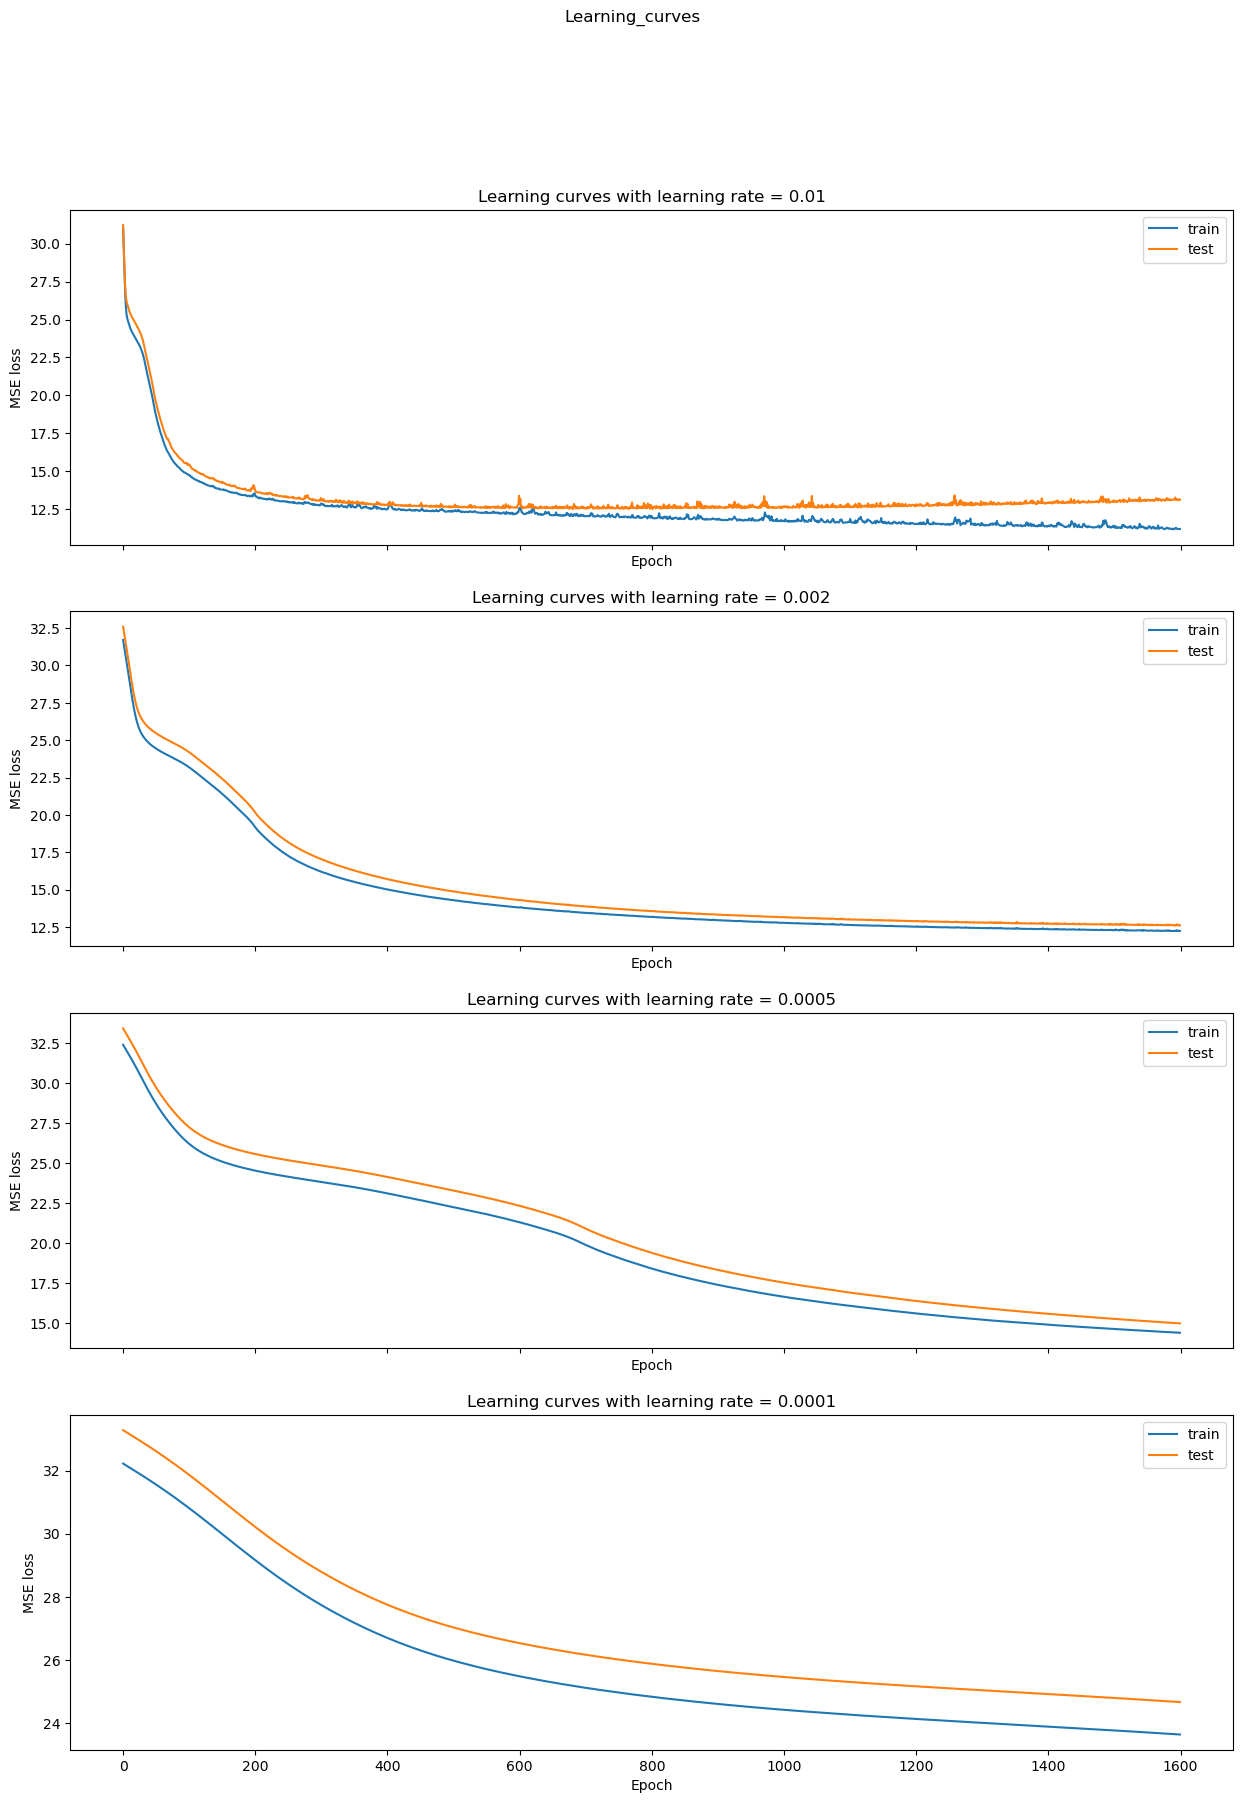

In [17]:
# training with the train dataset for different values of learning rate (0.01, 0.002, 0.0005, 0.0001)
learning_rates= [0.01, 0.002, 0.0005, 0.0001]  
epochs = 1600         
batch_size = 8000      
num_percept_layer1=20  
num_percept_layer2=10 

tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2)


With this architecture, it seems from the above plots that the learning rate could be higher than 0.001 and taken to be 0.01. One would then need only 400 epochs to train the model! Let's look if there is an even better value by training the model for values of the learning rate around 0.01 (if needed, scroll down the output cell to view the plots):

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                280       
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
4/4 [==============================] - 1s 135ms/step - loss: 32.1607 - mae: 2.4767 - val_loss: 32.8034 - val_mae: 2.3925
Epoch 2/600
4/4 [==============================] - 0s 63ms/step - loss: 31.5010 - mae: 2.3420 - val_loss: 32.1618 - val_mae: 2.2616
Epoch 3/600
4/4 [==============================] - 0s 5

4/4 [==============================] - 0s 67ms/step - loss: 16.6838 - mae: 1.6436 - val_loss: 17.4965 - val_mae: 1.6541
Epoch 118/600
4/4 [==============================] - 0s 65ms/step - loss: 16.6392 - mae: 1.6310 - val_loss: 17.4442 - val_mae: 1.6425
Epoch 119/600
4/4 [==============================] - 0s 55ms/step - loss: 16.6015 - mae: 1.6398 - val_loss: 17.4137 - val_mae: 1.6520
Epoch 120/600
4/4 [==============================] - 0s 65ms/step - loss: 16.5517 - mae: 1.6299 - val_loss: 17.3627 - val_mae: 1.6371
Epoch 121/600
4/4 [==============================] - 0s 65ms/step - loss: 16.5282 - mae: 1.6353 - val_loss: 17.3369 - val_mae: 1.6543
Epoch 122/600
4/4 [==============================] - 0s 56ms/step - loss: 16.4739 - mae: 1.6298 - val_loss: 17.2775 - val_mae: 1.6324
Epoch 123/600
4/4 [==============================] - 0s 55ms/step - loss: 16.4343 - mae: 1.6209 - val_loss: 17.2527 - val_mae: 1.6479
Epoch 124/600
4/4 [==============================] - 0s 68ms/step - loss: 16

4/4 [==============================] - 0s 70ms/step - loss: 14.1444 - mae: 1.5196 - val_loss: 14.6768 - val_mae: 1.5314
Epoch 240/600
4/4 [==============================] - 0s 80ms/step - loss: 14.1317 - mae: 1.5201 - val_loss: 14.6528 - val_mae: 1.5228
Epoch 241/600
4/4 [==============================] - 0s 70ms/step - loss: 14.1473 - mae: 1.5089 - val_loss: 14.6726 - val_mae: 1.5279
Epoch 242/600
4/4 [==============================] - 0s 92ms/step - loss: 14.1244 - mae: 1.5220 - val_loss: 14.6434 - val_mae: 1.5225
Epoch 243/600
4/4 [==============================] - 0s 67ms/step - loss: 14.1040 - mae: 1.5077 - val_loss: 14.6265 - val_mae: 1.5133
Epoch 244/600
4/4 [==============================] - 0s 64ms/step - loss: 14.1106 - mae: 1.5162 - val_loss: 14.6295 - val_mae: 1.5288
Epoch 245/600
4/4 [==============================] - 0s 81ms/step - loss: 14.0843 - mae: 1.5092 - val_loss: 14.6042 - val_mae: 1.5108
Epoch 246/600
4/4 [==============================] - 0s 83ms/step - loss: 14

4/4 [==============================] - 0s 67ms/step - loss: 13.3210 - mae: 1.4770 - val_loss: 13.6869 - val_mae: 1.4914
Epoch 362/600
4/4 [==============================] - 0s 101ms/step - loss: 13.3201 - mae: 1.4859 - val_loss: 13.6758 - val_mae: 1.4797
Epoch 363/600
4/4 [==============================] - 0s 76ms/step - loss: 13.3104 - mae: 1.4738 - val_loss: 13.6867 - val_mae: 1.4776
Epoch 364/600
4/4 [==============================] - 0s 70ms/step - loss: 13.3032 - mae: 1.4720 - val_loss: 13.6875 - val_mae: 1.4749
Epoch 365/600
4/4 [==============================] - 0s 66ms/step - loss: 13.2986 - mae: 1.4706 - val_loss: 13.6702 - val_mae: 1.4772
Epoch 366/600
4/4 [==============================] - 0s 61ms/step - loss: 13.3040 - mae: 1.4776 - val_loss: 13.6661 - val_mae: 1.4895
Epoch 367/600
4/4 [==============================] - 0s 63ms/step - loss: 13.2949 - mae: 1.4820 - val_loss: 13.6637 - val_mae: 1.4718
Epoch 368/600
4/4 [==============================] - 0s 67ms/step - loss: 1

4/4 [==============================] - 0s 82ms/step - loss: 12.8828 - mae: 1.4594 - val_loss: 13.2310 - val_mae: 1.4572
Epoch 484/600
4/4 [==============================] - 0s 81ms/step - loss: 12.8774 - mae: 1.4637 - val_loss: 13.2142 - val_mae: 1.4718
Epoch 485/600
4/4 [==============================] - 0s 82ms/step - loss: 12.8624 - mae: 1.4603 - val_loss: 13.2248 - val_mae: 1.4541
Epoch 486/600
4/4 [==============================] - 0s 77ms/step - loss: 12.8718 - mae: 1.4513 - val_loss: 13.1993 - val_mae: 1.4720
Epoch 487/600
4/4 [==============================] - 0s 84ms/step - loss: 12.8913 - mae: 1.4698 - val_loss: 13.2022 - val_mae: 1.4620
Epoch 488/600
4/4 [==============================] - 0s 78ms/step - loss: 12.8600 - mae: 1.4578 - val_loss: 13.1952 - val_mae: 1.4630
Epoch 489/600
4/4 [==============================] - 0s 50ms/step - loss: 12.8527 - mae: 1.4607 - val_loss: 13.2031 - val_mae: 1.4630
Epoch 490/600
4/4 [==============================] - 0s 77ms/step - loss: 12

Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/600
4/4 [==============================] - 1s 129ms/step - loss: 32.0889 - mae: 2.4625 - val_loss: 32.2574 - val_mae: 2.2817
Epoch 2/600
4/4 [==============================] - 0s 36ms/step - loss: 30.7069 - mae: 2.1942 - val_loss: 30.9256 - val_mae: 2.0736
Epoch 3/600
4/4 [==============================] - 0s 78ms/step - loss: 29.3907 - mae: 2.0270 - val_loss: 29.6556 - val_mae: 1.9747
Epoch 4/600
4/4 [==============================] - 0s 81ms/step - loss: 28.1677 - mae: 1.9596 - val_loss: 28.5153 - val_mae: 1.9617
Epoch 5/600
4/4 [==============================] - 0s 61ms/step - loss: 27.1073 - mae: 1.9716 - val_loss: 27.5894 - val_mae: 2.0133
Epoch 6/600
4/4 [==============================] - 0s 64ms/step - loss: 26.2781 - mae: 2.0377 - val_loss: 26.9216 - val_mae: 2.1036
Epoch 7/600
4/4 [==============================] - 0s 86ms/step - loss: 25.68

4/4 [==============================] - 0s 76ms/step - loss: 14.4274 - mae: 1.4993 - val_loss: 14.9651 - val_mae: 1.5146
Epoch 123/600
4/4 [==============================] - 0s 69ms/step - loss: 14.3630 - mae: 1.5036 - val_loss: 14.9314 - val_mae: 1.5057
Epoch 124/600
4/4 [==============================] - 0s 59ms/step - loss: 14.3572 - mae: 1.5051 - val_loss: 14.9417 - val_mae: 1.5390
Epoch 125/600
4/4 [==============================] - 0s 68ms/step - loss: 14.3435 - mae: 1.5107 - val_loss: 14.8824 - val_mae: 1.5126
Epoch 126/600
4/4 [==============================] - 0s 71ms/step - loss: 14.3434 - mae: 1.5120 - val_loss: 14.8836 - val_mae: 1.4895
Epoch 127/600
4/4 [==============================] - 0s 62ms/step - loss: 14.3017 - mae: 1.4903 - val_loss: 14.8696 - val_mae: 1.5372
Epoch 128/600
4/4 [==============================] - 0s 82ms/step - loss: 14.2852 - mae: 1.5301 - val_loss: 14.9368 - val_mae: 1.4850
Epoch 129/600
4/4 [==============================] - 0s 84ms/step - loss: 14

4/4 [==============================] - 0s 72ms/step - loss: 13.1039 - mae: 1.4697 - val_loss: 13.4078 - val_mae: 1.4868
Epoch 245/600
4/4 [==============================] - 0s 67ms/step - loss: 13.0862 - mae: 1.4780 - val_loss: 13.3842 - val_mae: 1.4536
Epoch 246/600
4/4 [==============================] - 0s 75ms/step - loss: 13.1000 - mae: 1.4420 - val_loss: 13.4138 - val_mae: 1.4750
Epoch 247/600
4/4 [==============================] - 0s 71ms/step - loss: 13.1012 - mae: 1.4715 - val_loss: 13.4199 - val_mae: 1.4556
Epoch 248/600
4/4 [==============================] - 0s 62ms/step - loss: 13.1146 - mae: 1.4698 - val_loss: 13.3776 - val_mae: 1.4735
Epoch 249/600
4/4 [==============================] - 0s 66ms/step - loss: 13.0724 - mae: 1.4518 - val_loss: 13.3791 - val_mae: 1.4596
Epoch 250/600
4/4 [==============================] - 0s 70ms/step - loss: 13.1425 - mae: 1.4883 - val_loss: 13.3822 - val_mae: 1.4548
Epoch 251/600
4/4 [==============================] - 0s 73ms/step - loss: 13

4/4 [==============================] - 0s 76ms/step - loss: 12.6309 - mae: 1.4621 - val_loss: 12.9011 - val_mae: 1.4506
Epoch 367/600
4/4 [==============================] - 0s 85ms/step - loss: 12.6132 - mae: 1.4470 - val_loss: 12.9316 - val_mae: 1.4268
Epoch 368/600
4/4 [==============================] - 0s 83ms/step - loss: 12.6291 - mae: 1.4361 - val_loss: 12.8840 - val_mae: 1.4457
Epoch 369/600
4/4 [==============================] - 0s 67ms/step - loss: 12.6060 - mae: 1.4564 - val_loss: 12.9209 - val_mae: 1.4514
Epoch 370/600
4/4 [==============================] - 0s 71ms/step - loss: 12.6055 - mae: 1.4560 - val_loss: 12.8942 - val_mae: 1.4603
Epoch 371/600
4/4 [==============================] - 0s 80ms/step - loss: 12.5967 - mae: 1.4508 - val_loss: 12.8775 - val_mae: 1.4460
Epoch 372/600
4/4 [==============================] - 0s 70ms/step - loss: 12.6281 - mae: 1.4490 - val_loss: 12.9187 - val_mae: 1.4266
Epoch 373/600
4/4 [==============================] - 0s 66ms/step - loss: 12

4/4 [==============================] - 0s 94ms/step - loss: 12.4103 - mae: 1.4395 - val_loss: 12.6615 - val_mae: 1.4551
Epoch 489/600
4/4 [==============================] - 0s 137ms/step - loss: 12.4266 - mae: 1.4565 - val_loss: 12.7833 - val_mae: 1.4149
Epoch 490/600
4/4 [==============================] - 0s 85ms/step - loss: 12.4147 - mae: 1.4167 - val_loss: 12.6885 - val_mae: 1.4358
Epoch 491/600
4/4 [==============================] - 0s 109ms/step - loss: 12.3975 - mae: 1.4623 - val_loss: 12.6964 - val_mae: 1.4528
Epoch 492/600
4/4 [==============================] - 0s 79ms/step - loss: 12.3861 - mae: 1.4378 - val_loss: 12.6886 - val_mae: 1.4357
Epoch 493/600
4/4 [==============================] - 0s 97ms/step - loss: 12.4784 - mae: 1.4504 - val_loss: 12.7627 - val_mae: 1.4143
Epoch 494/600
4/4 [==============================] - 0s 91ms/step - loss: 12.3929 - mae: 1.4227 - val_loss: 12.7091 - val_mae: 1.4424
Epoch 495/600
4/4 [==============================] - 0s 77ms/step - loss: 

4/4 [==============================] - 0s 129ms/step - loss: 26.0919 - mae: 2.1168 - val_loss: 26.7497 - val_mae: 2.2428
Epoch 5/600
4/4 [==============================] - 0s 87ms/step - loss: 25.5520 - mae: 2.2985 - val_loss: 26.3841 - val_mae: 2.4006
Epoch 6/600
4/4 [==============================] - 0s 88ms/step - loss: 25.2220 - mae: 2.4321 - val_loss: 26.1267 - val_mae: 2.4831
Epoch 7/600
4/4 [==============================] - 0s 86ms/step - loss: 24.9920 - mae: 2.4906 - val_loss: 25.8628 - val_mae: 2.4942
Epoch 8/600
4/4 [==============================] - 0s 126ms/step - loss: 24.7173 - mae: 2.4784 - val_loss: 25.5838 - val_mae: 2.4466
Epoch 9/600
4/4 [==============================] - 0s 93ms/step - loss: 24.4534 - mae: 2.4194 - val_loss: 25.3363 - val_mae: 2.3719
Epoch 10/600
4/4 [==============================] - 0s 106ms/step - loss: 24.2275 - mae: 2.3428 - val_loss: 25.1410 - val_mae: 2.2959
Epoch 11/600
4/4 [==============================] - 0s 64ms/step - loss: 24.0543 - m

Epoch 66/600
4/4 [==============================] - 0s 109ms/step - loss: 14.6540 - mae: 1.5231 - val_loss: 15.2483 - val_mae: 1.5295
Epoch 67/600
4/4 [==============================] - 0s 61ms/step - loss: 14.6085 - mae: 1.5144 - val_loss: 15.2041 - val_mae: 1.5021
Epoch 68/600
4/4 [==============================] - 0s 69ms/step - loss: 14.5987 - mae: 1.5186 - val_loss: 15.1362 - val_mae: 1.5220
Epoch 69/600
4/4 [==============================] - 0s 83ms/step - loss: 14.5081 - mae: 1.5037 - val_loss: 15.0849 - val_mae: 1.5148
Epoch 70/600
4/4 [==============================] - 0s 91ms/step - loss: 14.4678 - mae: 1.5113 - val_loss: 15.0632 - val_mae: 1.5273
Epoch 71/600
4/4 [==============================] - 0s 70ms/step - loss: 14.4409 - mae: 1.5022 - val_loss: 15.0060 - val_mae: 1.5067
Epoch 72/600
4/4 [==============================] - 0s 59ms/step - loss: 14.3868 - mae: 1.5171 - val_loss: 14.9554 - val_mae: 1.5241
Epoch 73/600
4/4 [==============================] - 0s 69ms/step - l

4/4 [==============================] - 0s 68ms/step - loss: 12.8676 - mae: 1.4449 - val_loss: 13.1199 - val_mae: 1.4822
Epoch 189/600
4/4 [==============================] - 0s 67ms/step - loss: 12.7875 - mae: 1.4528 - val_loss: 13.4975 - val_mae: 1.3978
Epoch 190/600
4/4 [==============================] - 0s 50ms/step - loss: 12.9694 - mae: 1.4435 - val_loss: 13.1650 - val_mae: 1.5226
Epoch 191/600
4/4 [==============================] - 0s 63ms/step - loss: 12.8447 - mae: 1.4645 - val_loss: 13.0519 - val_mae: 1.4362
Epoch 192/600
4/4 [==============================] - 0s 59ms/step - loss: 12.7325 - mae: 1.4438 - val_loss: 13.0012 - val_mae: 1.4460
Epoch 193/600
4/4 [==============================] - 0s 65ms/step - loss: 12.7074 - mae: 1.4436 - val_loss: 13.0187 - val_mae: 1.4475
Epoch 194/600
4/4 [==============================] - 0s 85ms/step - loss: 12.6965 - mae: 1.4449 - val_loss: 13.0434 - val_mae: 1.4448
Epoch 195/600
4/4 [==============================] - 0s 66ms/step - loss: 12

4/4 [==============================] - 0s 74ms/step - loss: 12.3549 - mae: 1.4393 - val_loss: 12.6536 - val_mae: 1.4300
Epoch 311/600
4/4 [==============================] - 0s 63ms/step - loss: 12.3493 - mae: 1.4192 - val_loss: 12.6738 - val_mae: 1.4484
Epoch 312/600
4/4 [==============================] - 0s 71ms/step - loss: 12.4024 - mae: 1.4580 - val_loss: 13.0422 - val_mae: 1.4169
Epoch 313/600
4/4 [==============================] - 0s 75ms/step - loss: 12.4659 - mae: 1.4319 - val_loss: 12.7979 - val_mae: 1.4939
Epoch 314/600
4/4 [==============================] - 0s 62ms/step - loss: 12.4801 - mae: 1.4551 - val_loss: 13.0438 - val_mae: 1.3952
Epoch 315/600
4/4 [==============================] - 0s 51ms/step - loss: 12.4921 - mae: 1.4280 - val_loss: 12.7391 - val_mae: 1.4764
Epoch 316/600
4/4 [==============================] - 0s 72ms/step - loss: 12.3661 - mae: 1.4435 - val_loss: 12.9551 - val_mae: 1.4338
Epoch 317/600
4/4 [==============================] - 0s 65ms/step - loss: 12

4/4 [==============================] - 0s 61ms/step - loss: 12.0508 - mae: 1.4400 - val_loss: 12.5538 - val_mae: 1.4258
Epoch 433/600
4/4 [==============================] - 0s 70ms/step - loss: 12.0736 - mae: 1.4100 - val_loss: 12.6118 - val_mae: 1.4585
Epoch 434/600
4/4 [==============================] - 0s 59ms/step - loss: 12.0883 - mae: 1.4554 - val_loss: 12.6565 - val_mae: 1.4159
Epoch 435/600
4/4 [==============================] - 0s 74ms/step - loss: 12.0482 - mae: 1.4164 - val_loss: 12.5792 - val_mae: 1.4711
Epoch 436/600
4/4 [==============================] - 0s 80ms/step - loss: 12.1554 - mae: 1.4492 - val_loss: 12.6856 - val_mae: 1.4299
Epoch 437/600
4/4 [==============================] - 0s 63ms/step - loss: 12.0752 - mae: 1.4375 - val_loss: 12.5724 - val_mae: 1.4104
Epoch 438/600
4/4 [==============================] - 0s 82ms/step - loss: 12.0841 - mae: 1.4009 - val_loss: 12.5548 - val_mae: 1.4584
Epoch 439/600
4/4 [==============================] - 0s 91ms/step - loss: 12

4/4 [==============================] - 0s 50ms/step - loss: 11.8581 - mae: 1.4132 - val_loss: 12.5461 - val_mae: 1.4735
Epoch 555/600
4/4 [==============================] - 0s 54ms/step - loss: 11.9650 - mae: 1.4231 - val_loss: 12.5350 - val_mae: 1.4274
Epoch 556/600
4/4 [==============================] - 0s 51ms/step - loss: 11.6992 - mae: 1.4441 - val_loss: 12.4269 - val_mae: 1.4303
Epoch 557/600
4/4 [==============================] - 0s 64ms/step - loss: 11.7957 - mae: 1.4064 - val_loss: 12.4125 - val_mae: 1.4381
Epoch 558/600
4/4 [==============================] - 0s 52ms/step - loss: 11.7397 - mae: 1.4290 - val_loss: 12.5510 - val_mae: 1.4204
Epoch 559/600
4/4 [==============================] - 0s 61ms/step - loss: 11.7222 - mae: 1.4117 - val_loss: 12.6399 - val_mae: 1.4686
Epoch 560/600
4/4 [==============================] - 0s 75ms/step - loss: 11.8615 - mae: 1.4363 - val_loss: 12.6148 - val_mae: 1.4248
Epoch 561/600
4/4 [==============================] - 0s 39ms/step - loss: 11

Epoch 71/600
4/4 [==============================] - 0s 67ms/step - loss: 13.2955 - mae: 1.4546 - val_loss: 13.7430 - val_mae: 1.5588
Epoch 72/600
4/4 [==============================] - 0s 62ms/step - loss: 13.4206 - mae: 1.4848 - val_loss: 13.7440 - val_mae: 1.4455
Epoch 73/600
4/4 [==============================] - 0s 70ms/step - loss: 13.2005 - mae: 1.5112 - val_loss: 13.3244 - val_mae: 1.4431
Epoch 74/600
4/4 [==============================] - 0s 63ms/step - loss: 13.1933 - mae: 1.4410 - val_loss: 13.3541 - val_mae: 1.4266
Epoch 75/600
4/4 [==============================] - 0s 62ms/step - loss: 13.2594 - mae: 1.5025 - val_loss: 13.4470 - val_mae: 1.5375
Epoch 76/600
4/4 [==============================] - 0s 55ms/step - loss: 13.0395 - mae: 1.4709 - val_loss: 13.3282 - val_mae: 1.4534
Epoch 77/600
4/4 [==============================] - 0s 56ms/step - loss: 13.2150 - mae: 1.4673 - val_loss: 14.0139 - val_mae: 1.4461
Epoch 78/600
4/4 [==============================] - 0s 55ms/step - lo

4/4 [==============================] - 0s 63ms/step - loss: 12.1959 - mae: 1.4211 - val_loss: 12.6896 - val_mae: 1.4526
Epoch 194/600
4/4 [==============================] - 0s 68ms/step - loss: 12.1964 - mae: 1.4388 - val_loss: 13.5112 - val_mae: 1.4121
Epoch 195/600
4/4 [==============================] - 0s 81ms/step - loss: 12.2458 - mae: 1.4645 - val_loss: 12.6648 - val_mae: 1.4554
Epoch 196/600
4/4 [==============================] - 0s 77ms/step - loss: 12.3569 - mae: 1.4128 - val_loss: 12.9031 - val_mae: 1.3911
Epoch 197/600
4/4 [==============================] - 0s 82ms/step - loss: 12.2021 - mae: 1.4610 - val_loss: 12.8344 - val_mae: 1.4569
Epoch 198/600
4/4 [==============================] - 0s 82ms/step - loss: 12.1990 - mae: 1.4249 - val_loss: 12.6260 - val_mae: 1.4357
Epoch 199/600
4/4 [==============================] - 0s 82ms/step - loss: 12.1367 - mae: 1.4266 - val_loss: 12.7375 - val_mae: 1.4637
Epoch 200/600
4/4 [==============================] - 0s 71ms/step - loss: 12

4/4 [==============================] - 0s 77ms/step - loss: 11.8633 - mae: 1.4228 - val_loss: 12.9165 - val_mae: 1.4033
Epoch 316/600
4/4 [==============================] - 0s 56ms/step - loss: 12.0468 - mae: 1.4505 - val_loss: 13.0162 - val_mae: 1.4213
Epoch 317/600
4/4 [==============================] - 0s 64ms/step - loss: 11.8517 - mae: 1.4136 - val_loss: 12.8318 - val_mae: 1.4700
Epoch 318/600
4/4 [==============================] - 0s 60ms/step - loss: 12.0022 - mae: 1.4095 - val_loss: 12.7870 - val_mae: 1.4287
Epoch 319/600
4/4 [==============================] - 0s 75ms/step - loss: 12.0337 - mae: 1.4823 - val_loss: 13.2025 - val_mae: 1.4022
Epoch 320/600
4/4 [==============================] - 0s 63ms/step - loss: 12.0629 - mae: 1.3958 - val_loss: 12.8447 - val_mae: 1.4637
Epoch 321/600
4/4 [==============================] - 0s 77ms/step - loss: 11.6844 - mae: 1.4342 - val_loss: 13.0384 - val_mae: 1.4252
Epoch 322/600
4/4 [==============================] - 0s 65ms/step - loss: 11

4/4 [==============================] - 0s 31ms/step - loss: 11.5134 - mae: 1.4137 - val_loss: 13.0913 - val_mae: 1.4036
Epoch 438/600
4/4 [==============================] - 0s 66ms/step - loss: 11.6068 - mae: 1.4254 - val_loss: 12.7531 - val_mae: 1.4401
Epoch 439/600
4/4 [==============================] - 0s 58ms/step - loss: 11.5662 - mae: 1.4051 - val_loss: 12.8247 - val_mae: 1.4826
Epoch 440/600
4/4 [==============================] - 0s 76ms/step - loss: 11.3581 - mae: 1.4304 - val_loss: 12.7949 - val_mae: 1.4263
Epoch 441/600
4/4 [==============================] - 0s 74ms/step - loss: 11.6643 - mae: 1.4017 - val_loss: 13.0461 - val_mae: 1.4118
Epoch 442/600
4/4 [==============================] - 0s 60ms/step - loss: 11.7186 - mae: 1.4557 - val_loss: 13.2196 - val_mae: 1.4114
Epoch 443/600
4/4 [==============================] - 0s 67ms/step - loss: 11.9644 - mae: 1.4032 - val_loss: 13.1562 - val_mae: 1.5104
Epoch 444/600
4/4 [==============================] - 0s 63ms/step - loss: 11

4/4 [==============================] - 0s 60ms/step - loss: 11.3455 - mae: 1.3829 - val_loss: 13.2283 - val_mae: 1.4898
Epoch 560/600
4/4 [==============================] - 0s 50ms/step - loss: 11.1469 - mae: 1.4334 - val_loss: 13.2435 - val_mae: 1.4139
Epoch 561/600
4/4 [==============================] - 0s 47ms/step - loss: 11.2994 - mae: 1.4043 - val_loss: 13.2064 - val_mae: 1.4474
Epoch 562/600
4/4 [==============================] - 0s 70ms/step - loss: 11.0334 - mae: 1.3991 - val_loss: 12.8842 - val_mae: 1.4354
Epoch 563/600
4/4 [==============================] - 0s 65ms/step - loss: 11.0102 - mae: 1.4180 - val_loss: 12.9227 - val_mae: 1.4367
Epoch 564/600
4/4 [==============================] - 0s 49ms/step - loss: 11.0947 - mae: 1.3838 - val_loss: 13.3961 - val_mae: 1.4937
Epoch 565/600
4/4 [==============================] - 0s 74ms/step - loss: 11.1111 - mae: 1.4302 - val_loss: 13.1426 - val_mae: 1.4194
Epoch 566/600
4/4 [==============================] - 0s 71ms/step - loss: 10

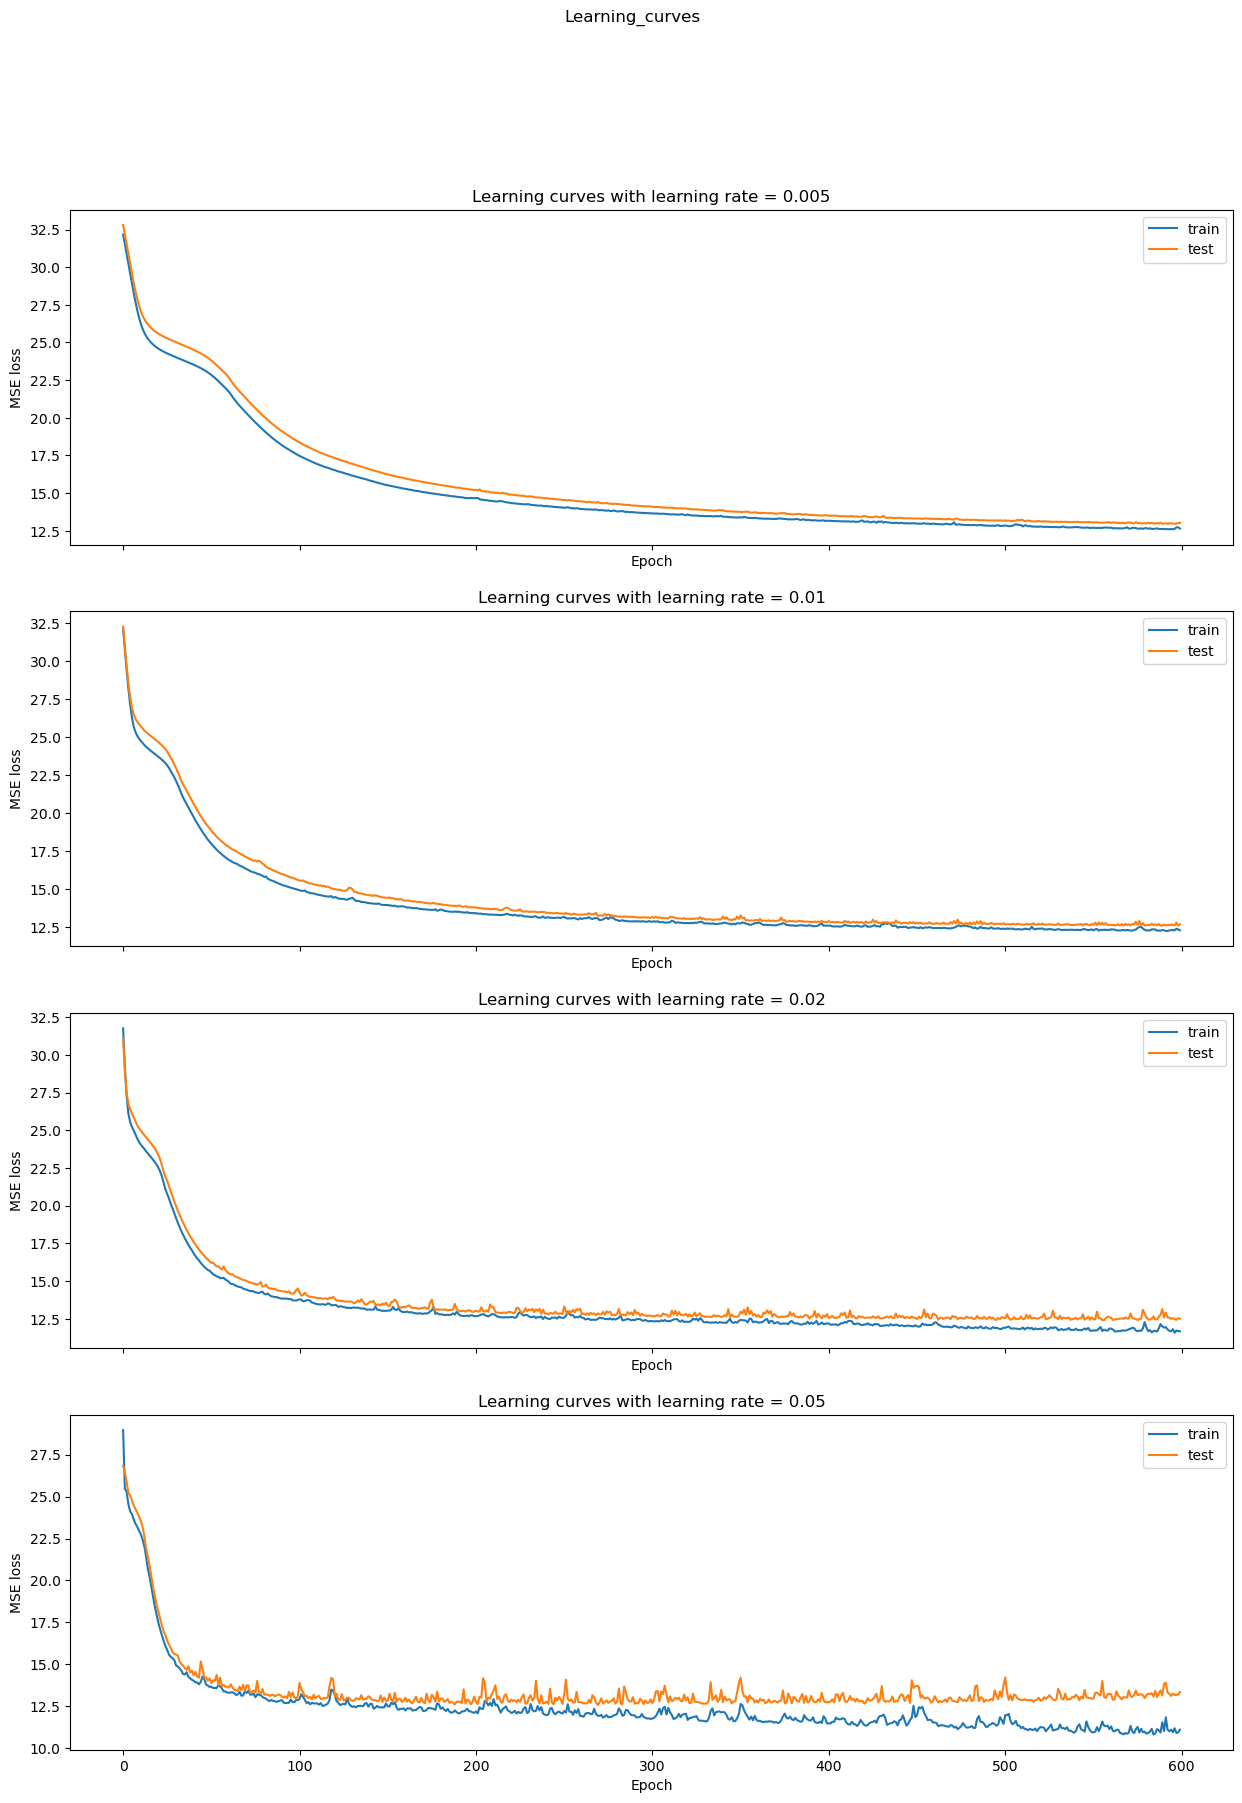

In [18]:
# training with the train dataset for different values of learning rate (0.005, 0.01, 0.02, 0.05)
learning_rates= [0.005, 0.01, 0.02, 0.05]  
epochs = 600         
batch_size = 8000      
num_percept_layer1=20  
num_percept_layer2=10 

tuning_lr(learning_rates, num_percept_layer1, num_percept_layer2)


It can be seen here that, with this architecture, an optimal learning rate is around 0.02 with around 300 epochs.

## Tuning the number of perceptrons

Until now, the numbers of perceptrons were 20 in the first layer and 10 in the second layer. Turn now to the tuning of the architecture of the neural network, using the values proposed above for each layer.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 40)                560       
                                                                 
 dense_28 (Dense)            (None, 10)                410       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1600
4/4 [==============================] - 1s 107ms/step - loss: 32.0794 - mae: 2.4603 - val_loss: 33.0537 - val_mae: 2.4437
Epoch 2/1600
4/4 [==============================] - 0s 72ms/step - loss: 31.9353 - mae: 2.4312 - val_loss: 32.9117 - val_mae: 2.4150
Epoch 3/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 72ms/step - loss: 24.1509 - mae: 2.1734 - val_loss: 25.1780 - val_mae: 2.1757
Epoch 118/1600
4/4 [==============================] - 0s 62ms/step - loss: 24.1352 - mae: 2.1740 - val_loss: 25.1625 - val_mae: 2.1761
Epoch 119/1600
4/4 [==============================] - 0s 48ms/step - loss: 24.1201 - mae: 2.1745 - val_loss: 25.1469 - val_mae: 2.1766
Epoch 120/1600
4/4 [==============================] - 0s 74ms/step - loss: 24.1046 - mae: 2.1749 - val_loss: 25.1316 - val_mae: 2.1770
Epoch 121/1600
4/4 [==============================] - 0s 69ms/step - loss: 24.0898 - mae: 2.1755 - val_loss: 25.1163 - val_mae: 2.1776
Epoch 122/1600
4/4 [==============================] - 0s 44ms/step - loss: 24.0746 - mae: 2.1759 - val_loss: 25.1011 - val_mae: 2.1780
Epoch 123/1600
4/4 [==============================] - 0s 72ms/step - loss: 24.0599 - mae: 2.1765 - val_loss: 25.0860 - val_mae: 2.1785
Epoch 124/1600
4/4 [==============================] - 0s 76ms/step - l

Epoch 178/1600
4/4 [==============================] - 0s 58ms/step - loss: 23.2100 - mae: 2.1468 - val_loss: 24.2287 - val_mae: 2.1477
Epoch 179/1600
4/4 [==============================] - 0s 61ms/step - loss: 23.1903 - mae: 2.1452 - val_loss: 24.2089 - val_mae: 2.1461
Epoch 180/1600
4/4 [==============================] - 0s 63ms/step - loss: 23.1701 - mae: 2.1434 - val_loss: 24.1889 - val_mae: 2.1442
Epoch 181/1600
4/4 [==============================] - 0s 68ms/step - loss: 23.1497 - mae: 2.1416 - val_loss: 24.1687 - val_mae: 2.1425
Epoch 182/1600
4/4 [==============================] - 0s 69ms/step - loss: 23.1292 - mae: 2.1400 - val_loss: 24.1481 - val_mae: 2.1409
Epoch 183/1600
4/4 [==============================] - 0s 54ms/step - loss: 23.1082 - mae: 2.1381 - val_loss: 24.1273 - val_mae: 2.1388
Epoch 184/1600
4/4 [==============================] - 0s 59ms/step - loss: 23.0874 - mae: 2.1363 - val_loss: 24.1061 - val_mae: 2.1372
Epoch 185/1600
4/4 [==============================] - 0

Epoch 239/1600
4/4 [==============================] - 0s 63ms/step - loss: 21.6022 - mae: 1.9220 - val_loss: 22.6140 - val_mae: 1.9243
Epoch 240/1600
4/4 [==============================] - 0s 58ms/step - loss: 21.5585 - mae: 1.9119 - val_loss: 22.5711 - val_mae: 1.9139
Epoch 241/1600
4/4 [==============================] - 0s 68ms/step - loss: 21.5158 - mae: 1.9011 - val_loss: 22.5281 - val_mae: 1.9026
Epoch 242/1600
4/4 [==============================] - 0s 62ms/step - loss: 21.4723 - mae: 1.8897 - val_loss: 22.4858 - val_mae: 1.8918
Epoch 243/1600
4/4 [==============================] - 0s 56ms/step - loss: 21.4307 - mae: 1.8792 - val_loss: 22.4435 - val_mae: 1.8821
Epoch 244/1600
4/4 [==============================] - 0s 73ms/step - loss: 21.3881 - mae: 1.8691 - val_loss: 22.4022 - val_mae: 1.8720
Epoch 245/1600
4/4 [==============================] - 0s 61ms/step - loss: 21.3472 - mae: 1.8597 - val_loss: 22.3615 - val_mae: 1.8639
Epoch 246/1600
4/4 [==============================] - 0

Epoch 300/1600
4/4 [==============================] - 0s 56ms/step - loss: 19.6935 - mae: 1.7179 - val_loss: 20.7060 - val_mae: 1.7326
Epoch 301/1600
4/4 [==============================] - 0s 58ms/step - loss: 19.6674 - mae: 1.7171 - val_loss: 20.6800 - val_mae: 1.7321
Epoch 302/1600
4/4 [==============================] - 0s 63ms/step - loss: 19.6412 - mae: 1.7167 - val_loss: 20.6539 - val_mae: 1.7316
Epoch 303/1600
4/4 [==============================] - 0s 70ms/step - loss: 19.6154 - mae: 1.7161 - val_loss: 20.6280 - val_mae: 1.7308
Epoch 304/1600
4/4 [==============================] - 0s 70ms/step - loss: 19.5899 - mae: 1.7142 - val_loss: 20.6018 - val_mae: 1.7280
Epoch 305/1600
4/4 [==============================] - 0s 83ms/step - loss: 19.5653 - mae: 1.7123 - val_loss: 20.5752 - val_mae: 1.7273
Epoch 306/1600
4/4 [==============================] - 0s 74ms/step - loss: 19.5383 - mae: 1.7110 - val_loss: 20.5493 - val_mae: 1.7255
Epoch 307/1600
4/4 [==============================] - 0

Epoch 361/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.2305 - mae: 1.6324 - val_loss: 19.2035 - val_mae: 1.6465
Epoch 362/1600
4/4 [==============================] - 0s 70ms/step - loss: 18.2099 - mae: 1.6301 - val_loss: 19.1825 - val_mae: 1.6447
Epoch 363/1600
4/4 [==============================] - 0s 57ms/step - loss: 18.1902 - mae: 1.6281 - val_loss: 19.1614 - val_mae: 1.6431
Epoch 364/1600
4/4 [==============================] - 0s 63ms/step - loss: 18.1715 - mae: 1.6290 - val_loss: 19.1424 - val_mae: 1.6455
Epoch 365/1600
4/4 [==============================] - 0s 78ms/step - loss: 18.1502 - mae: 1.6291 - val_loss: 19.1203 - val_mae: 1.6430
Epoch 366/1600
4/4 [==============================] - 0s 66ms/step - loss: 18.1298 - mae: 1.6254 - val_loss: 19.0994 - val_mae: 1.6383
Epoch 367/1600
4/4 [==============================] - 0s 55ms/step - loss: 18.1110 - mae: 1.6222 - val_loss: 19.0790 - val_mae: 1.6381
Epoch 368/1600
4/4 [==============================] - 0

Epoch 422/1600
4/4 [==============================] - 0s 58ms/step - loss: 17.2128 - mae: 1.5861 - val_loss: 18.1406 - val_mae: 1.6015
Epoch 423/1600
4/4 [==============================] - 0s 76ms/step - loss: 17.1985 - mae: 1.5862 - val_loss: 18.1266 - val_mae: 1.6025
Epoch 424/1600
4/4 [==============================] - 0s 64ms/step - loss: 17.1838 - mae: 1.5876 - val_loss: 18.1124 - val_mae: 1.6033
Epoch 425/1600
4/4 [==============================] - 0s 72ms/step - loss: 17.1704 - mae: 1.5874 - val_loss: 18.0960 - val_mae: 1.6013
Epoch 426/1600
4/4 [==============================] - 0s 60ms/step - loss: 17.1568 - mae: 1.5864 - val_loss: 18.0809 - val_mae: 1.6009
Epoch 427/1600
4/4 [==============================] - 0s 67ms/step - loss: 17.1421 - mae: 1.5857 - val_loss: 18.0664 - val_mae: 1.5999
Epoch 428/1600
4/4 [==============================] - 0s 53ms/step - loss: 17.1282 - mae: 1.5839 - val_loss: 18.0521 - val_mae: 1.5986
Epoch 429/1600
4/4 [==============================] - 0

Epoch 483/1600
4/4 [==============================] - 0s 82ms/step - loss: 16.4679 - mae: 1.5579 - val_loss: 17.3524 - val_mae: 1.5735
Epoch 484/1600
4/4 [==============================] - 0s 64ms/step - loss: 16.4570 - mae: 1.5588 - val_loss: 17.3426 - val_mae: 1.5739
Epoch 485/1600
4/4 [==============================] - 0s 71ms/step - loss: 16.4475 - mae: 1.5595 - val_loss: 17.3317 - val_mae: 1.5739
Epoch 486/1600
4/4 [==============================] - 0s 67ms/step - loss: 16.4377 - mae: 1.5583 - val_loss: 17.3187 - val_mae: 1.5710
Epoch 487/1600
4/4 [==============================] - 0s 90ms/step - loss: 16.4274 - mae: 1.5575 - val_loss: 17.3101 - val_mae: 1.5729
Epoch 488/1600
4/4 [==============================] - 0s 68ms/step - loss: 16.4178 - mae: 1.5581 - val_loss: 17.2982 - val_mae: 1.5717
Epoch 489/1600
4/4 [==============================] - 0s 76ms/step - loss: 16.4075 - mae: 1.5580 - val_loss: 17.2875 - val_mae: 1.5726
Epoch 490/1600
4/4 [==============================] - 0

Epoch 604/1600
4/4 [==============================] - 0s 82ms/step - loss: 15.5176 - mae: 1.5360 - val_loss: 16.3080 - val_mae: 1.5493
Epoch 605/1600
4/4 [==============================] - 0s 64ms/step - loss: 15.5108 - mae: 1.5329 - val_loss: 16.2976 - val_mae: 1.5451
Epoch 606/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.5030 - mae: 1.5329 - val_loss: 16.2925 - val_mae: 1.5486
Epoch 607/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.4979 - mae: 1.5362 - val_loss: 16.2860 - val_mae: 1.5494
Epoch 608/1600
4/4 [==============================] - 0s 65ms/step - loss: 15.4911 - mae: 1.5349 - val_loss: 16.2779 - val_mae: 1.5478
Epoch 609/1600
4/4 [==============================] - 0s 69ms/step - loss: 15.4841 - mae: 1.5332 - val_loss: 16.2707 - val_mae: 1.5453
Epoch 610/1600
4/4 [==============================] - 0s 74ms/step - loss: 15.4781 - mae: 1.5328 - val_loss: 16.2665 - val_mae: 1.5476
Epoch 611/1600
4/4 [==============================] - 0

Epoch 665/1600
4/4 [==============================] - 0s 63ms/step - loss: 15.1647 - mae: 1.5309 - val_loss: 15.9164 - val_mae: 1.5425
Epoch 666/1600
4/4 [==============================] - 0s 54ms/step - loss: 15.1578 - mae: 1.5273 - val_loss: 15.9053 - val_mae: 1.5360
Epoch 667/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.1539 - mae: 1.5241 - val_loss: 15.9005 - val_mae: 1.5394
Epoch 668/1600
4/4 [==============================] - 0s 71ms/step - loss: 15.1462 - mae: 1.5279 - val_loss: 15.8971 - val_mae: 1.5424
Epoch 669/1600
4/4 [==============================] - 0s 74ms/step - loss: 15.1423 - mae: 1.5314 - val_loss: 15.8954 - val_mae: 1.5437
Epoch 670/1600
4/4 [==============================] - 0s 78ms/step - loss: 15.1367 - mae: 1.5291 - val_loss: 15.8845 - val_mae: 1.5379
Epoch 671/1600
4/4 [==============================] - 0s 69ms/step - loss: 15.1306 - mae: 1.5255 - val_loss: 15.8768 - val_mae: 1.5352
Epoch 672/1600
4/4 [==============================] - 0

Epoch 786/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.6103 - mae: 1.5185 - val_loss: 15.2956 - val_mae: 1.5258
Epoch 787/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.6064 - mae: 1.5120 - val_loss: 15.2872 - val_mae: 1.5191
Epoch 788/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.6049 - mae: 1.5113 - val_loss: 15.2856 - val_mae: 1.5254
Epoch 789/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.5978 - mae: 1.5148 - val_loss: 15.2806 - val_mae: 1.5253
Epoch 790/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.5946 - mae: 1.5165 - val_loss: 15.2770 - val_mae: 1.5271
Epoch 791/1600
4/4 [==============================] - 0s 80ms/step - loss: 14.5935 - mae: 1.5197 - val_loss: 15.2749 - val_mae: 1.5280
Epoch 792/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.5913 - mae: 1.5122 - val_loss: 15.2652 - val_mae: 1.5167
Epoch 793/1600
4/4 [==============================] - 0

Epoch 847/1600
4/4 [==============================] - 0s 53ms/step - loss: 14.3829 - mae: 1.5082 - val_loss: 15.0363 - val_mae: 1.5165
Epoch 848/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.3812 - mae: 1.5065 - val_loss: 15.0285 - val_mae: 1.5153
Epoch 849/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.3789 - mae: 1.5053 - val_loss: 15.0276 - val_mae: 1.5175
Epoch 850/1600
4/4 [==============================] - 0s 56ms/step - loss: 14.3731 - mae: 1.5090 - val_loss: 15.0249 - val_mae: 1.5193
Epoch 851/1600
4/4 [==============================] - 0s 68ms/step - loss: 14.3710 - mae: 1.5092 - val_loss: 15.0210 - val_mae: 1.5166
Epoch 852/1600
4/4 [==============================] - 0s 82ms/step - loss: 14.3664 - mae: 1.5066 - val_loss: 15.0161 - val_mae: 1.5160
Epoch 853/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.3636 - mae: 1.5076 - val_loss: 15.0104 - val_mae: 1.5177
Epoch 854/1600
4/4 [==============================] - 0

Epoch 908/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.1829 - mae: 1.5030 - val_loss: 14.8030 - val_mae: 1.5077
Epoch 909/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.1813 - mae: 1.4962 - val_loss: 14.7999 - val_mae: 1.5047
Epoch 910/1600
4/4 [==============================] - 0s 92ms/step - loss: 14.1773 - mae: 1.4968 - val_loss: 14.7944 - val_mae: 1.5091
Epoch 911/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.1724 - mae: 1.5008 - val_loss: 14.7943 - val_mae: 1.5128
Epoch 912/1600
4/4 [==============================] - 0s 59ms/step - loss: 14.1698 - mae: 1.5039 - val_loss: 14.7933 - val_mae: 1.5143
Epoch 913/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.1673 - mae: 1.5030 - val_loss: 14.7873 - val_mae: 1.5103
Epoch 914/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.1636 - mae: 1.5018 - val_loss: 14.7828 - val_mae: 1.5116
Epoch 915/1600
4/4 [==============================] - 0

Epoch 969/1600
4/4 [==============================] - 0s 66ms/step - loss: 14.0061 - mae: 1.5015 - val_loss: 14.5978 - val_mae: 1.5095
Epoch 970/1600
4/4 [==============================] - 0s 67ms/step - loss: 14.0006 - mae: 1.4955 - val_loss: 14.5879 - val_mae: 1.4987
Epoch 971/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.9973 - mae: 1.4900 - val_loss: 14.5840 - val_mae: 1.5003
Epoch 972/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.9917 - mae: 1.4947 - val_loss: 14.5850 - val_mae: 1.5093
Epoch 973/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.9906 - mae: 1.5005 - val_loss: 14.5822 - val_mae: 1.5079
Epoch 974/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.9873 - mae: 1.4957 - val_loss: 14.5730 - val_mae: 1.5003
Epoch 975/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.9855 - mae: 1.4890 - val_loss: 14.5704 - val_mae: 1.4970
Epoch 976/1600
4/4 [==============================] - 0

4/4 [==============================] - 0s 86ms/step - loss: 13.6864 - mae: 1.4806 - val_loss: 14.2189 - val_mae: 1.4878
Epoch 1090/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.6857 - mae: 1.4841 - val_loss: 14.2170 - val_mae: 1.4933
Epoch 1091/1600
4/4 [==============================] - 0s 57ms/step - loss: 13.6812 - mae: 1.4856 - val_loss: 14.2126 - val_mae: 1.4899
Epoch 1092/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.6800 - mae: 1.4807 - val_loss: 14.2078 - val_mae: 1.4867
Epoch 1093/1600
4/4 [==============================] - 0s 77ms/step - loss: 13.6754 - mae: 1.4791 - val_loss: 14.2084 - val_mae: 1.4875
Epoch 1094/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.6729 - mae: 1.4822 - val_loss: 14.2077 - val_mae: 1.4915
Epoch 1095/1600
4/4 [==============================] - 0s 78ms/step - loss: 13.6713 - mae: 1.4855 - val_loss: 14.2066 - val_mae: 1.4929
Epoch 1096/1600
4/4 [==============================] - 0s 67ms/s

4/4 [==============================] - 0s 78ms/step - loss: 13.4166 - mae: 1.4681 - val_loss: 13.9027 - val_mae: 1.4753
Epoch 1210/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.4147 - mae: 1.4725 - val_loss: 13.9032 - val_mae: 1.4828
Epoch 1211/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.4107 - mae: 1.4757 - val_loss: 13.9016 - val_mae: 1.4796
Epoch 1212/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.4090 - mae: 1.4717 - val_loss: 13.9012 - val_mae: 1.4757
Epoch 1213/1600
4/4 [==============================] - 0s 50ms/step - loss: 13.4116 - mae: 1.4695 - val_loss: 13.8968 - val_mae: 1.4793
Epoch 1214/1600
4/4 [==============================] - 0s 65ms/step - loss: 13.4085 - mae: 1.4717 - val_loss: 13.8928 - val_mae: 1.4772
Epoch 1215/1600
4/4 [==============================] - 0s 55ms/step - loss: 13.4017 - mae: 1.4718 - val_loss: 13.8907 - val_mae: 1.4806
Epoch 1216/1600
4/4 [==============================] - 0s 64ms/s

4/4 [==============================] - 0s 93ms/step - loss: 13.1759 - mae: 1.4623 - val_loss: 13.6366 - val_mae: 1.4707
Epoch 1330/1600
4/4 [==============================] - 0s 97ms/step - loss: 13.1738 - mae: 1.4637 - val_loss: 13.6333 - val_mae: 1.4707
Epoch 1331/1600
4/4 [==============================] - 0s 88ms/step - loss: 13.1760 - mae: 1.4663 - val_loss: 13.6329 - val_mae: 1.4722
Epoch 1332/1600
4/4 [==============================] - 0s 95ms/step - loss: 13.1739 - mae: 1.4611 - val_loss: 13.6312 - val_mae: 1.4633
Epoch 1333/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.1730 - mae: 1.4596 - val_loss: 13.6258 - val_mae: 1.4714
Epoch 1334/1600
4/4 [==============================] - 0s 90ms/step - loss: 13.1671 - mae: 1.4645 - val_loss: 13.6272 - val_mae: 1.4712
Epoch 1335/1600
4/4 [==============================] - 0s 81ms/step - loss: 13.1698 - mae: 1.4649 - val_loss: 13.6266 - val_mae: 1.4710
Epoch 1336/1600
4/4 [==============================] - 0s 82ms/s

4/4 [==============================] - 0s 76ms/step - loss: 12.9766 - mae: 1.4596 - val_loss: 13.4112 - val_mae: 1.4694
Epoch 1450/1600
4/4 [==============================] - 0s 102ms/step - loss: 12.9820 - mae: 1.4601 - val_loss: 13.4061 - val_mae: 1.4619
Epoch 1451/1600
4/4 [==============================] - 0s 91ms/step - loss: 12.9758 - mae: 1.4536 - val_loss: 13.4019 - val_mae: 1.4587
Epoch 1452/1600
4/4 [==============================] - 0s 112ms/step - loss: 12.9797 - mae: 1.4558 - val_loss: 13.3974 - val_mae: 1.4633
Epoch 1453/1600
4/4 [==============================] - 0s 96ms/step - loss: 12.9750 - mae: 1.4555 - val_loss: 13.3958 - val_mae: 1.4558
Epoch 1454/1600
4/4 [==============================] - 0s 94ms/step - loss: 12.9731 - mae: 1.4482 - val_loss: 13.3981 - val_mae: 1.4539
Epoch 1455/1600
4/4 [==============================] - 0s 89ms/step - loss: 12.9713 - mae: 1.4523 - val_loss: 13.3936 - val_mae: 1.4638
Epoch 1456/1600
4/4 [==============================] - 0s 81ms

4/4 [==============================] - 0s 78ms/step - loss: 12.8106 - mae: 1.4430 - val_loss: 13.2126 - val_mae: 1.4492
Epoch 1570/1600
4/4 [==============================] - 0s 80ms/step - loss: 12.8092 - mae: 1.4456 - val_loss: 13.2137 - val_mae: 1.4541
Epoch 1571/1600
4/4 [==============================] - 0s 75ms/step - loss: 12.8065 - mae: 1.4493 - val_loss: 13.2113 - val_mae: 1.4565
Epoch 1572/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.8098 - mae: 1.4538 - val_loss: 13.2082 - val_mae: 1.4580
Epoch 1573/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.8134 - mae: 1.4468 - val_loss: 13.2161 - val_mae: 1.4472
Epoch 1574/1600
4/4 [==============================] - 0s 84ms/step - loss: 12.8079 - mae: 1.4419 - val_loss: 13.2074 - val_mae: 1.4530
Epoch 1575/1600
4/4 [==============================] - 0s 84ms/step - loss: 12.8120 - mae: 1.4539 - val_loss: 13.2091 - val_mae: 1.4639
Epoch 1576/1600
4/4 [==============================] - 0s 77ms/s

Epoch 24/1600
4/4 [==============================] - 0s 66ms/step - loss: 25.6917 - mae: 2.1037 - val_loss: 26.6824 - val_mae: 2.1221
Epoch 25/1600
4/4 [==============================] - 0s 63ms/step - loss: 25.5948 - mae: 2.1223 - val_loss: 26.5900 - val_mae: 2.1406
Epoch 26/1600
4/4 [==============================] - 0s 70ms/step - loss: 25.5056 - mae: 2.1408 - val_loss: 26.5079 - val_mae: 2.1585
Epoch 27/1600
4/4 [==============================] - 0s 61ms/step - loss: 25.4280 - mae: 2.1588 - val_loss: 26.4342 - val_mae: 2.1758
Epoch 28/1600
4/4 [==============================] - 0s 93ms/step - loss: 25.3583 - mae: 2.1761 - val_loss: 26.3682 - val_mae: 2.1923
Epoch 29/1600
4/4 [==============================] - 0s 46ms/step - loss: 25.2949 - mae: 2.1923 - val_loss: 26.3091 - val_mae: 2.2078
Epoch 30/1600
4/4 [==============================] - 0s 92ms/step - loss: 25.2382 - mae: 2.2073 - val_loss: 26.2558 - val_mae: 2.2221
Epoch 31/1600
4/4 [==============================] - 0s 79ms/s

Epoch 146/1600
4/4 [==============================] - 0s 79ms/step - loss: 22.8095 - mae: 2.1455 - val_loss: 23.8154 - val_mae: 2.1469
Epoch 147/1600
4/4 [==============================] - 0s 81ms/step - loss: 22.7864 - mae: 2.1430 - val_loss: 23.7920 - val_mae: 2.1442
Epoch 148/1600
4/4 [==============================] - 0s 61ms/step - loss: 22.7628 - mae: 2.1400 - val_loss: 23.7684 - val_mae: 2.1412
Epoch 149/1600
4/4 [==============================] - 0s 60ms/step - loss: 22.7390 - mae: 2.1367 - val_loss: 23.7445 - val_mae: 2.1377
Epoch 150/1600
4/4 [==============================] - 0s 74ms/step - loss: 22.7152 - mae: 2.1337 - val_loss: 23.7202 - val_mae: 2.1350
Epoch 151/1600
4/4 [==============================] - 0s 59ms/step - loss: 22.6907 - mae: 2.1308 - val_loss: 23.6956 - val_mae: 2.1323
Epoch 152/1600
4/4 [==============================] - 0s 56ms/step - loss: 22.6658 - mae: 2.1279 - val_loss: 23.6708 - val_mae: 2.1293
Epoch 153/1600
4/4 [==============================] - 0

Epoch 267/1600
4/4 [==============================] - 0s 55ms/step - loss: 19.1407 - mae: 1.8193 - val_loss: 20.1241 - val_mae: 1.8331
Epoch 268/1600
4/4 [==============================] - 0s 60ms/step - loss: 19.1077 - mae: 1.8168 - val_loss: 20.0902 - val_mae: 1.8306
Epoch 269/1600
4/4 [==============================] - 0s 65ms/step - loss: 19.0742 - mae: 1.8130 - val_loss: 20.0567 - val_mae: 1.8269
Epoch 270/1600
4/4 [==============================] - 0s 72ms/step - loss: 19.0419 - mae: 1.8111 - val_loss: 20.0225 - val_mae: 1.8267
Epoch 271/1600
4/4 [==============================] - 0s 69ms/step - loss: 19.0083 - mae: 1.8097 - val_loss: 19.9884 - val_mae: 1.8242
Epoch 272/1600
4/4 [==============================] - 0s 55ms/step - loss: 18.9752 - mae: 1.8075 - val_loss: 19.9545 - val_mae: 1.8228
Epoch 273/1600
4/4 [==============================] - 0s 68ms/step - loss: 18.9420 - mae: 1.8057 - val_loss: 19.9205 - val_mae: 1.8200
Epoch 274/1600
4/4 [==============================] - 0

Epoch 388/1600
4/4 [==============================] - 0s 58ms/step - loss: 15.8603 - mae: 1.6068 - val_loss: 16.6874 - val_mae: 1.6194
Epoch 389/1600
4/4 [==============================] - 0s 66ms/step - loss: 15.8456 - mae: 1.6039 - val_loss: 16.6695 - val_mae: 1.6191
Epoch 390/1600
4/4 [==============================] - 0s 61ms/step - loss: 15.8295 - mae: 1.6050 - val_loss: 16.6547 - val_mae: 1.6214
Epoch 391/1600
4/4 [==============================] - 0s 73ms/step - loss: 15.8156 - mae: 1.6052 - val_loss: 16.6375 - val_mae: 1.6195
Epoch 392/1600
4/4 [==============================] - 0s 68ms/step - loss: 15.8017 - mae: 1.6052 - val_loss: 16.6215 - val_mae: 1.6196
Epoch 393/1600
4/4 [==============================] - 0s 75ms/step - loss: 15.7869 - mae: 1.6046 - val_loss: 16.6053 - val_mae: 1.6191
Epoch 394/1600
4/4 [==============================] - 0s 67ms/step - loss: 15.7744 - mae: 1.6030 - val_loss: 16.5900 - val_mae: 1.6176
Epoch 395/1600
4/4 [==============================] - 0

Epoch 449/1600
4/4 [==============================] - 0s 72ms/step - loss: 15.1516 - mae: 1.5923 - val_loss: 15.8737 - val_mae: 1.6052
Epoch 450/1600
4/4 [==============================] - 0s 58ms/step - loss: 15.1419 - mae: 1.5947 - val_loss: 15.8644 - val_mae: 1.6078
Epoch 451/1600
4/4 [==============================] - 0s 62ms/step - loss: 15.1343 - mae: 1.5966 - val_loss: 15.8508 - val_mae: 1.6066
Epoch 452/1600
4/4 [==============================] - 0s 60ms/step - loss: 15.1217 - mae: 1.5937 - val_loss: 15.8399 - val_mae: 1.6030
Epoch 453/1600
4/4 [==============================] - 0s 59ms/step - loss: 15.1142 - mae: 1.5910 - val_loss: 15.8290 - val_mae: 1.6033
Epoch 454/1600
4/4 [==============================] - 0s 51ms/step - loss: 15.1066 - mae: 1.5946 - val_loss: 15.8209 - val_mae: 1.6083
Epoch 455/1600
4/4 [==============================] - 0s 76ms/step - loss: 15.0951 - mae: 1.5956 - val_loss: 15.8055 - val_mae: 1.6040
Epoch 456/1600
4/4 [==============================] - 0

Epoch 510/1600
4/4 [==============================] - 0s 71ms/step - loss: 14.6723 - mae: 1.5723 - val_loss: 15.2951 - val_mae: 1.5851
Epoch 511/1600
4/4 [==============================] - 0s 79ms/step - loss: 14.6641 - mae: 1.5791 - val_loss: 15.2976 - val_mae: 1.5923
Epoch 512/1600
4/4 [==============================] - 0s 69ms/step - loss: 14.6603 - mae: 1.5799 - val_loss: 15.2813 - val_mae: 1.5846
Epoch 513/1600
4/4 [==============================] - 0s 63ms/step - loss: 14.6490 - mae: 1.5755 - val_loss: 15.2703 - val_mae: 1.5829
Epoch 514/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.6457 - mae: 1.5729 - val_loss: 15.2628 - val_mae: 1.5823
Epoch 515/1600
4/4 [==============================] - 0s 57ms/step - loss: 14.6376 - mae: 1.5730 - val_loss: 15.2553 - val_mae: 1.5832
Epoch 516/1600
4/4 [==============================] - 0s 62ms/step - loss: 14.6332 - mae: 1.5761 - val_loss: 15.2507 - val_mae: 1.5851
Epoch 517/1600
4/4 [==============================] - 0

Epoch 571/1600
4/4 [==============================] - 0s 63ms/step - loss: 14.3426 - mae: 1.5661 - val_loss: 14.8794 - val_mae: 1.5713
Epoch 572/1600
4/4 [==============================] - 0s 74ms/step - loss: 14.3444 - mae: 1.5625 - val_loss: 14.8754 - val_mae: 1.5680
Epoch 573/1600
4/4 [==============================] - 0s 65ms/step - loss: 14.3336 - mae: 1.5627 - val_loss: 14.8734 - val_mae: 1.5737
Epoch 574/1600
4/4 [==============================] - 0s 73ms/step - loss: 14.3316 - mae: 1.5676 - val_loss: 14.8691 - val_mae: 1.5763
Epoch 575/1600
4/4 [==============================] - 0s 64ms/step - loss: 14.3289 - mae: 1.5667 - val_loss: 14.8567 - val_mae: 1.5713
Epoch 576/1600
4/4 [==============================] - 0s 63ms/step - loss: 14.3217 - mae: 1.5636 - val_loss: 14.8524 - val_mae: 1.5706
Epoch 577/1600
4/4 [==============================] - 0s 60ms/step - loss: 14.3198 - mae: 1.5646 - val_loss: 14.8510 - val_mae: 1.5726
Epoch 578/1600
4/4 [==============================] - 0

Epoch 692/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.9133 - mae: 1.5442 - val_loss: 14.3249 - val_mae: 1.5502
Epoch 693/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.9121 - mae: 1.5491 - val_loss: 14.3230 - val_mae: 1.5611
Epoch 694/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.9053 - mae: 1.5543 - val_loss: 14.3127 - val_mae: 1.5567
Epoch 695/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.9027 - mae: 1.5478 - val_loss: 14.3095 - val_mae: 1.5504
Epoch 696/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.8972 - mae: 1.5447 - val_loss: 14.3059 - val_mae: 1.5503
Epoch 697/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.8974 - mae: 1.5475 - val_loss: 14.3032 - val_mae: 1.5562
Epoch 698/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.8916 - mae: 1.5483 - val_loss: 14.3017 - val_mae: 1.5520
Epoch 699/1600
4/4 [==============================] - 0

Epoch 753/1600
4/4 [==============================] - 0s 86ms/step - loss: 13.7414 - mae: 1.5381 - val_loss: 14.1120 - val_mae: 1.5477
Epoch 754/1600
4/4 [==============================] - 0s 79ms/step - loss: 13.7506 - mae: 1.5480 - val_loss: 14.1161 - val_mae: 1.5551
Epoch 755/1600
4/4 [==============================] - 0s 99ms/step - loss: 13.7380 - mae: 1.5459 - val_loss: 14.1069 - val_mae: 1.5448
Epoch 756/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.7418 - mae: 1.5360 - val_loss: 14.1083 - val_mae: 1.5395
Epoch 757/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.7392 - mae: 1.5391 - val_loss: 14.1036 - val_mae: 1.5502
Epoch 758/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.7303 - mae: 1.5462 - val_loss: 14.1006 - val_mae: 1.5506
Epoch 759/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.7297 - mae: 1.5452 - val_loss: 14.0940 - val_mae: 1.5461
Epoch 760/1600
4/4 [==============================] - 0

Epoch 874/1600
4/4 [==============================] - 0s 67ms/step - loss: 13.4791 - mae: 1.5312 - val_loss: 13.7938 - val_mae: 1.5378
Epoch 875/1600
4/4 [==============================] - 0s 76ms/step - loss: 13.4859 - mae: 1.5357 - val_loss: 13.7908 - val_mae: 1.5375
Epoch 876/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.4747 - mae: 1.5286 - val_loss: 13.7929 - val_mae: 1.5272
Epoch 877/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.4831 - mae: 1.5206 - val_loss: 13.7947 - val_mae: 1.5245
Epoch 878/1600
4/4 [==============================] - 0s 69ms/step - loss: 13.4888 - mae: 1.5275 - val_loss: 13.7933 - val_mae: 1.5415
Epoch 879/1600
4/4 [==============================] - 0s 35ms/step - loss: 13.4790 - mae: 1.5385 - val_loss: 13.7876 - val_mae: 1.5391
Epoch 880/1600
4/4 [==============================] - 0s 56ms/step - loss: 13.4724 - mae: 1.5291 - val_loss: 13.7884 - val_mae: 1.5263
Epoch 881/1600
4/4 [==============================] - 0

Epoch 935/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.3805 - mae: 1.5225 - val_loss: 13.6659 - val_mae: 1.5245
Epoch 936/1600
4/4 [==============================] - 0s 83ms/step - loss: 13.3699 - mae: 1.5234 - val_loss: 13.6607 - val_mae: 1.5321
Epoch 937/1600
4/4 [==============================] - 0s 64ms/step - loss: 13.3709 - mae: 1.5271 - val_loss: 13.6590 - val_mae: 1.5288
Epoch 938/1600
4/4 [==============================] - 0s 70ms/step - loss: 13.3662 - mae: 1.5244 - val_loss: 13.6607 - val_mae: 1.5276
Epoch 939/1600
4/4 [==============================] - 0s 68ms/step - loss: 13.3645 - mae: 1.5237 - val_loss: 13.6591 - val_mae: 1.5278
Epoch 940/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.3645 - mae: 1.5238 - val_loss: 13.6550 - val_mae: 1.5275
Epoch 941/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.3639 - mae: 1.5219 - val_loss: 13.6542 - val_mae: 1.5261
Epoch 942/1600
4/4 [==============================] - 0

Epoch 996/1600
4/4 [==============================] - 0s 80ms/step - loss: 13.2793 - mae: 1.5195 - val_loss: 13.5592 - val_mae: 1.5199
Epoch 997/1600
4/4 [==============================] - 0s 71ms/step - loss: 13.2764 - mae: 1.5169 - val_loss: 13.5550 - val_mae: 1.5226
Epoch 998/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.2743 - mae: 1.5209 - val_loss: 13.5517 - val_mae: 1.5254
Epoch 999/1600
4/4 [==============================] - 0s 60ms/step - loss: 13.2729 - mae: 1.5226 - val_loss: 13.5475 - val_mae: 1.5242
Epoch 1000/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.2721 - mae: 1.5190 - val_loss: 13.5475 - val_mae: 1.5196
Epoch 1001/1600
4/4 [==============================] - 0s 66ms/step - loss: 13.2715 - mae: 1.5171 - val_loss: 13.5455 - val_mae: 1.5208
Epoch 1002/1600
4/4 [==============================] - 0s 59ms/step - loss: 13.2699 - mae: 1.5178 - val_loss: 13.5431 - val_mae: 1.5221
Epoch 1003/1600
4/4 [==============================]

4/4 [==============================] - 0s 56ms/step - loss: 13.1303 - mae: 1.5138 - val_loss: 13.3826 - val_mae: 1.5198
Epoch 1117/1600
4/4 [==============================] - 0s 87ms/step - loss: 13.1297 - mae: 1.5182 - val_loss: 13.3818 - val_mae: 1.5189
Epoch 1118/1600
4/4 [==============================] - 0s 54ms/step - loss: 13.1304 - mae: 1.5161 - val_loss: 13.3826 - val_mae: 1.5144
Epoch 1119/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.1251 - mae: 1.5120 - val_loss: 13.3797 - val_mae: 1.5114
Epoch 1120/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.1266 - mae: 1.5087 - val_loss: 13.3787 - val_mae: 1.5102
Epoch 1121/1600
4/4 [==============================] - 0s 61ms/step - loss: 13.1265 - mae: 1.5115 - val_loss: 13.3708 - val_mae: 1.5161
Epoch 1122/1600
4/4 [==============================] - 0s 62ms/step - loss: 13.1298 - mae: 1.5171 - val_loss: 13.3706 - val_mae: 1.5185
Epoch 1123/1600
4/4 [==============================] - 0s 69ms/s

4/4 [==============================] - 0s 76ms/step - loss: 13.0272 - mae: 1.5021 - val_loss: 13.2658 - val_mae: 1.5059
Epoch 1237/1600
4/4 [==============================] - 0s 63ms/step - loss: 13.0176 - mae: 1.5066 - val_loss: 13.2585 - val_mae: 1.5113
Epoch 1238/1600
4/4 [==============================] - 0s 73ms/step - loss: 13.0192 - mae: 1.5103 - val_loss: 13.2620 - val_mae: 1.5098
Epoch 1239/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.0179 - mae: 1.5088 - val_loss: 13.2595 - val_mae: 1.5061
Epoch 1240/1600
4/4 [==============================] - 0s 74ms/step - loss: 13.0167 - mae: 1.5031 - val_loss: 13.2657 - val_mae: 1.5025
Epoch 1241/1600
4/4 [==============================] - 0s 98ms/step - loss: 13.0158 - mae: 1.5031 - val_loss: 13.2599 - val_mae: 1.5077
Epoch 1242/1600
4/4 [==============================] - 0s 72ms/step - loss: 13.0163 - mae: 1.5072 - val_loss: 13.2578 - val_mae: 1.5090
Epoch 1243/1600
4/4 [==============================] - 0s 60ms/s

4/4 [==============================] - 0s 92ms/step - loss: 12.9298 - mae: 1.5007 - val_loss: 13.1793 - val_mae: 1.5130
Epoch 1357/1600
4/4 [==============================] - 0s 77ms/step - loss: 12.9443 - mae: 1.5152 - val_loss: 13.1830 - val_mae: 1.5155
Epoch 1358/1600
4/4 [==============================] - 0s 109ms/step - loss: 12.9351 - mae: 1.5109 - val_loss: 13.1800 - val_mae: 1.5018
Epoch 1359/1600
4/4 [==============================] - 0s 116ms/step - loss: 12.9407 - mae: 1.4952 - val_loss: 13.2040 - val_mae: 1.4920
Epoch 1360/1600
4/4 [==============================] - 0s 104ms/step - loss: 12.9560 - mae: 1.4955 - val_loss: 13.1745 - val_mae: 1.5051
Epoch 1361/1600
4/4 [==============================] - 0s 94ms/step - loss: 12.9332 - mae: 1.5048 - val_loss: 13.1777 - val_mae: 1.5053
Epoch 1362/1600
4/4 [==============================] - 0s 125ms/step - loss: 12.9324 - mae: 1.5017 - val_loss: 13.1816 - val_mae: 1.5017
Epoch 1363/1600
4/4 [==============================] - 0s 86

4/4 [==============================] - 0s 84ms/step - loss: 12.8786 - mae: 1.5021 - val_loss: 13.1343 - val_mae: 1.4963
Epoch 1477/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.8712 - mae: 1.4932 - val_loss: 13.1330 - val_mae: 1.4972
Epoch 1478/1600
4/4 [==============================] - 0s 68ms/step - loss: 12.8731 - mae: 1.5010 - val_loss: 13.1206 - val_mae: 1.5095
Epoch 1479/1600
4/4 [==============================] - 0s 83ms/step - loss: 12.8727 - mae: 1.5055 - val_loss: 13.1248 - val_mae: 1.5012
Epoch 1480/1600
4/4 [==============================] - 0s 73ms/step - loss: 12.8740 - mae: 1.4959 - val_loss: 13.1379 - val_mae: 1.4951
Epoch 1481/1600
4/4 [==============================] - 0s 77ms/step - loss: 12.8688 - mae: 1.4980 - val_loss: 13.1220 - val_mae: 1.5044
Epoch 1482/1600
4/4 [==============================] - 0s 78ms/step - loss: 12.8643 - mae: 1.5035 - val_loss: 13.1218 - val_mae: 1.5039
Epoch 1483/1600
4/4 [==============================] - 0s 72ms/s

4/4 [==============================] - 0s 71ms/step - loss: 12.8101 - mae: 1.4943 - val_loss: 13.0822 - val_mae: 1.4977
Epoch 1597/1600
4/4 [==============================] - 0s 55ms/step - loss: 12.8100 - mae: 1.4983 - val_loss: 13.0753 - val_mae: 1.5037
Epoch 1598/1600
4/4 [==============================] - 0s 66ms/step - loss: 12.8107 - mae: 1.5010 - val_loss: 13.0781 - val_mae: 1.4997
Epoch 1599/1600
4/4 [==============================] - 0s 57ms/step - loss: 12.8055 - mae: 1.4967 - val_loss: 13.0837 - val_mae: 1.4967
Epoch 1600/1600
4/4 [==============================] - 0s 74ms/step - loss: 12.8108 - mae: 1.4952 - val_loss: 13.0803 - val_mae: 1.4968


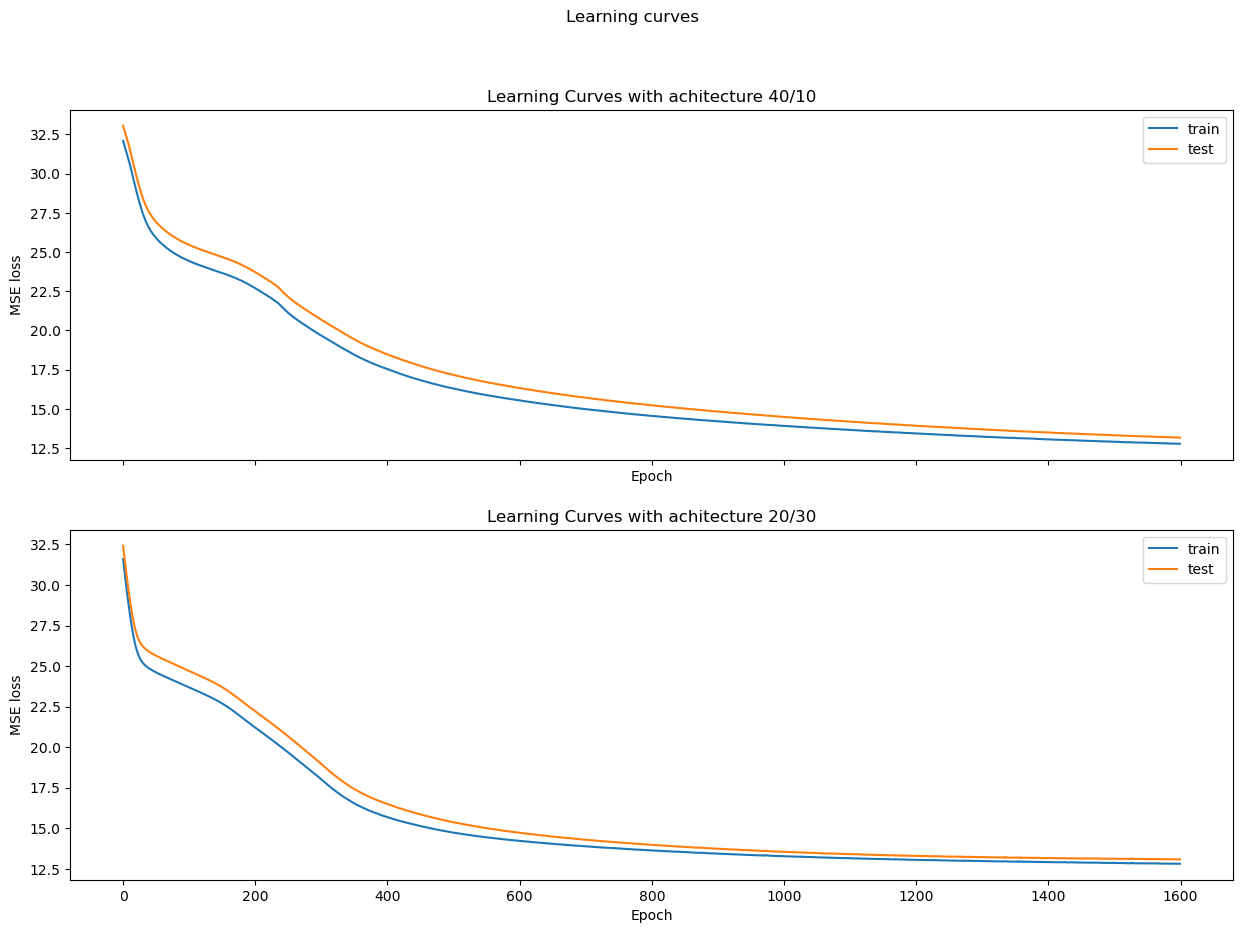

In [19]:
def tuning_arch(learning_rate1, num_percept_layers):
    #tuning the architecture of the NN
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('Learning curves')
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(len(num_percept_layers)):
     
        [num_percept_layer1, num_percept_layer2] = num_percept_layers[i]
     
        model, history = train(learning_rate1, num_percept_layer1, num_percept_layer2)

        model.save('./exer2_model.h5')

        # plot learning curves
        axs[i].set_title('Learning Curves with achitecture ' + str(num_percept_layer1) + '/' + str(num_percept_layer2))
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('MSE loss')
        axs[i].plot((history.history['loss']), label='train')
        axs[i].plot((history.history['val_loss']), label='test')
        axs[i].legend()
    
    plt.show()

# training with the train dataset for different numbers of perceptrons in each layer
learning_rate1= 0.001
epochs = 1600       
batch_size = 8000
num_percept_layers= [ [40, 10] , [20, 30] ]

tuning_arch(learning_rate1, num_percept_layers)

(if needed, scroll down the output cell to view the plots)

The 20/10 architecture was well-chosen since the 40/10 and the 20/30 architectures do not perform better.

To have yet better results, one could try to raise the number of layers. This would maybe allow the network represent even more nonlinear relations between the data.